# EDA & Data preprocessing.

In [1]:
#pip install librosa
#pip install openpyxl

In [42]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import librosa
import json
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import librosa.display

#Figure setup
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Part 1: investigate the labels (Rahma + Angela)

In this section we import a single label csv to observe the format, we also add the duraction time as a column.

In [3]:
#read in the labels
path = os.path.join('..', 'Jupyter_NB', 'audio_assignment', 'Data', 'Label Data-20231021T013617Z-001', 'Label Data', 'Label_000.csv')
df0 =pd.read_csv(path, header=None)
# Rename columns for clarity
df0.columns = ['start_time', 'end_time', 'level']
# Calculate duration
df0['duration'] = df0['end_time'] - df0['start_time']
# Display the updated DataFrame
print(df0)

       start_time      end_time           level  duration
0     2819.986311   2819.986311  Start to sleep  0.000000
1     3041.878030   3045.269745              S1  3.391715
2     3047.026899   3050.418614              S1  3.391715
3     5039.720786   5043.194229              S1  3.473443
4     5168.074725   5171.834216              S1  3.759491
..            ...           ...             ...       ...
621  16433.840150  16437.191000              S1  3.350850
622  16438.457780  16441.849500              S1  3.391720
623  16496.893360  16500.080750              S1  3.187390
624  16500.407660  16503.799380              S2  3.391720
625  16504.534930  16507.640600              S1  3.105670

[626 rows x 4 columns]


In [4]:
# Path to the folder containing CSV files
folder_path =  os.path.join('..', 'Jupyter_NB', 'audio_assignment', 'Data', 'Label Data-20231021T013617Z-001', 'Label Data')

# List all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Initialize an empty list to hold dataframes
dfs = []

# Loop through each CSV file and read it into a DataFrame
for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    df = pd.read_csv(file_path, header=None)  # Assuming files don't have headers
    df['file_name'] = csv_file
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

# Rename columns for clarity
combined_df.columns = ['start_time', 'end_time', 'level',"file_name"]
# Calculate duration
combined_df['duration'] = combined_df['end_time'] - combined_df['start_time']

We now add all of the label files together into a single table

In total there are 19970 labels

In [5]:
combined_df.shape

(19970, 5)

#### Check for NULLs

There are three NULL labels associated with wav files  1,26 and 30. For the purpose of this project the null values will be removed, this is because there are only 3 out of 19970. Which is an extremely small portion of the dataset.

In [6]:
combined_df[combined_df.isnull().any(axis=1)]

start_time      end_time level      file_name  duration
1077  11563.983630  11567.312170   NaN  Label_001.csv  3.328540
7137   8294.597318   8297.687159   NaN  Label_026.csv  3.089841
9310   4109.494442   4112.727508   NaN  Label_030.csv  3.233066

### Data Cleaning Part 1 - remove NA values

In [7]:
# Drop rows with null values
combined_df.dropna(inplace=True)

#### Check labels

Looking at the unique labels it appers that there are the three main expected labels S1, S2 and S3 as well as several other what looks like S1 typos. These will all be converted to S1. Additionally there is a row stating the start to sleep time, which can be removed for part 1.

In [8]:
# Get distinct levels
combined_df['level'].unique()

array(['Start to sleep', 'S1', 'S2', 'S3', 'S1`', '1', 'S1  ', 'S!', '1S',
       'W1', 'SS1', 'D1'], dtype=object)

In [13]:
# Replace typo levels with 'S1'
typo_levels = ['1', 'S1`', 'S1  ','S!', '1S', 'W1', 'SS1', 'D1']
correct_level = 'S1'
combined_df['level'] = combined_df['level'].replace(typo_levels, correct_level)

#drop the start to sleep level
combined_df = combined_df[combined_df['level'] != 'Start to sleep']

Now looking at the counts for each label it apears that the classes are highly imbalances with S1 being the dominant class with S2 and S3 being almost extrmeme minority classes particularly S3. This could be problematic when it comes time to training a multiclass model.

In [14]:
#Print the count for each level
level_count = combined_df['level'].value_counts()
print(level_count)

level
S1    18994
S2      865
S3       81
Name: count, dtype: int64


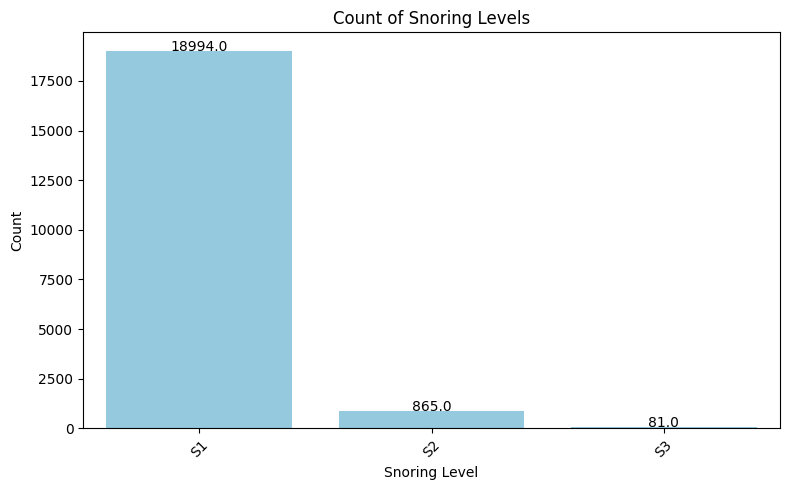

In [15]:
# Create a count plot of snoring levels without 'Start to sleep'

plt.figure(figsize=(8, 5))
ax = sns.countplot(data=combined_df, x='level', color='skyblue', order=combined_df['level'].value_counts().index)
plt.xlabel('Snoring Level')
plt.ylabel('Count')
plt.title('Count of Snoring Levels')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Add count labels above the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
    
plt.tight_layout()
plt.show()

# Part 2: Data Loading and preprocessing (Tenzin + Linda)

This section of code processes a collection of WAV audio files and their corresponding CSV files.  For each WAV file, it reads the associated CSV data, and organizes it into a structured format. The code distinguishes sleep start times from snoring events, calculates the duration between them, and combines them into a new DataFrame. Additionally, it accounts for gaps between snoring events by inserting non-snoring data with 'N' labels. The processed data is stored in a dictionary, where WAV file names serve as keys, and DataFrames as values. Finally, the code saves the preprocessed data into separate CSV files for further analysis.

Input: Cleaned CSV label files
Output: Preprocessed label files stored in data/preprocessed_csv folder

In [20]:
# Path to data folders
wav_path = 'data/wav'
csv_path = 'data/cleaned_csv'
csv_output_path = 'data/preprocessed_csv'

# Initialize a dictionary to store data
data_dict = {}

# Loop through all files in the WAV folder
for file_name in os.listdir(wav_path):
    if file_name.endswith('.wav'):
        base_name, _ = os.path.splitext(file_name)

        # Form corresponding CSV file name
        csv_file_name = f'Label_{base_name.split("_")[-1]}.csv'
        csv_file_path = os.path.join(csv_path, csv_file_name)

        if os.path.exists(csv_file_path):
            # Load sleep start times and snoring data from the corresponding CSV file
            data = pd.read_csv(csv_file_path, delimiter=',', header=0, names=['start_time', 'end_time', 'label', 'duration'])

            # Separate sleep start time and snoring data
            snoring_data = data.iloc[1:]  # Exclude the sleep start time

            # Initialize a list to store rows of snoring and non-snoring data
            data_rows = []

            # Append the first normal moment: sleeping start time till first snore start time
            sleep_start = data.iloc[0]['start_time']
            first_snore = snoring_data.iloc[0]['start_time']
            duration = first_snore - sleep_start
            data_rows.append({'start_time': sleep_start, 'end_time': first_snore, 'label': 'N', 'duration': duration})

            for i in range(len(snoring_data)):
                row = snoring_data.iloc[i]
                start_time = row['start_time']
                end_time = row['end_time']
                label = row['label']
                duration = end_time-start_time

                data_rows.append({'start_time': start_time, 'end_time': end_time, 'label': label, 'duration': duration})

                if i < len(snoring_data) - 1:
                    next_row = snoring_data.iloc[i + 1]
                    next_start_time = next_row['start_time']

                    if next_start_time > end_time:
                        duration = next_start_time - end_time
                        data_rows.append({'start_time': end_time, 'end_time': next_start_time, 'label': 'N', 'duration': duration})

            # Create a new DataFrame with combined snoring and non-snoring data
            combined_data = pd.DataFrame(data_rows, columns=['start_time', 'end_time', 'label', 'duration'])

            # Append the combined data to the dictionary
            data_dict[file_name] = combined_data

# Create the output folder if it doesn't exist
if not os.path.exists(csv_output_path):
    os.makedirs(csv_output_path)

# Loop through all WAV files in data_dict and save them as CSV
for wav_file, segment_data in data_dict.items():
    # Extract the file number
    file_number = os.path.splitext(wav_file)[0].split('_')[-1]

    # Create the output CSV file path
    output_file_path = os.path.join(csv_output_path, f'label_{file_number}.csv')

    # Save the DataFrame as CSV
    segment_data.to_csv(output_file_path, index=False)

In [21]:
len(data_dict)

27

In [22]:
list(data_dict.items())[0]

('Video_00_048.wav',
       start_time     end_time label    duration
 0     360.009025  1004.479277     N  644.470252
 1    1004.479277  1007.469037    S1    2.989760
 2    1007.469037  1008.029617     N    0.560580
 3    1008.029617  1011.019377    S1    2.989760
 4    1011.019377  1011.926983     N    0.907606
 ..           ...          ...   ...         ...
 370  4920.504297  4986.679431     N   66.175134
 371  4986.679431  4989.669191    S1    2.989760
 372  4989.669191  4992.658951    S1    2.989760
 373  4992.658951  5644.106300     N  651.447349
 374  5644.106300  5647.096060    S1    2.989760
 
 [375 rows x 4 columns])

## Part 3: Resample the wav files
This section of resamples the audios to 16000  using Librosa library and subsequently stores the resampled audio in a newly created directory named 'resampled_wav.'

Resampled wav files are stored in data/resassmpled_wav folder

In [ ]:
#pip install scipy

In [ ]:
resampled_wav_path = 'data/resassmpled_wav'  # New folder for resampled WAV files

# Create the 'resampled_wav' folder if it doesn't exist
if not os.path.exists(resampled_wav_path):
    os.makedirs(resampled_wav_path)

# New sample rate for resampling
new_sr = 16000  # Adjust to your desired sample rate

# Initialize a new dictionary to store resampled data
resampled_data_dict = {}

# Loop through the original data dictionary
for wav_file, data in data_dict.items():
    # Load the original audio file using librosa
    wav_file_path = os.path.join(wav_path, wav_file)
    original_x, original_sr = librosa.load(wav_file_path, sr=None)
    
    # Resample the audio data using librosa
    resampled_audio = librosa.resample(original_x, original_sr, new_sr)
    # Save the resampled audio to a new WAV file
    resampled_wav_file_path = os.path.join(resampled_wav_path, wav_file)
    sf.write(resampled_wav_file_path, resampled_audio, new_sr)

## Comparing the resampled and orginal wav files

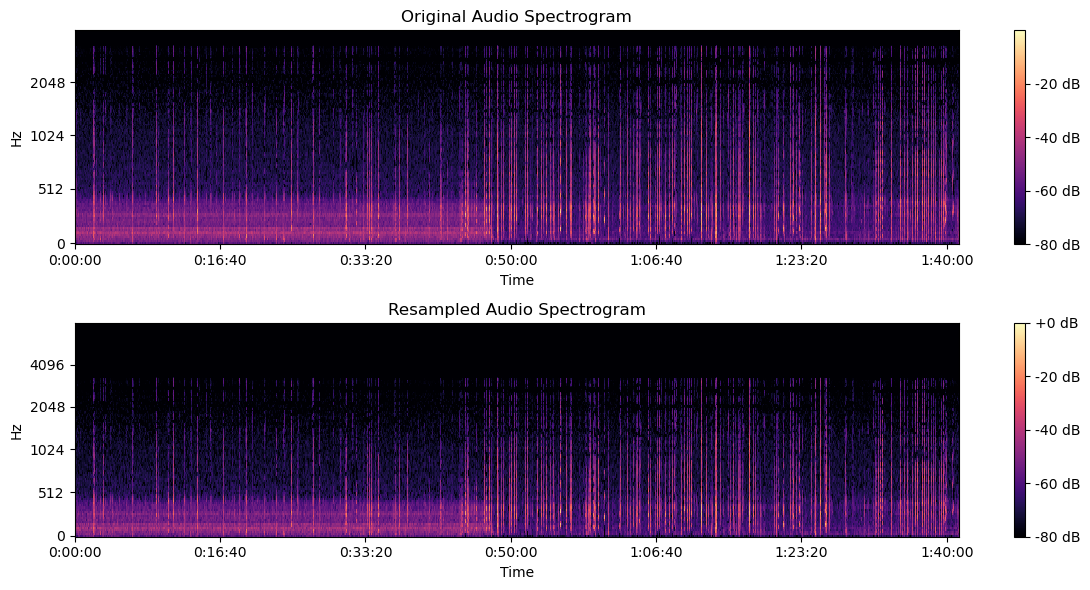

In [6]:
original_x, original_sr = librosa.load('data/wav/Video_00_050.wav', sr=None)
resampled_x, resampled_sr = librosa.load('data/resampled_wav/Video_00_050.wav', sr=None)
# Compute the spectrogram for the original audio
original_spectrogram = librosa.feature.melspectrogram(y=original_x, sr=original_sr)

# Compute the spectrogram for the resampled audio
resampled_spectrogram = librosa.feature.melspectrogram(y=resampled_x, sr=resampled_sr)

# Plot the spectrograms
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.power_to_db(original_spectrogram, ref=np.max),
                         y_axis='mel', x_axis='time', sr=original_sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Original Audio Spectrogram')

plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.power_to_db(resampled_spectrogram, ref=np.max),
                         y_axis='mel', x_axis='time', sr=resampled_sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Resampled Audio Spectrogram')

plt.tight_layout()
plt.show()

## Part 4: MFCC Extraction

The script loops through a collection of WAV files, each containing audio segments with associated labels. For each segment, it loads the audio, computes MFCCs using Librosa, and appends the MFCC data, along with segment information, into a list. After processing all segments within a WAV file, it creates a DataFrame and saves it as a CSV file named after the WAV file. The script accumulates data from all WAV files into a final combined DataFrame and saves it as 'all_mfcc.csv.'

Input: data_dict from part 1 and resampled wav files.
Output: mfcc features for individual wav files and combined one stored in the data/mfcc_features_csv folder

Window size:50 milliseconds (0.05 x 16000=800 frames)
overlap: 50% (400 frames)

In [23]:
# Path to data folders
wav_path = 'data/resampled_wav'
mfcc_features_folder = 'data/mfcc_features_csv'  # Change this to the folder where you want to save CSV files

window_size = 0.05  # 50 milliseconds
overlap = 0.5  # 50% overlap
# Initialize a list to store all rows of MFCCs and label information
all_mfcc_data = []

if not os.path.exists(mfcc_features_folder):
    os.makedirs(mfcc_features_folder)

# Loop through all files in the WAV folder
for wav_file, segment_data in data_dict.items():
    print(f"Extracting MFCC for {wav_file}")
    current_mfcc_data = []
    segment_count = 0
    seg_length = len(segment_data)
    for i in range(len(segment_data)):
        row = segment_data.iloc[i]
        start_time = row['start_time']
        end_time = row['end_time']
        label = row['label']
        duration = row['duration']

        # Load the audio segment
        wav_file_path = os.path.join(wav_path, wav_file)
        audio_data, sr = librosa.load(wav_file_path, sr=None, offset=start_time, duration=end_time - start_time)
        segment_count += 1
        print(f"Processing Segment no {segment_count} of length {seg_length} with duration {duration} seconds with label {label}")

        n_fft = int(window_size * sr)  # Set n_fft based on window size
        if n_fft > len(audio_data):
            n_fft = len(audio_data)

        hop_length = int(n_fft * (1 - overlap))  # Calculate hop length based on overlap
        # Compute MFCCs for the windowed audio
        mfccs = librosa.feature.mfcc(y=audio_data,
                                     sr=sr,
                                     n_mfcc=13,  # Number of MFCC coefficients
                                     n_fft=n_fft,
                                     hop_length=hop_length
                                     )
        # Append the MFCCs along with label, time, and num_mfcc_values information
        mfcc_row = {
            'wav_id':wav_file,
            'start_time': start_time,
            'end_time': end_time,
            'duration': duration,
            'label': label,
            **{f'mfcc_{i + 1}': mfccs[i].tolist() for i in range(13)},
            'num_mfcc_values': mfccs.shape[1]
        }
        current_mfcc_data.append(mfcc_row)

    # Create a new DataFrame with MFCCs and label information
    np.set_printoptions(threshold=np.inf, linewidth=np.inf)
    current_mfcc = pd.DataFrame(current_mfcc_data)
    file_number = wav_file.split('_')[-1].split('.')[0]
    output_file_path = os.path.join(mfcc_features_folder, f'{file_number}_mfcc.csv')
    current_mfcc.to_csv(output_file_path, index=False)

    all_mfcc_data.extend(current_mfcc_data)

# Create a combined DataFrame with all MFCCs and label information
all_mfcc = pd.DataFrame(all_mfcc_data)
all_output_file_path = os.path.join(mfcc_features_folder, f'all_mfcc.csv')
all_mfcc.to_csv(all_output_file_path, index=False)

Extracting MFCC for Video_00_048.wav
Processing Segment no 1 of length 375 with duration 644.4702520000001 seconds with label N
Processing Segment no 2 of length 375 with duration 2.989759999999933 seconds with label S1
Processing Segment no 3 of length 375 with duration 0.5605800000000727 seconds with label N
Processing Segment no 4 of length 375 with duration 2.989759999999933 seconds with label S1
Processing Segment no 5 of length 375 with duration 0.907605999999987 seconds with label N
Processing Segment no 6 of length 375 with duration 2.9897600000000466 seconds with label S1
Processing Segment no 7 of length 375 with duration 13.93441699999994 seconds with label N
Processing Segment no 8 of length 375 with duration 2.9897600000001603 seconds with label S1
Processing Segment no 9 of length 375 with duration 1.2279369999998835 seconds with label N
Processing Segment no 10 of length 375 with duration 2.989759999999933 seconds with label S1
Processing Segment no 11 of length 375 with

Processing Segment no 117 of length 375 with duration 1.0944660000000113 seconds with label N
Processing Segment no 118 of length 375 with duration 2.9897600000001603 seconds with label S1
Processing Segment no 119 of length 375 with duration 0.5338859999999386 seconds with label N
Processing Segment no 120 of length 375 with duration 2.989759999999933 seconds with label S1
Processing Segment no 121 of length 375 with duration 5.178691000000072 seconds with label N
Processing Segment no 122 of length 375 with duration 2.989759999999933 seconds with label S1
Processing Segment no 123 of length 375 with duration 0.9609940000000279 seconds with label N
Processing Segment no 124 of length 375 with duration 2.989759999999933 seconds with label S1
Processing Segment no 125 of length 375 with duration 0.2936370000002171 seconds with label N
Processing Segment no 126 of length 375 with duration 2.989759999999933 seconds with label S1
Processing Segment no 127 of length 375 with duration 0.8809

Processing Segment no 277 of length 375 with duration 1.2546319999999014 seconds with label N
Processing Segment no 278 of length 375 with duration 2.989759999999933 seconds with label S1
Processing Segment no 279 of length 375 with duration 8.061674000000039 seconds with label N
Processing Segment no 280 of length 375 with duration 2.989759999999933 seconds with label S1
Processing Segment no 281 of length 375 with duration 1.5749630000000252 seconds with label N
Processing Segment no 282 of length 375 with duration 2.9897600000001603 seconds with label S1
Processing Segment no 283 of length 375 with duration 0.6139679999998862 seconds with label N
Processing Segment no 284 of length 375 with duration 2.989759999999933 seconds with label S1
Processing Segment no 285 of length 375 with duration 0.960995000000139 seconds with label N
Processing Segment no 286 of length 375 with duration 2.989759999999933 seconds with label S1
Processing Segment no 287 of length 375 with duration 0.56058

Processing Segment no 368 of length 375 with duration 2.989759999999478 seconds with label S1
Processing Segment no 369 of length 375 with duration 0.3470260000003691 seconds with label N
Processing Segment no 370 of length 375 with duration 2.9897600000003877 seconds with label S1
Processing Segment no 371 of length 375 with duration 66.17513399999916 seconds with label N
Processing Segment no 372 of length 375 with duration 2.9897600000003877 seconds with label S1
Processing Segment no 373 of length 375 with duration 2.9897600000003877 seconds with label S1
Processing Segment no 374 of length 375 with duration 651.447349 seconds with label N
Processing Segment no 375 of length 375 with duration 2.989759999999478 seconds with label S1
Extracting MFCC for Video_00_049.wav
Processing Segment no 1 of length 3029 with duration 183.251418 seconds with label N
Processing Segment no 2 of length 3029 with duration 2.9879960000000096 seconds with label S1
Processing Segment no 3 of length 3029

Processing Segment no 127 of length 3029 with duration 1.1901339999999436 seconds with label N
Processing Segment no 128 of length 3029 with duration 2.9879960000000665 seconds with label S1
Processing Segment no 129 of length 3029 with duration 1.2154560000000174 seconds with label N
Processing Segment no 130 of length 3029 with duration 2.987995999999953 seconds with label S1
Processing Segment no 131 of length 3029 with duration 0.6330500000000256 seconds with label N
Processing Segment no 132 of length 3029 with duration 2.987995999999953 seconds with label S1
Processing Segment no 133 of length 3029 with duration 0.7596600000000535 seconds with label N
Processing Segment no 134 of length 3029 with duration 2.987995999999953 seconds with label S1
Processing Segment no 135 of length 3029 with duration 1.1648119999999835 seconds with label N
Processing Segment no 136 of length 3029 with duration 2.9879960000000665 seconds with label S1
Processing Segment no 137 of length 3029 with du

Processing Segment no 254 of length 3029 with duration 2.987995999999839 seconds with label S1
Processing Segment no 255 of length 3029 with duration 0.8103040000000874 seconds with label N
Processing Segment no 256 of length 3029 with duration 2.9879960000000665 seconds with label S1
Processing Segment no 257 of length 3029 with duration 1.4939979999999196 seconds with label N
Processing Segment no 258 of length 3029 with duration 3.0133180000000266 seconds with label S1
Processing Segment no 259 of length 3029 with duration 0.9115919999999278 seconds with label N
Processing Segment no 260 of length 3029 with duration 2.9879960000000665 seconds with label S1
Processing Segment no 261 of length 3029 with duration 0.9369139999998879 seconds with label N
Processing Segment no 262 of length 3029 with duration 2.9879960000000665 seconds with label S1
Processing Segment no 263 of length 3029 with duration 0.6330500000001393 seconds with label N
Processing Segment no 264 of length 3029 with 

Processing Segment no 364 of length 3029 with duration 2.987995999999839 seconds with label S1
Processing Segment no 365 of length 3029 with duration 0.7596600000001672 seconds with label N
Processing Segment no 366 of length 3029 with duration 3.013317999999799 seconds with label S1
Processing Segment no 367 of length 3029 with duration 0.43047400000023117 seconds with label N
Processing Segment no 368 of length 3029 with duration 3.013317999999799 seconds with label S1
Processing Segment no 369 of length 3029 with duration 7.4699900000000525 seconds with label N
Processing Segment no 370 of length 3029 with duration 3.013317999999799 seconds with label S1
Processing Segment no 371 of length 3029 with duration 1.6206080000001748 seconds with label N
Processing Segment no 372 of length 3029 with duration 3.013318000000254 seconds with label S1
Processing Segment no 373 of length 3029 with duration 0.6077279999999519 seconds with label N
Processing Segment no 374 of length 3029 with dur

Processing Segment no 498 of length 3029 with duration 2.987995999999839 seconds with label S1
Processing Segment no 499 of length 3029 with duration 1.1141680000000633 seconds with label N
Processing Segment no 500 of length 3029 with duration 3.013318000000254 seconds with label S1
Processing Segment no 501 of length 3029 with duration 0.7343380000002071 seconds with label N
Processing Segment no 502 of length 3029 with duration 2.987995999999839 seconds with label S1
Processing Segment no 503 of length 3029 with duration 1.0635240000001431 seconds with label N
Processing Segment no 504 of length 3029 with duration 2.987995999999839 seconds with label S1
Processing Segment no 505 of length 3029 with duration 0.7596599999997125 seconds with label N
Processing Segment no 506 of length 3029 with duration 2.987995999999839 seconds with label S1
Processing Segment no 507 of length 3029 with duration 0.8103040000005421 seconds with label N
Processing Segment no 508 of length 3029 with dura

Processing Segment no 636 of length 3029 with duration 0.8103039999996327 seconds with label N
Processing Segment no 637 of length 3029 with duration 2.9879960000007486 seconds with label S1
Processing Segment no 638 of length 3029 with duration 1.4686759999995047 seconds with label N
Processing Segment no 639 of length 3029 with duration 3.013318000000254 seconds with label S1
Processing Segment no 640 of length 3029 with duration 0.9622360000003027 seconds with label N
Processing Segment no 641 of length 3029 with duration 3.0133179999993445 seconds with label S1
Processing Segment no 642 of length 3029 with duration 7.824497999999949 seconds with label N
Processing Segment no 643 of length 3029 with duration 2.9879960000007486 seconds with label S1
Processing Segment no 644 of length 3029 with duration 0.6583719999998721 seconds with label N
Processing Segment no 645 of length 3029 with duration 2.987995999999839 seconds with label S1
Processing Segment no 646 of length 3029 with du

Processing Segment no 755 of length 3029 with duration 8.305615999999645 seconds with label N
Processing Segment no 756 of length 3029 with duration 2.9879960000007486 seconds with label S1
Processing Segment no 757 of length 3029 with duration 22.106105999999272 seconds with label N
Processing Segment no 758 of length 3029 with duration 3.013318000000254 seconds with label S1
Processing Segment no 759 of length 3029 with duration 0.5064400000001115 seconds with label N
Processing Segment no 760 of length 3029 with duration 2.987995999999839 seconds with label S1
Processing Segment no 761 of length 3029 with duration 4.355384000000413 seconds with label N
Processing Segment no 762 of length 3029 with duration 3.0133179999993445 seconds with label S1
Processing Segment no 763 of length 3029 with duration 20.282922000000326 seconds with label N
Processing Segment no 764 of length 3029 with duration 2.987995999999839 seconds with label S1
Processing Segment no 765 of length 3029 with dura

Processing Segment no 877 of length 3029 with duration 1.6206080000001748 seconds with label N
Processing Segment no 878 of length 3029 with duration 2.987995999999839 seconds with label S1
Processing Segment no 879 of length 3029 with duration 1.012880000000223 seconds with label N
Processing Segment no 880 of length 3029 with duration 3.0133179999993445 seconds with label S1
Processing Segment no 881 of length 3029 with duration 1.1901340000003984 seconds with label N
Processing Segment no 882 of length 3029 with duration 2.987995999999839 seconds with label S1
Processing Segment no 883 of length 3029 with duration 1.088846000000558 seconds with label N
Processing Segment no 884 of length 3029 with duration 2.987995999999839 seconds with label S1
Processing Segment no 885 of length 3029 with duration 1.0888459999996485 seconds with label N
Processing Segment no 886 of length 3029 with duration 3.013318000000254 seconds with label S1
Processing Segment no 887 of length 3029 with durat

Processing Segment no 1028 of length 3029 with duration 0.20257600000059028 seconds with label N
Processing Segment no 1029 of length 3029 with duration 2.987995999999839 seconds with label S1
Processing Segment no 1030 of length 3029 with duration 0.7849820000001273 seconds with label N
Processing Segment no 1031 of length 3029 with duration 2.987995999999839 seconds with label S1
Processing Segment no 1032 of length 3029 with duration 0.5317619999996168 seconds with label N
Processing Segment no 1033 of length 3029 with duration 2.9879960000007486 seconds with label S1
Processing Segment no 1034 of length 3029 with duration 1.0888459999996485 seconds with label N
Processing Segment no 1035 of length 3029 with duration 2.987995999999839 seconds with label S1
Processing Segment no 1036 of length 3029 with duration 0.9115920000003825 seconds with label N
Processing Segment no 1037 of length 3029 with duration 2.987995999999839 seconds with label S1
Processing Segment no 1038 of length 3

Processing Segment no 1143 of length 3029 with duration 2664.051653999999 seconds with label N
Processing Segment no 1144 of length 3029 with duration 3.0133180000011635 seconds with label S1
Processing Segment no 1145 of length 3029 with duration 1.9497940000001108 seconds with label N
Processing Segment no 1146 of length 3029 with duration 3.0133179999993445 seconds with label S1
Processing Segment no 1147 of length 3029 with duration 6.279856000001018 seconds with label N
Processing Segment no 1148 of length 3029 with duration 3.0133179999993445 seconds with label S1
Processing Segment no 1149 of length 3029 with duration 1.4686760000004142 seconds with label N
Processing Segment no 1150 of length 3029 with duration 3.0133179999993445 seconds with label S1
Processing Segment no 1151 of length 3029 with duration 1.4686760000004142 seconds with label N
Processing Segment no 1152 of length 3029 with duration 2.987995999999839 seconds with label S1
Processing Segment no 1153 of length 3

Processing Segment no 1262 of length 3029 with duration 3.0133179999993445 seconds with label S1
Processing Segment no 1263 of length 3029 with duration 1.164812000000893 seconds with label N
Processing Segment no 1264 of length 3029 with duration 3.0133179999993445 seconds with label S1
Processing Segment no 1265 of length 3029 with duration 0.8862700000008772 seconds with label N
Processing Segment no 1266 of length 3029 with duration 3.0133179999993445 seconds with label S1
Processing Segment no 1267 of length 3029 with duration 1.2154559999999037 seconds with label N
Processing Segment no 1268 of length 3029 with duration 2.987995999999839 seconds with label S1
Processing Segment no 1269 of length 3029 with duration 1.4939979999999196 seconds with label N
Processing Segment no 1270 of length 3029 with duration 2.987995999999839 seconds with label S1
Processing Segment no 1271 of length 3029 with duration 1.59528599999976 seconds with label N
Processing Segment no 1272 of length 302

Processing Segment no 1387 of length 3029 with duration 2.987995999999839 seconds with label S1
Processing Segment no 1388 of length 3029 with duration 66.44492799999898 seconds with label N
Processing Segment no 1389 of length 3029 with duration 2.9626740000003338 seconds with label S1
Processing Segment no 1390 of length 3029 with duration 1.3673880000005738 seconds with label N
Processing Segment no 1391 of length 3029 with duration 2.987995999999839 seconds with label S1
Processing Segment no 1392 of length 3029 with duration 1.012880000000223 seconds with label N
Processing Segment no 1393 of length 3029 with duration 3.0133179999993445 seconds with label S1
Processing Segment no 1394 of length 3029 with duration 2.987995999999839 seconds with label S1
Processing Segment no 1395 of length 3029 with duration 2.987995999999839 seconds with label S1
Processing Segment no 1396 of length 3029 with duration 17.01638400000047 seconds with label N
Processing Segment no 1397 of length 3029

Processing Segment no 1508 of length 3029 with duration 1.012880000000223 seconds with label N
Processing Segment no 1509 of length 3029 with duration 3.0133200000000215 seconds with label S1
Processing Segment no 1510 of length 3029 with duration 1.0635300000012649 seconds with label N
Processing Segment no 1511 of length 3029 with duration 3.013309999998455 seconds with label S1
Processing Segment no 1512 of length 3029 with duration 1.1394900000013877 seconds with label N
Processing Segment no 1513 of length 3029 with duration 3.0133200000000215 seconds with label S1
Processing Segment no 1514 of length 3029 with duration 4.0262000000002445 seconds with label N
Processing Segment no 1515 of length 3029 with duration 2.9879999999993743 seconds with label S1
Processing Segment no 1516 of length 3029 with duration 1.0888400000003458 seconds with label N
Processing Segment no 1517 of length 3029 with duration 2.9879999999993743 seconds with label S1
Processing Segment no 1518 of length 

Processing Segment no 1613 of length 3029 with duration 2.9879999999993743 seconds with label S1
Processing Segment no 1614 of length 3029 with duration 0.30385999999998603 seconds with label N
Processing Segment no 1615 of length 3029 with duration 2.9880000000011933 seconds with label S1
Processing Segment no 1616 of length 3029 with duration 3.2412199999998847 seconds with label N
Processing Segment no 1617 of length 3029 with duration 3.013309999998455 seconds with label S1
Processing Segment no 1618 of length 3029 with duration 0.7343400000008842 seconds with label N
Processing Segment no 1619 of length 3029 with duration 3.0133200000000215 seconds with label S1
Processing Segment no 1620 of length 3029 with duration 0.7343399999990652 seconds with label N
Processing Segment no 1621 of length 3029 with duration 3.0133200000000215 seconds with label S1
Processing Segment no 1622 of length 3029 with duration 0.7090100000004895 seconds with label N
Processing Segment no 1623 of lengt

Processing Segment no 1737 of length 3029 with duration 2.9880000000011933 seconds with label S1
Processing Segment no 1738 of length 3029 with duration 1.823179999999411 seconds with label N
Processing Segment no 1739 of length 3029 with duration 3.0133200000000215 seconds with label S1
Processing Segment no 1740 of length 3029 with duration 1.5699700000004668 seconds with label N
Processing Segment no 1741 of length 3029 with duration 2.987989999999627 seconds with label S1
Processing Segment no 1742 of length 3029 with duration 1.367389999999432 seconds with label N
Processing Segment no 1743 of length 3029 with duration 2.9880000000011933 seconds with label S1
Processing Segment no 1744 of length 3029 with duration 51.7834899999998 seconds with label N
Processing Segment no 1745 of length 3029 with duration 2.987989999999627 seconds with label S1
Processing Segment no 1746 of length 3029 with duration 1.367389999999432 seconds with label N
Processing Segment no 1747 of length 3029 

Processing Segment no 1847 of length 3029 with duration 2.9879999999993743 seconds with label S1
Processing Segment no 1848 of length 3029 with duration 1.4940000000005966 seconds with label N
Processing Segment no 1849 of length 3029 with duration 2.987989999999627 seconds with label S1
Processing Segment no 1850 of length 3029 with duration 83.13212999999996 seconds with label N
Processing Segment no 1851 of length 3029 with duration 3.0133200000000215 seconds with label S1
Processing Segment no 1852 of length 3029 with duration 1619.4431800000002 seconds with label N
Processing Segment no 1853 of length 3029 with duration 3.0133200000000215 seconds with label S1
Processing Segment no 1854 of length 3029 with duration 17.801369999999224 seconds with label N
Processing Segment no 1855 of length 3029 with duration 3.0133200000000215 seconds with label S1
Processing Segment no 1856 of length 3029 with duration 0.22789000000011583 seconds with label N
Processing Segment no 1857 of length

Processing Segment no 1976 of length 3029 with duration 3.0133200000000215 seconds with label S1
Processing Segment no 1977 of length 3029 with duration 1.012880000000223 seconds with label N
Processing Segment no 1978 of length 3029 with duration 2.9879999999993743 seconds with label S1
Processing Segment no 1979 of length 3029 with duration 1.1141700000007404 seconds with label N
Processing Segment no 1980 of length 3029 with duration 3.013310000000274 seconds with label S1
Processing Segment no 1981 of length 3029 with duration 0.9115999999994528 seconds with label N
Processing Segment no 1982 of length 3029 with duration 2.9373500000001513 seconds with label S1
Processing Segment no 1983 of length 3029 with duration 1.4940000000005966 seconds with label N
Processing Segment no 1984 of length 3029 with duration 2.987989999999627 seconds with label S1
Processing Segment no 1985 of length 3029 with duration 0.8103099999989354 seconds with label N
Processing Segment no 1986 of length 3

Processing Segment no 2080 of length 3029 with duration 2.9879999999975553 seconds with label S1
Processing Segment no 2081 of length 3029 with duration 0.9369100000003527 seconds with label N
Processing Segment no 2082 of length 3029 with duration 2.9880000000011933 seconds with label S1
Processing Segment no 2083 of length 3029 with duration 17.649430000001303 seconds with label N
Processing Segment no 2084 of length 3029 with duration 2.9879999999975553 seconds with label S1
Processing Segment no 2085 of length 3029 with duration 127.0151500000029 seconds with label N
Processing Segment no 2086 of length 3029 with duration 2.987989999997808 seconds with label S1
Processing Segment no 2087 of length 3029 with duration 1.4686800000017683 seconds with label N
Processing Segment no 2088 of length 3029 with duration 3.0133199999982025 seconds with label S1
Processing Segment no 2089 of length 3029 with duration 11.104309999998804 seconds with label N
Processing Segment no 2090 of length 

Processing Segment no 2172 of length 3029 with duration 3.0133200000018405 seconds with label S1
Processing Segment no 2173 of length 3029 with duration 39.907469999998284 seconds with label N
Processing Segment no 2174 of length 3029 with duration 2.9880000000011933 seconds with label S1
Processing Segment no 2175 of length 3029 with duration 0.810300000001007 seconds with label N
Processing Segment no 2176 of length 3029 with duration 3.0133199999982025 seconds with label S1
Processing Segment no 2177 of length 3029 with duration 280.49179000000004 seconds with label N
Processing Segment no 2178 of length 3029 with duration 2.9880000000011933 seconds with label S1
Processing Segment no 2179 of length 3029 with duration 2.9879999999975553 seconds with label S1
Processing Segment no 2180 of length 3029 with duration 711.49755 seconds with label N
Processing Segment no 2181 of length 3029 with duration 3.0133200000018405 seconds with label S1
Processing Segment no 2182 of length 3029 wi

Processing Segment no 2282 of length 3029 with duration 1.468669999998383 seconds with label N
Processing Segment no 2283 of length 3029 with duration 3.0133200000018405 seconds with label S1
Processing Segment no 2284 of length 3029 with duration 1.5699700000004668 seconds with label N
Processing Segment no 2285 of length 3029 with duration 2.987989999997808 seconds with label S1
Processing Segment no 2286 of length 3029 with duration 1.3927100000000792 seconds with label N
Processing Segment no 2287 of length 3029 with duration 3.0133200000018405 seconds with label S1
Processing Segment no 2288 of length 3029 with duration 2.608169999999518 seconds with label N
Processing Segment no 2289 of length 3029 with duration 2.987990000001446 seconds with label S1
Processing Segment no 2290 of length 3029 with duration 1.5952899999974761 seconds with label N
Processing Segment no 2291 of length 3029 with duration 3.0133200000018405 seconds with label S1
Processing Segment no 2292 of length 30

Processing Segment no 2414 of length 3029 with duration 0.7596599999997125 seconds with label N
Processing Segment no 2415 of length 3029 with duration 3.013309999998455 seconds with label S1
Processing Segment no 2416 of length 3029 with duration 1.4686800000017683 seconds with label N
Processing Segment no 2417 of length 3029 with duration 2.9879999999975553 seconds with label S1
Processing Segment no 2418 of length 3029 with duration 1.012880000002042 seconds with label N
Processing Segment no 2419 of length 3029 with duration 3.013309999998455 seconds with label S1
Processing Segment no 2420 of length 3029 with duration 1.3927100000000792 seconds with label N
Processing Segment no 2421 of length 3029 with duration 3.0133200000018405 seconds with label S1
Processing Segment no 2422 of length 3029 with duration 0.8356299999977637 seconds with label N
Processing Segment no 2423 of length 3029 with duration 2.987990000001446 seconds with label S1
Processing Segment no 2424 of length 30

Processing Segment no 2533 of length 3029 with duration 2.9880000000011933 seconds with label S1
Processing Segment no 2534 of length 3029 with duration 1.519319999999425 seconds with label N
Processing Segment no 2535 of length 3029 with duration 2.987990000001446 seconds with label S1
Processing Segment no 2536 of length 3029 with duration 0.7343399999990652 seconds with label N
Processing Segment no 2537 of length 3029 with duration 3.0133200000018405 seconds with label S1
Processing Segment no 2538 of length 3029 with duration 1.0635199999996985 seconds with label N
Processing Segment no 2539 of length 3029 with duration 2.9879999999975553 seconds with label S1
Processing Segment no 2540 of length 3029 with duration 1.3673900000030699 seconds with label N
Processing Segment no 2541 of length 3029 with duration 2.987989999997808 seconds with label S1
Processing Segment no 2542 of length 3029 with duration 0.9875600000013947 seconds with label N
Processing Segment no 2543 of length 3

Processing Segment no 2676 of length 3029 with duration 0.9369100000003527 seconds with label N
Processing Segment no 2677 of length 3029 with duration 2.9879999999975553 seconds with label S1
Processing Segment no 2678 of length 3029 with duration 1.2154499999996915 seconds with label N
Processing Segment no 2679 of length 3029 with duration 2.9880000000011933 seconds with label S1
Processing Segment no 2680 of length 3029 with duration 1.2661000000007334 seconds with label N
Processing Segment no 2681 of length 3029 with duration 2.987990000001446 seconds with label S1
Processing Segment no 2682 of length 3029 with duration 8.9133499999989 seconds with label N
Processing Segment no 2683 of length 3029 with duration 2.987989999997808 seconds with label S1
Processing Segment no 2684 of length 3029 with duration 1.5193200000030629 seconds with label N
Processing Segment no 2685 of length 3029 with duration 3.0133199999982025 seconds with label S1
Processing Segment no 2686 of length 302

Processing Segment no 2808 of length 3029 with duration 1.5699600000007194 seconds with label N
Processing Segment no 2809 of length 3029 with duration 3.0133199999982025 seconds with label S1
Processing Segment no 2810 of length 3029 with duration 1.5446400000000722 seconds with label N
Processing Segment no 2811 of length 3029 with duration 3.0133200000018405 seconds with label S1
Processing Segment no 2812 of length 3029 with duration 1.1901399999987916 seconds with label N
Processing Segment no 2813 of length 3029 with duration 3.013310000002093 seconds with label S1
Processing Segment no 2814 of length 3029 with duration 0.9115999999994528 seconds with label N
Processing Segment no 2815 of length 3029 with duration 2.987989999997808 seconds with label S1
Processing Segment no 2816 of length 3029 with duration 0.8609500000020489 seconds with label N
Processing Segment no 2817 of length 3029 with duration 2.9880000000011933 seconds with label S1
Processing Segment no 2818 of length 

Processing Segment no 2936 of length 3029 with duration 0.8356300000014016 seconds with label N
Processing Segment no 2937 of length 3029 with duration 3.0133199999982025 seconds with label S1
Processing Segment no 2938 of length 3029 with duration 0.4051500000023225 seconds with label N
Processing Segment no 2939 of length 3029 with duration 3.0133199999982025 seconds with label S1
Processing Segment no 2940 of length 3029 with duration 0.810300000001007 seconds with label N
Processing Segment no 2941 of length 3029 with duration 3.0133199999982025 seconds with label S1
Processing Segment no 2942 of length 3029 with duration 1.2661000000007334 seconds with label N
Processing Segment no 2943 of length 3029 with duration 3.0133200000018405 seconds with label S1
Processing Segment no 2944 of length 3029 with duration 1.1141699999971024 seconds with label N
Processing Segment no 2945 of length 3029 with duration 2.987990000001446 seconds with label S1
Processing Segment no 2946 of length 

Extracting MFCC for Video_00_013.wav
Processing Segment no 1 of length 1299 with duration 664.968541 seconds with label N
Processing Segment no 2 of length 1299 with duration 3.0260710000000017 seconds with label S1
Processing Segment no 3 of length 1299 with duration 2.0031739999999445 seconds with label N
Processing Segment no 4 of length 1299 with duration 3.0686920000000555 seconds with label S1
Processing Segment no 5 of length 1299 with duration 56.941287999999986 seconds with label N
Processing Segment no 6 of length 1299 with duration 2.9834509999999455 seconds with label S1
Processing Segment no 7 of length 1299 with duration 2.045795000000112 seconds with label N
Processing Segment no 8 of length 1299 with duration 3.026070999999888 seconds with label S1
Processing Segment no 9 of length 1299 with duration 2.855589000000009 seconds with label N
Processing Segment no 10 of length 1299 with duration 3.0260710000000017 seconds with label S1
Processing Segment no 11 of length 129

Processing Segment no 117 of length 1299 with duration 3.0260719999998855 seconds with label S1
Processing Segment no 118 of length 1299 with duration 1.8753110000000106 seconds with label N
Processing Segment no 119 of length 1299 with duration 2.983451000000059 seconds with label S1
Processing Segment no 120 of length 1299 with duration 1.4917259999999715 seconds with label N
Processing Segment no 121 of length 1299 with duration 2.983449999999948 seconds with label S1
Processing Segment no 122 of length 1299 with duration 2.9408300000000054 seconds with label S1
Processing Segment no 123 of length 1299 with duration 0.34096599999998034 seconds with label N
Processing Segment no 124 of length 1299 with duration 2.983451000000059 seconds with label S1
Processing Segment no 125 of length 1299 with duration 2.344139999999925 seconds with label N
Processing Segment no 126 of length 1299 with duration 3.0260710000000017 seconds with label S1
Processing Segment no 127 of length 1299 with d

Processing Segment no 245 of length 1299 with duration 3.0260710000000017 seconds with label S1
Processing Segment no 246 of length 1299 with duration 2.0457949999999983 seconds with label N
Processing Segment no 247 of length 1299 with duration 3.0260710000000017 seconds with label S1
Processing Segment no 248 of length 1299 with duration 1.1933810000000449 seconds with label N
Processing Segment no 249 of length 1299 with duration 3.0260710000000017 seconds with label S2
Processing Segment no 250 of length 1299 with duration 2.0884159999998246 seconds with label N
Processing Segment no 251 of length 1299 with duration 2.9408300000000054 seconds with label S1
Processing Segment no 252 of length 1299 with duration 1.576966000000084 seconds with label N
Processing Segment no 253 of length 1299 with duration 3.026072000000113 seconds with label S1
Processing Segment no 254 of length 1299 with duration 1.7474489999999605 seconds with label N
Processing Segment no 255 of length 1299 with d

Processing Segment no 380 of length 1299 with duration 1.0228970000000572 seconds with label N
Processing Segment no 381 of length 1299 with duration 2.8982099999998354 seconds with label S1
Processing Segment no 382 of length 1299 with duration 1.9179320000000644 seconds with label N
Processing Segment no 383 of length 1299 with duration 2.9408300000000054 seconds with label S1
Processing Segment no 384 of length 1299 with duration 2.0031739999999445 seconds with label N
Processing Segment no 385 of length 1299 with duration 3.0686920000000555 seconds with label S1
Processing Segment no 386 of length 1299 with duration 1.0655189999999948 seconds with label N
Processing Segment no 387 of length 1299 with duration 3.0260710000000017 seconds with label S1
Processing Segment no 388 of length 1299 with duration 1.449105000000145 seconds with label N
Processing Segment no 389 of length 1299 with duration 3.068691999999828 seconds with label S1
Processing Segment no 390 of length 1299 with d

Processing Segment no 510 of length 1299 with duration 1.1081389999999374 seconds with label N
Processing Segment no 511 of length 1299 with duration 2.983451000000059 seconds with label S1
Processing Segment no 512 of length 1299 with duration 1.1081389999999374 seconds with label N
Processing Segment no 513 of length 1299 with duration 2.9834500000001754 seconds with label S1
Processing Segment no 514 of length 1299 with duration 1.875311999999667 seconds with label N
Processing Segment no 515 of length 1299 with duration 2.983451000000059 seconds with label S1
Processing Segment no 516 of length 1299 with duration 1.4064840000000913 seconds with label N
Processing Segment no 517 of length 1299 with duration 2.983451000000059 seconds with label S1
Processing Segment no 518 of length 1299 with duration 1.4917249999998603 seconds with label N
Processing Segment no 519 of length 1299 with duration 2.983451000000059 seconds with label S1
Processing Segment no 520 of length 1299 with dura

Processing Segment no 647 of length 1299 with duration 2.9834500000001754 seconds with label S1
Processing Segment no 648 of length 1299 with duration 1.1081389999999374 seconds with label N
Processing Segment no 649 of length 1299 with duration 2.983451000000059 seconds with label S1
Processing Segment no 650 of length 1299 with duration 1.2786219999998139 seconds with label N
Processing Segment no 651 of length 1299 with duration 2.9408300000000054 seconds with label S1
Processing Segment no 652 of length 1299 with duration 0.8097940000002382 seconds with label N
Processing Segment no 653 of length 1299 with duration 2.9834499999997206 seconds with label S1
Processing Segment no 654 of length 1299 with duration 1.0228980000001684 seconds with label N
Processing Segment no 655 of length 1299 with duration 3.0260709999997744 seconds with label S1
Processing Segment no 656 of length 1299 with duration 0.7671730000001844 seconds with label N
Processing Segment no 657 of length 1299 with 

Processing Segment no 783 of length 1299 with duration 3.111312999999882 seconds with label S1
Processing Segment no 784 of length 1299 with duration 4.347314000000097 seconds with label N
Processing Segment no 785 of length 1299 with duration 2.983451000000059 seconds with label S1
Processing Segment no 786 of length 1299 with duration 1.0228969999998299 seconds with label N
Processing Segment no 787 of length 1299 with duration 3.068692000000283 seconds with label S1
Processing Segment no 788 of length 1299 with duration 0.8950350000000071 seconds with label N
Processing Segment no 789 of length 1299 with duration 3.026072000000113 seconds with label S1
Processing Segment no 790 of length 1299 with duration 0.9376559999996061 seconds with label N
Processing Segment no 791 of length 1299 with duration 2.9834500000001754 seconds with label S1
Processing Segment no 792 of length 1299 with duration 1.2786220000002686 seconds with label N
Processing Segment no 793 of length 1299 with dura

Processing Segment no 908 of length 1299 with duration 2.472001999999975 seconds with label N
Processing Segment no 909 of length 1299 with duration 3.1539339999999356 seconds with label S1
Processing Segment no 910 of length 1299 with duration 9.845386999999846 seconds with label N
Processing Segment no 911 of length 1299 with duration 3.026072000000113 seconds with label S1
Processing Segment no 912 of length 1299 with duration 2.0884149999997135 seconds with label N
Processing Segment no 913 of length 1299 with duration 2.9408300000000054 seconds with label S1
Processing Segment no 914 of length 1299 with duration 66.91453700000011 seconds with label N
Processing Segment no 915 of length 1299 with duration 3.281796000000213 seconds with label S1
Processing Segment no 916 of length 1299 with duration 4.304693000000043 seconds with label N
Processing Segment no 917 of length 1299 with duration 3.068691999999828 seconds with label S1
Processing Segment no 918 of length 1299 with durati

Processing Segment no 1015 of length 1299 with duration 2.983451000000059 seconds with label S1
Processing Segment no 1016 of length 1299 with duration 4.1768309999997655 seconds with label N
Processing Segment no 1017 of length 1299 with duration 3.026071000000229 seconds with label S1
Processing Segment no 1018 of length 1299 with duration 42.620724999999766 seconds with label N
Processing Segment no 1019 of length 1299 with duration 3.026071000000229 seconds with label S1
Processing Segment no 1020 of length 1299 with duration 53.36114700000053 seconds with label N
Processing Segment no 1021 of length 1299 with duration 2.8982089999999516 seconds with label S1
Processing Segment no 1022 of length 1299 with duration 2.727726999999504 seconds with label N
Processing Segment no 1023 of length 1299 with duration 2.9834499999997206 seconds with label S1
Processing Segment no 1024 of length 1299 with duration 2.7277270000004137 seconds with label N
Processing Segment no 1025 of length 129

Processing Segment no 1103 of length 1299 with duration 3.0260709999993196 seconds with label S1
Processing Segment no 1104 of length 1299 with duration 2.8129680000001827 seconds with label N
Processing Segment no 1105 of length 1299 with duration 3.1113130000003366 seconds with label S1
Processing Segment no 1106 of length 1299 with duration 2.770346999999674 seconds with label N
Processing Segment no 1107 of length 1299 with duration 2.94083000000046 seconds with label S1
Processing Segment no 1108 of length 1299 with duration 1.8753120000001218 seconds with label N
Processing Segment no 1109 of length 1299 with duration 2.9408299999995506 seconds with label S2
Processing Segment no 1110 of length 1299 with duration 22.333258999999998 seconds with label N
Processing Segment no 1111 of length 1299 with duration 3.0686930000001666 seconds with label S1
Processing Segment no 1112 of length 1299 with duration 3.153932999999597 seconds with label N
Processing Segment no 1113 of length 12

Processing Segment no 1212 of length 1299 with duration 3.1113130000003366 seconds with label N
Processing Segment no 1213 of length 1299 with duration 3.026071000000229 seconds with label S1
Processing Segment no 1214 of length 1299 with duration 2.727726000000075 seconds with label N
Processing Segment no 1215 of length 1299 with duration 3.026071999999658 seconds with label S1
Processing Segment no 1216 of length 1299 with duration 2.5998639999997977 seconds with label N
Processing Segment no 1217 of length 1299 with duration 3.026071000000229 seconds with label S1
Processing Segment no 1218 of length 1299 with duration 2.4293820000002597 seconds with label N
Processing Segment no 1219 of length 1299 with duration 2.9834499999997206 seconds with label S1
Processing Segment no 1220 of length 1299 with duration 2.0457949999999983 seconds with label N
Processing Segment no 1221 of length 1299 with duration 2.94083000000046 seconds with label S2
Processing Segment no 1222 of length 1299

Extracting MFCC for Video_00_007.wav
Processing Segment no 1 of length 656 with duration 669.7396699999999 seconds with label N
Processing Segment no 2 of length 656 with duration 3.0409349999999904 seconds with label S1
Processing Segment no 3 of length 656 with duration 139.04412200000024 seconds with label N
Processing Segment no 4 of length 656 with duration 3.3555139999998573 seconds with label S1
Processing Segment no 5 of length 656 with duration 5.688645000000179 seconds with label N
Processing Segment no 6 of length 656 with duration 3.4603739999997742 seconds with label S1
Processing Segment no 7 of length 656 with duration 211.1614629999999 seconds with label N
Processing Segment no 8 of length 656 with duration 3.407944000000043 seconds with label S1
Processing Segment no 9 of length 656 with duration 1.7826170000003003 seconds with label N
Processing Segment no 10 of length 656 with duration 3.329298999999992 seconds with label S1
Processing Segment no 11 of length 656 wit

Processing Segment no 94 of length 656 with duration 3.250654999999824 seconds with label S1
Processing Segment no 95 of length 656 with duration 3801.954927 seconds with label N
Processing Segment no 96 of length 656 with duration 2.988503999999921 seconds with label S1
Processing Segment no 97 of length 656 with duration 348.2918929999996 seconds with label N
Processing Segment no 98 of length 656 with duration 3.3030840000001263 seconds with label S1
Processing Segment no 99 of length 656 with duration 1.389393000000382 seconds with label N
Processing Segment no 100 of length 656 with duration 3.172008999999889 seconds with label S1
Processing Segment no 101 of length 656 with duration 1.9399069999999483 seconds with label N
Processing Segment no 102 of length 656 with duration 3.198225000000093 seconds with label S1
Processing Segment no 103 of length 656 with duration 2.4379900000003545 seconds with label N
Processing Segment no 104 of length 656 with duration 3.486588999999185 se

Processing Segment no 210 of length 656 with duration 3.119579000000158 seconds with label S1
Processing Segment no 211 of length 656 with duration 2.7263550000006944 seconds with label N
Processing Segment no 212 of length 656 with duration 3.2244399999999587 seconds with label S1
Processing Segment no 213 of length 656 with duration 2.018551999999545 seconds with label N
Processing Segment no 214 of length 656 with duration 3.172008999999889 seconds with label S1
Processing Segment no 215 of length 656 with duration 2.6477109999996173 seconds with label N
Processing Segment no 216 of length 656 with duration 2.936074000001099 seconds with label S1
Processing Segment no 217 of length 656 with duration 2.490421000000424 seconds with label N
Processing Segment no 218 of length 656 with duration 3.1457940000000235 seconds with label S1
Processing Segment no 219 of length 656 with duration 2.804999999998472 seconds with label N
Processing Segment no 220 of length 656 with duration 3.04094

Processing Segment no 298 of length 656 with duration 3.486590000000433 seconds with label S1
Processing Segment no 299 of length 656 with duration 16.01734000000033 seconds with label N
Processing Segment no 300 of length 656 with duration 3.460369999998875 seconds with label S1
Processing Segment no 301 of length 656 with duration 14.024999999999636 seconds with label N
Processing Segment no 302 of length 656 with duration 3.303090000001248 seconds with label S1
Processing Segment no 303 of length 656 with duration 65.0917300000001 seconds with label N
Processing Segment no 304 of length 656 with duration 3.35551999999916 seconds with label S1
Processing Segment no 305 of length 656 with duration 1.1796699999995326 seconds with label N
Processing Segment no 306 of length 656 with duration 3.670090000001437 seconds with label S1
Processing Segment no 307 of length 656 with duration 2.123410000000149 seconds with label N
Processing Segment no 308 of length 656 with duration 3.486589999

Processing Segment no 388 of length 656 with duration 3.434159999998883 seconds with label S1
Processing Segment no 389 of length 656 with duration 5.898370000000796 seconds with label N
Processing Segment no 390 of length 656 with duration 3.617659999999887 seconds with label S1
Processing Segment no 391 of length 656 with duration 2.4642100000000937 seconds with label N
Processing Segment no 392 of length 656 with duration 3.617659999999887 seconds with label S1
Processing Segment no 393 of length 656 with duration 2.8836499999997613 seconds with label N
Processing Segment no 394 of length 656 with duration 3.4079400000009628 seconds with label S1
Processing Segment no 395 of length 656 with duration 44.43434999999954 seconds with label N
Processing Segment no 396 of length 656 with duration 2.8312200000000303 seconds with label S1
Processing Segment no 397 of length 656 with duration 5.2429900000006455 seconds with label N
Processing Segment no 398 of length 656 with duration 3.2244

Processing Segment no 506 of length 656 with duration 3.040930000001026 seconds with label S1
Processing Segment no 507 of length 656 with duration 11.088929999999891 seconds with label N
Processing Segment no 508 of length 656 with duration 3.329299999999421 seconds with label S1
Processing Segment no 509 of length 656 with duration 49.17925000000105 seconds with label N
Processing Segment no 510 of length 656 with duration 3.303089999999429 seconds with label S1
Processing Segment no 511 of length 656 with duration 2.7263499999990017 seconds with label N
Processing Segment no 512 of length 656 with duration 3.0933700000005047 seconds with label S1
Processing Segment no 513 of length 656 with duration 1.7564000000002125 seconds with label N
Processing Segment no 514 of length 656 with duration 3.0933600000007573 seconds with label S1
Processing Segment no 515 of length 656 with duration 181.879359999999 seconds with label N
Processing Segment no 516 of length 656 with duration 3.27686

Processing Segment no 614 of length 656 with duration 3.3555100000012317 seconds with label S1
Processing Segment no 615 of length 656 with duration 2.569069999999556 seconds with label N
Processing Segment no 616 of length 656 with duration 3.1982200000002194 seconds with label S1
Processing Segment no 617 of length 656 with duration 2.4642100000000937 seconds with label N
Processing Segment no 618 of length 656 with duration 3.3555099999994127 seconds with label S1
Processing Segment no 619 of length 656 with duration 1.6515400000007503 seconds with label N
Processing Segment no 620 of length 656 with duration 3.407949999998891 seconds with label S1
Processing Segment no 621 of length 656 with duration 2.306910000001153 seconds with label N
Processing Segment no 622 of length 656 with duration 3.434159999998883 seconds with label S1
Processing Segment no 623 of length 656 with duration 3.303090000001248 seconds with label N
Processing Segment no 624 of length 656 with duration 3.3030

Processing Segment no 74 of length 236 with duration 0.45516299999997045 seconds with label N
Processing Segment no 75 of length 236 with duration 2.987010000000055 seconds with label S1
Processing Segment no 76 of length 236 with duration 6.230050000000006 seconds with label N
Processing Segment no 77 of length 236 with duration 2.987009999999941 seconds with label S1
Processing Segment no 78 of length 236 with duration 1.0810130000000981 seconds with label N
Processing Segment no 79 of length 236 with duration 2.987009999999941 seconds with label S1
Processing Segment no 80 of length 236 with duration 7.08348100000012 seconds with label N
Processing Segment no 81 of length 236 with duration 2.9870099999998274 seconds with label S1
Processing Segment no 82 of length 236 with duration 2.987010000000055 seconds with label S1
Processing Segment no 83 of length 236 with duration 0.7680879999998069 seconds with label N
Processing Segment no 84 of length 236 with duration 2.987010000000055 

Processing Segment no 194 of length 236 with duration 2.987010000000055 seconds with label S1
Processing Segment no 195 of length 236 with duration 0.19913399999995818 seconds with label N
Processing Segment no 196 of length 236 with duration 2.987010000000055 seconds with label S1
Processing Segment no 197 of length 236 with duration 0.7396409999998923 seconds with label N
Processing Segment no 198 of length 236 with duration 2.987010000000055 seconds with label S1
Processing Segment no 199 of length 236 with duration 1.7068629999998848 seconds with label N
Processing Segment no 200 of length 236 with duration 2.987010000000055 seconds with label S1
Processing Segment no 201 of length 236 with duration 1.0810129999999845 seconds with label N
Processing Segment no 202 of length 236 with duration 2.987010000000055 seconds with label S1
Processing Segment no 203 of length 236 with duration 10.895473999999922 seconds with label N
Processing Segment no 204 of length 236 with duration 2.987

Processing Segment no 80 of length 2311 with duration 0.6371030000000246 seconds with label N
Processing Segment no 81 of length 2311 with duration 3.3978799999999865 seconds with label S1
Processing Segment no 82 of length 2311 with duration 0.3539459999997234 seconds with label N
Processing Segment no 83 of length 2311 with duration 3.1501180000000204 seconds with label S1
Processing Segment no 84 of length 2311 with duration 1.6281509999998889 seconds with label N
Processing Segment no 85 of length 2311 with duration 3.220907000000352 seconds with label S1
Processing Segment no 86 of length 2311 with duration 0.7786809999997786 seconds with label N
Processing Segment no 87 of length 2311 with duration 3.256300999999894 seconds with label S1
Processing Segment no 88 of length 2311 with duration 34.40353600000026 seconds with label N
Processing Segment no 89 of length 2311 with duration 3.7164309999998295 seconds with label S1
Processing Segment no 90 of length 2311 with duration 267.

Processing Segment no 168 of length 2311 with duration 0.3185510000002978 seconds with label N
Processing Segment no 169 of length 2311 with duration 3.1501179999995657 seconds with label S1
Processing Segment no 170 of length 2311 with duration 0.8494700000001103 seconds with label N
Processing Segment no 171 of length 2311 with duration 3.2209069999998974 seconds with label S1
Processing Segment no 172 of length 2311 with duration 0.920259000000442 seconds with label N
Processing Segment no 173 of length 2311 with duration 3.2209069999998974 seconds with label S1
Processing Segment no 174 of length 2311 with duration 0.9556540000003224 seconds with label N
Processing Segment no 175 of length 2311 with duration 3.504063999999744 seconds with label S1
Processing Segment no 176 of length 2311 with duration 0.6017080000001442 seconds with label N
Processing Segment no 177 of length 2311 with duration 3.185512000000017 seconds with label S1
Processing Segment no 178 of length 2311 with du

Processing Segment no 281 of length 2311 with duration 3.2563019999997778 seconds with label S1
Processing Segment no 282 of length 2311 with duration 0.6017080000001442 seconds with label N
Processing Segment no 283 of length 2311 with duration 3.2209069999998974 seconds with label S1
Processing Segment no 284 of length 2311 with duration 65.05524500000047 seconds with label N
Processing Segment no 285 of length 2311 with duration 3.4686699999992925 seconds with label S1
Processing Segment no 286 of length 2311 with duration 0.4247350000005099 seconds with label N
Processing Segment no 287 of length 2311 with duration 3.291696000000229 seconds with label S1
Processing Segment no 288 of length 2311 with duration 4.955241999999998 seconds with label N
Processing Segment no 289 of length 2311 with duration 3.4686689999998634 seconds with label S1
Processing Segment no 290 of length 2311 with duration 18.263605000000098 seconds with label N
Processing Segment no 291 of length 2311 with du

Processing Segment no 391 of length 2311 with duration 3.3624849999996513 seconds with label S1
Processing Segment no 392 of length 2311 with duration 0.7786810000006881 seconds with label N
Processing Segment no 393 of length 2311 with duration 3.3624849999996513 seconds with label S1
Processing Segment no 394 of length 2311 with duration 0.7432870000002367 seconds with label N
Processing Segment no 395 of length 2311 with duration 3.2563009999994392 seconds with label S1
Processing Segment no 396 of length 2311 with duration 0.672497000000476 seconds with label N
Processing Segment no 397 of length 2311 with duration 3.185512999999446 seconds with label S1
Processing Segment no 398 of length 2311 with duration 8.848646000000372 seconds with label N
Processing Segment no 399 of length 2311 with duration 3.397880000000441 seconds with label S1
Processing Segment no 400 of length 2311 with duration 0.4601299999994808 seconds with label N
Processing Segment no 401 of length 2311 with dur

Processing Segment no 497 of length 2311 with duration 3.2563019999997778 seconds with label S1
Processing Segment no 498 of length 2311 with duration 1.0264429999997446 seconds with label N
Processing Segment no 499 of length 2311 with duration 3.3270910000001095 seconds with label S1
Processing Segment no 500 of length 2311 with duration 0.8494700000001103 seconds with label N
Processing Segment no 501 of length 2311 with duration 3.327089999999771 seconds with label S1
Processing Segment no 502 of length 2311 with duration 0.2477630000003046 seconds with label N
Processing Segment no 503 of length 2311 with duration 3.2563010000003487 seconds with label S1
Processing Segment no 504 of length 2311 with duration 4.955241999999998 seconds with label N
Processing Segment no 505 of length 2311 with duration 3.2916959999993196 seconds with label S1
Processing Segment no 506 of length 2311 with duration 0.7432870000002367 seconds with label N
Processing Segment no 507 of length 2311 with d

Processing Segment no 621 of length 2311 with duration 0.9556539999994129 seconds with label N
Processing Segment no 622 of length 2311 with duration 3.5394580000011047 seconds with label S1
Processing Segment no 623 of length 2311 with duration 3.3270909999992 seconds with label S1
Processing Segment no 624 of length 2311 with duration 1.0972320000000764 seconds with label N
Processing Segment no 625 of length 2311 with duration 3.3270909999992 seconds with label S1
Processing Segment no 626 of length 2311 with duration 0.35394600000108767 seconds with label N
Processing Segment no 627 of length 2311 with duration 3.433274999999412 seconds with label S1
Processing Segment no 628 of length 2311 with duration 8.494700000001103 seconds with label N
Processing Segment no 629 of length 2311 with duration 3.079327999999805 seconds with label S1
Processing Segment no 630 of length 2311 with duration 1.2388109999992594 seconds with label N
Processing Segment no 631 of length 2311 with duratio

Processing Segment no 756 of length 2311 with duration 1.4157829999985552 seconds with label N
Processing Segment no 757 of length 2311 with duration 3.2563019999997778 seconds with label S1
Processing Segment no 758 of length 2311 with duration 0.49552399999993213 seconds with label N
Processing Segment no 759 of length 2311 with duration 3.397880000000441 seconds with label S1
Processing Segment no 760 of length 2311 with duration 8.105359999999564 seconds with label N
Processing Segment no 761 of length 2311 with duration 3.433275000001231 seconds with label S1
Processing Segment no 762 of length 2311 with duration 1.6281509999989794 seconds with label N
Processing Segment no 763 of length 2311 with duration 3.256301000001258 seconds with label S1
Processing Segment no 764 of length 2311 with duration 0.8494699999992008 seconds with label N
Processing Segment no 765 of length 2311 with duration 3.327091000001019 seconds with label S1
Processing Segment no 766 of length 2311 with dur

Processing Segment no 898 of length 2311 with duration 3.5040640000006533 seconds with label S1
Processing Segment no 899 of length 2311 with duration 1.5219669999987673 seconds with label N
Processing Segment no 900 of length 2311 with duration 3.2563019999997778 seconds with label S1
Processing Segment no 901 of length 2311 with duration 0.8494700000010198 seconds with label N
Processing Segment no 902 of length 2311 with duration 3.291696000000229 seconds with label S1
Processing Segment no 903 of length 2311 with duration 0.7432869999993272 seconds with label N
Processing Segment no 904 of length 2311 with duration 3.185512000000017 seconds with label S1
Processing Segment no 905 of length 2311 with duration 1.061837999999625 seconds with label N
Processing Segment no 906 of length 2311 with duration 3.5748530000000756 seconds with label S1
Processing Segment no 907 of length 2311 with duration 0.5309180000003835 seconds with label N
Processing Segment no 908 of length 2311 with du

Processing Segment no 1008 of length 2311 with duration 1.3803880000014033 seconds with label N
Processing Segment no 1009 of length 2311 with duration 3.1855129999985365 seconds with label S1
Processing Segment no 1010 of length 2311 with duration 0.7786810000015976 seconds with label N
Processing Segment no 1011 of length 2311 with duration 3.220906999998988 seconds with label S1
Processing Segment no 1012 of length 2311 with duration 0.6371030000009341 seconds with label N
Processing Segment no 1013 of length 2311 with duration 3.29169599999841 seconds with label S1
Processing Segment no 1014 of length 2311 with duration 0.6371020000005956 seconds with label N
Processing Segment no 1015 of length 2311 with duration 3.2563019999997778 seconds with label S1
Processing Segment no 1016 of length 2311 with duration 3.1147230000005948 seconds with label S1
Processing Segment no 1017 of length 2311 with duration 3.220906999998988 seconds with label S1
Processing Segment no 1018 of length 2

Processing Segment no 1132 of length 2311 with duration 0.884860000000117 seconds with label N
Processing Segment no 1133 of length 2311 with duration 3.2562999999991007 seconds with label S1
Processing Segment no 1134 of length 2311 with duration 0.7078999999994267 seconds with label N
Processing Segment no 1135 of length 2311 with duration 3.220900000000256 seconds with label S1
Processing Segment no 1136 of length 2311 with duration 1.2742099999995844 seconds with label N
Processing Segment no 1137 of length 2311 with duration 3.3270900000006804 seconds with label S1
Processing Segment no 1138 of length 2311 with duration 1.1326200000003155 seconds with label N
Processing Segment no 1139 of length 2311 with duration 3.2916999999997643 seconds with label S1
Processing Segment no 1140 of length 2311 with duration 0.6725000000005821 seconds with label N
Processing Segment no 1141 of length 2311 with duration 3.291690000000017 seconds with label S1
Processing Segment no 1142 of length 2

Processing Segment no 1274 of length 2311 with duration 3.327100000000428 seconds with label S1
Processing Segment no 1275 of length 2311 with duration 1.5927499999997963 seconds with label N
Processing Segment no 1276 of length 2311 with duration 3.362490000001344 seconds with label S1
Processing Segment no 1277 of length 2311 with duration 3.220899999998437 seconds with label S1
Processing Segment no 1278 of length 2311 with duration 0.6725000000005821 seconds with label N
Processing Segment no 1279 of length 2311 with duration 3.362489999999525 seconds with label S1
Processing Segment no 1280 of length 2311 with duration 1.168020000000979 seconds with label N
Processing Segment no 1281 of length 2311 with duration 3.1501200000002427 seconds with label S1
Processing Segment no 1282 of length 2311 with duration 0.7078899999996793 seconds with label N
Processing Segment no 1283 of length 2311 with duration 3.4332699999995384 seconds with label S2
Processing Segment no 1284 of length 23

Processing Segment no 1410 of length 2311 with duration 3.3270900000006804 seconds with label S2
Processing Segment no 1411 of length 2311 with duration 0.6725000000005821 seconds with label N
Processing Segment no 1412 of length 2311 with duration 3.3270899999988615 seconds with label S2
Processing Segment no 1413 of length 2311 with duration 0.7078900000014983 seconds with label N
Processing Segment no 1414 of length 2311 with duration 3.5040699999990466 seconds with label S1
Processing Segment no 1415 of length 2311 with duration 0.35394000000087544 seconds with label N
Processing Segment no 1416 of length 2311 with duration 3.5040699999990466 seconds with label S1
Processing Segment no 1417 of length 2311 with duration 1.2034100000000763 seconds with label N
Processing Segment no 1418 of length 2311 with duration 3.397880000000441 seconds with label S1
Processing Segment no 1419 of length 2311 with duration 0.9556599999996251 seconds with label N
Processing Segment no 1420 of lengt

Processing Segment no 1557 of length 2311 with duration 1.4511800000000221 seconds with label N
Processing Segment no 1558 of length 2311 with duration 3.185510000001159 seconds with label S2
Processing Segment no 1559 of length 2311 with duration 0.9910499999987223 seconds with label N
Processing Segment no 1560 of length 2311 with duration 3.3624800000015966 seconds with label S2
Processing Segment no 1561 of length 2311 with duration 0.6724999999987631 seconds with label N
Processing Segment no 1562 of length 2311 with duration 3.362490000001344 seconds with label S1
Processing Segment no 1563 of length 2311 with duration 0.7078899999996793 seconds with label N
Processing Segment no 1564 of length 2311 with duration 3.291690000000017 seconds with label S1
Processing Segment no 1565 of length 2311 with duration 0.8140800000001036 seconds with label N
Processing Segment no 1566 of length 2311 with duration 3.3624799999997776 seconds with label S2
Processing Segment no 1567 of length 2

Processing Segment no 1706 of length 2311 with duration 3.57484999999906 seconds with label S1
Processing Segment no 1707 of length 2311 with duration 3.7872200000001612 seconds with label S1
Processing Segment no 1708 of length 2311 with duration 0.5309200000010605 seconds with label N
Processing Segment no 1709 of length 2311 with duration 3.5040699999990466 seconds with label S1
Processing Segment no 1710 of length 2311 with duration 0.4601300000012998 seconds with label N
Processing Segment no 1711 of length 2311 with duration 3.18550999999934 seconds with label S1
Processing Segment no 1712 of length 2311 with duration 0.5309199999992416 seconds with label N
Processing Segment no 1713 of length 2311 with duration 4.1057700000001205 seconds with label S2
Processing Segment no 1714 of length 2311 with duration 3.6102499999997235 seconds with label S2
Processing Segment no 1715 of length 2311 with duration 3.114720000001398 seconds with label S2
Processing Segment no 1716 of length 2

Processing Segment no 1845 of length 2311 with duration 3.468670000000202 seconds with label S1
Processing Segment no 1846 of length 2311 with duration 0.8494700000010198 seconds with label N
Processing Segment no 1847 of length 2311 with duration 3.5040699999990466 seconds with label S1
Processing Segment no 1848 of length 2311 with duration 0.38933999999972 seconds with label N
Processing Segment no 1849 of length 2311 with duration 3.397880000000441 seconds with label S1
Processing Segment no 1850 of length 2311 with duration 0.5309199999992416 seconds with label N
Processing Segment no 1851 of length 2311 with duration 3.4332700000013574 seconds with label S1
Processing Segment no 1852 of length 2311 with duration 0.9556499999998778 seconds with label N
Processing Segment no 1853 of length 2311 with duration 3.751829999999245 seconds with label S1
Processing Segment no 1854 of length 2311 with duration 0.8494700000010198 seconds with label N
Processing Segment no 1855 of length 231

Processing Segment no 1990 of length 2311 with duration 3.2563000000009197 seconds with label S1
Processing Segment no 1991 of length 2311 with duration 0.6017099999990023 seconds with label N
Processing Segment no 1992 of length 2311 with duration 3.397880000000441 seconds with label S1
Processing Segment no 1993 of length 2311 with duration 0.7078899999996793 seconds with label N
Processing Segment no 1994 of length 2311 with duration 3.397880000000441 seconds with label S1
Processing Segment no 1995 of length 2311 with duration 1.3803900000002614 seconds with label N
Processing Segment no 1996 of length 2311 with duration 3.397880000000441 seconds with label S1
Processing Segment no 1997 of length 2311 with duration 0.4601299999994808 seconds with label N
Processing Segment no 1998 of length 2311 with duration 3.291690000000017 seconds with label S1
Processing Segment no 1999 of length 2311 with duration 0.35394999999880383 seconds with label N
Processing Segment no 2000 of length 2

Processing Segment no 2121 of length 2311 with duration 3.2563000000009197 seconds with label S1
Processing Segment no 2122 of length 2311 with duration 1.0972299999993993 seconds with label N
Processing Segment no 2123 of length 2311 with duration 3.2209100000000035 seconds with label S1
Processing Segment no 2124 of length 2311 with duration 4.8136599999998 seconds with label N
Processing Segment no 2125 of length 2311 with duration 3.3270900000006804 seconds with label S1
Processing Segment no 2126 of length 2311 with duration 4.742879999999786 seconds with label N
Processing Segment no 2127 of length 2311 with duration 3.2562999999991007 seconds with label S1
Processing Segment no 2128 of length 2311 with duration 5.167610000000423 seconds with label N
Processing Segment no 2129 of length 2311 with duration 3.362489999999525 seconds with label S1
Processing Segment no 2130 of length 2311 with duration 4.636690000001181 seconds with label N
Processing Segment no 2131 of length 2311 

Processing Segment no 2232 of length 2311 with duration 3.256309999998848 seconds with label S1
Processing Segment no 2233 of length 2311 with duration 0.5309100000013132 seconds with label N
Processing Segment no 2234 of length 2311 with duration 3.1501199999984237 seconds with label S1
Processing Segment no 2235 of length 2311 with duration 0.4601300000012998 seconds with label N
Processing Segment no 2236 of length 2311 with duration 3.18550999999934 seconds with label S1
Processing Segment no 2237 of length 2311 with duration 3.858009999999922 seconds with label N
Processing Segment no 2238 of length 2311 with duration 3.397880000000441 seconds with label S1
Processing Segment no 2239 of length 2311 with duration 4.353540000000066 seconds with label N
Processing Segment no 2240 of length 2311 with duration 3.3270900000006804 seconds with label S1
Processing Segment no 2241 of length 2311 with duration 4.8136599999998 seconds with label N
Processing Segment no 2242 of length 2311 wi

Processing Segment no 7 of length 706 with duration 677.7720830000003 seconds with label N
Processing Segment no 8 of length 706 with duration 3.3424620000000687 seconds with label S1
Processing Segment no 9 of length 706 with duration 1.363372999999683 seconds with label N
Processing Segment no 10 of length 706 with duration 3.298482000000149 seconds with label S1
Processing Segment no 11 of length 706 with duration 103.74825400000009 seconds with label N
Processing Segment no 12 of length 706 with duration 3.254501999999775 seconds with label S1
Processing Segment no 13 of length 706 with duration 92.35749600000008 seconds with label N
Processing Segment no 14 of length 706 with duration 3.3424620000000687 seconds with label S1
Processing Segment no 15 of length 706 with duration 39.84566300000006 seconds with label N
Processing Segment no 16 of length 706 with duration 3.3864410000001044 seconds with label S1
Processing Segment no 17 of length 706 with duration 7.916356999999607 sec

Processing Segment no 113 of length 706 with duration 3.298482000000149 seconds with label S1
Processing Segment no 114 of length 706 with duration 0.8356149999999616 seconds with label N
Processing Segment no 115 of length 706 with duration 3.4304220000003625 seconds with label S1
Processing Segment no 116 of length 706 with duration 52.643771999999444 seconds with label N
Processing Segment no 117 of length 706 with duration 3.298482000000149 seconds with label S1
Processing Segment no 118 of length 706 with duration 57.525526999999784 seconds with label N
Processing Segment no 119 of length 706 with duration 3.166541999999936 seconds with label S1
Processing Segment no 120 of length 706 with duration 1.055515000000014 seconds with label N
Processing Segment no 121 of length 706 with duration 3.1225629999999 seconds with label S1
Processing Segment no 122 of length 706 with duration 0.7916350000004968 seconds with label N
Processing Segment no 123 of length 706 with duration 3.210522

Processing Segment no 203 of length 706 with duration 66.67331600000034 seconds with label N
Processing Segment no 204 of length 706 with duration 3.254501999999775 seconds with label S1
Processing Segment no 205 of length 706 with duration 0.7476560000004611 seconds with label N
Processing Segment no 206 of length 706 with duration 3.2984819999992396 seconds with label S1
Processing Segment no 207 of length 706 with duration 8.795952000000398 seconds with label N
Processing Segment no 208 of length 706 with duration 3.210522999999739 seconds with label S1
Processing Segment no 209 of length 706 with duration 19.790891999999985 seconds with label N
Processing Segment no 210 of length 706 with duration 3.298482000000149 seconds with label S1
Processing Segment no 211 of length 706 with duration 54.66684200000054 seconds with label N
Processing Segment no 212 of length 706 with duration 3.254501999999775 seconds with label S1
Processing Segment no 213 of length 706 with duration 36.85503

Processing Segment no 335 of length 706 with duration 54.27102399999967 seconds with label N
Processing Segment no 336 of length 706 with duration 3.3424620000005234 seconds with label S1
Processing Segment no 337 of length 706 with duration 31.797365999998874 seconds with label N
Processing Segment no 338 of length 706 with duration 2.9906240000000253 seconds with label S1
Processing Segment no 339 of length 706 with duration 0.7476560000013706 seconds with label N
Processing Segment no 340 of length 706 with duration 3.38644099999874 seconds with label S1
Processing Segment no 341 of length 706 with duration 47.49814100000003 seconds with label N
Processing Segment no 342 of length 706 with duration 3.210522999999739 seconds with label S1
Processing Segment no 343 of length 706 with duration 34.52411100000063 seconds with label N
Processing Segment no 344 of length 706 with duration 3.078584000000774 seconds with label S1
Processing Segment no 345 of length 706 with duration 1.451331

Processing Segment no 443 of length 706 with duration 3.1225699999995413 seconds with label S1
Processing Segment no 444 of length 706 with duration 24.71661999999924 seconds with label N
Processing Segment no 445 of length 706 with duration 3.2105200000005425 seconds with label S1
Processing Segment no 446 of length 706 with duration 3.0346100000006118 seconds with label S1
Processing Segment no 447 of length 706 with duration 65.92565999999897 seconds with label N
Processing Segment no 448 of length 706 with duration 3.2545000000009168 seconds with label S1
Processing Segment no 449 of length 706 with duration 4.661850000000413 seconds with label N
Processing Segment no 450 of length 706 with duration 3.2984899999992194 seconds with label S1
Processing Segment no 451 of length 706 with duration 1.9351100000003498 seconds with label N
Processing Segment no 452 of length 706 with duration 3.298479999999472 seconds with label S1
Processing Segment no 453 of length 706 with duration 22.4

Processing Segment no 533 of length 706 with duration 3.2105200000005425 seconds with label S1
Processing Segment no 534 of length 706 with duration 1.319389999998748 seconds with label N
Processing Segment no 535 of length 706 with duration 3.1225700000013603 seconds with label S1
Processing Segment no 536 of length 706 with duration 1.0555100000001403 seconds with label N
Processing Segment no 537 of length 706 with duration 3.5623599999998987 seconds with label S1
Processing Segment no 538 of length 706 with duration 5.849309999999605 seconds with label N
Processing Segment no 539 of length 706 with duration 3.3424599999998463 seconds with label S1
Processing Segment no 540 of length 706 with duration 2.1989900000007765 seconds with label N
Processing Segment no 541 of length 706 with duration 3.606339999998454 seconds with label S1
Processing Segment no 542 of length 706 with duration 3.298480000001291 seconds with label S1
Processing Segment no 543 of length 706 with duration 5.49

Processing Segment no 626 of length 706 with duration 1.6712299999999232 seconds with label N
Processing Segment no 627 of length 706 with duration 3.474400000000969 seconds with label S1
Processing Segment no 628 of length 706 with duration 2.6387899999990623 seconds with label N
Processing Segment no 629 of length 706 with duration 3.3864400000002206 seconds with label S1
Processing Segment no 630 of length 706 with duration 1.627249999999549 seconds with label N
Processing Segment no 631 of length 706 with duration 3.430420000000595 seconds with label S1
Processing Segment no 632 of length 706 with duration 1.495310000000245 seconds with label N
Processing Segment no 633 of length 706 with duration 3.3864400000002206 seconds with label S1
Processing Segment no 634 of length 706 with duration 0.7476599999990867 seconds with label N
Processing Segment no 635 of length 706 with duration 3.474400000000969 seconds with label S1
Processing Segment no 636 of length 706 with duration 1.3633

Processing Segment no 19 of length 2584 with duration 1.426638000000139 seconds with label N
Processing Segment no 20 of length 2584 with duration 3.105034999999816 seconds with label S1
Processing Segment no 21 of length 2584 with duration 1.90218300000015 seconds with label N
Processing Segment no 22 of length 2584 with duration 3.0770619999998416 seconds with label S1
Processing Segment no 23 of length 2584 with duration 0.9510910000001331 seconds with label N
Processing Segment no 24 of length 2584 with duration 3.0490879999999834 seconds with label S1
Processing Segment no 25 of length 2584 with duration 1.9021840000000338 seconds with label N
Processing Segment no 26 of length 2584 with duration 3.133008000000018 seconds with label S1
Processing Segment no 27 of length 2584 with duration 1.1748779999998078 seconds with label N
Processing Segment no 28 of length 2584 with duration 3.021115000000009 seconds with label S1
Processing Segment no 29 of length 2584 with duration 1.79029

Processing Segment no 171 of length 2584 with duration 1.678396999999677 seconds with label N
Processing Segment no 172 of length 2584 with duration 2.909222000000227 seconds with label S1
Processing Segment no 173 of length 2584 with duration 1.5385299999998097 seconds with label N
Processing Segment no 174 of length 2584 with duration 3.0490890000000945 seconds with label S1
Processing Segment no 175 of length 2584 with duration 1.0350109999999404 seconds with label N
Processing Segment no 176 of length 2584 with duration 2.9371949999999742 seconds with label S1
Processing Segment no 177 of length 2584 with duration 1.035012000000279 seconds with label N
Processing Segment no 178 of length 2584 with duration 2.8532749999999396 seconds with label S1
Processing Segment no 179 of length 2584 with duration 1.062985000000026 seconds with label N
Processing Segment no 180 of length 2584 with duration 3.1330079999997906 seconds with label S1
Processing Segment no 181 of length 2584 with dur

Processing Segment no 288 of length 2584 with duration 2.909222000000227 seconds with label S1
Processing Segment no 289 of length 2584 with duration 1.1748779999998078 seconds with label N
Processing Segment no 290 of length 2584 with duration 2.8812480000001415 seconds with label S1
Processing Segment no 291 of length 2584 with duration 0.9510920000002443 seconds with label N
Processing Segment no 292 of length 2584 with duration 3.021114999999554 seconds with label S1
Processing Segment no 293 of length 2584 with duration 1.0070380000001933 seconds with label N
Processing Segment no 294 of length 2584 with duration 3.021115000000009 seconds with label S1
Processing Segment no 295 of length 2584 with duration 0.9510909999999058 seconds with label N
Processing Segment no 296 of length 2584 with duration 3.021115000000009 seconds with label S1
Processing Segment no 297 of length 2584 with duration 1.5665039999998953 seconds with label N
Processing Segment no 298 of length 2584 with dur

Processing Segment no 436 of length 2584 with duration 2.7973289999999906 seconds with label S1
Processing Segment no 437 of length 2584 with duration 1.930156999999781 seconds with label N
Processing Segment no 438 of length 2584 with duration 3.0490880000002107 seconds with label S1
Processing Segment no 439 of length 2584 with duration 1.2028510000000097 seconds with label N
Processing Segment no 440 of length 2584 with duration 2.8532749999999396 seconds with label S1
Processing Segment no 441 of length 2584 with duration 2.0979969999998502 seconds with label N
Processing Segment no 442 of length 2584 with duration 2.8532749999999396 seconds with label S1
Processing Segment no 443 of length 2584 with duration 1.6783970000001318 seconds with label N
Processing Segment no 444 of length 2584 with duration 3.0490880000002107 seconds with label S1
Processing Segment no 445 of length 2584 with duration 1.5105579999999463 seconds with label N
Processing Segment no 446 of length 2584 with 

Processing Segment no 582 of length 2584 with duration 3.021114000000125 seconds with label S1
Processing Segment no 583 of length 2584 with duration 1.7623170000001664 seconds with label N
Processing Segment no 584 of length 2584 with duration 3.1050350000000435 seconds with label S1
Processing Segment no 585 of length 2584 with duration 1.3706909999996242 seconds with label N
Processing Segment no 586 of length 2584 with duration 3.0770620000002964 seconds with label S1
Processing Segment no 587 of length 2584 with duration 1.5105570000000625 seconds with label N
Processing Segment no 588 of length 2584 with duration 2.993141999999807 seconds with label S1
Processing Segment no 589 of length 2584 with duration 1.6224499999998443 seconds with label N
Processing Segment no 590 of length 2584 with duration 2.909222000000227 seconds with label S1
Processing Segment no 591 of length 2584 with duration 2.181916000000001 seconds with label N
Processing Segment no 592 of length 2584 with dur

Processing Segment no 730 of length 2584 with duration 2.96516900000006 seconds with label S1
Processing Segment no 731 of length 2584 with duration 1.4546109999996588 seconds with label N
Processing Segment no 732 of length 2584 with duration 2.965168000000176 seconds with label S1
Processing Segment no 733 of length 2584 with duration 1.7623170000001664 seconds with label N
Processing Segment no 734 of length 2584 with duration 3.1050350000000435 seconds with label S1
Processing Segment no 735 of length 2584 with duration 1.678396999999677 seconds with label N
Processing Segment no 736 of length 2584 with duration 2.9092210000003433 seconds with label S1
Processing Segment no 737 of length 2584 with duration 1.594477999999981 seconds with label N
Processing Segment no 738 of length 2584 with duration 2.9371949999999742 seconds with label S1
Processing Segment no 739 of length 2584 with duration 1.2028510000000097 seconds with label N
Processing Segment no 740 of length 2584 with dura

Processing Segment no 826 of length 2584 with duration 2.937195000000429 seconds with label S1
Processing Segment no 827 of length 2584 with duration 1.4533160000000862 seconds with label N
Processing Segment no 828 of length 2584 with duration 3.253799999999501 seconds with label S1
Processing Segment no 829 of length 2584 with duration 1.1672740000003614 seconds with label N
Processing Segment no 830 of length 2584 with duration 2.8253020000001925 seconds with label S1
Processing Segment no 831 of length 2584 with duration 1.8935129999999845 seconds with label N
Processing Segment no 832 of length 2584 with duration 3.1075629999995726 seconds with label S1
Processing Segment no 833 of length 2584 with duration 1.7964320000000953 seconds with label N
Processing Segment no 834 of length 2584 with duration 2.8812490000000253 seconds with label S1
Processing Segment no 835 of length 2584 with duration 1.2815270000000965 seconds with label N
Processing Segment no 836 of length 2584 with d

Processing Segment no 928 of length 2584 with duration 3.341523000000052 seconds with label S1
Processing Segment no 929 of length 2584 with duration 1.2649819999996907 seconds with label N
Processing Segment no 930 of length 2584 with duration 3.0429039999999077 seconds with label S1
Processing Segment no 931 of length 2584 with duration 1.930156999999781 seconds with label N
Processing Segment no 932 of length 2584 with duration 3.021114000000125 seconds with label S1
Processing Segment no 933 of length 2584 with duration 0.9510920000002443 seconds with label N
Processing Segment no 934 of length 2584 with duration 2.9371949999995195 seconds with label S1
Processing Segment no 935 of length 2584 with duration 1.9021840000004886 seconds with label N
Processing Segment no 936 of length 2584 with duration 3.1889540000001944 seconds with label S1
Processing Segment no 937 of length 2584 with duration 1.5665039999994406 seconds with label N
Processing Segment no 938 of length 2584 with du

Processing Segment no 1070 of length 2584 with duration 2.909222000000227 seconds with label S1
Processing Segment no 1071 of length 2584 with duration 1.118930999999975 seconds with label N
Processing Segment no 1072 of length 2584 with duration 2.9371949999995195 seconds with label S1
Processing Segment no 1073 of length 2584 with duration 1.5105579999999463 seconds with label N
Processing Segment no 1074 of length 2584 with duration 3.049087999999756 seconds with label S1
Processing Segment no 1075 of length 2584 with duration 1.6224500000007538 seconds with label N
Processing Segment no 1076 of length 2584 with duration 2.685435999999754 seconds with label S1
Processing Segment no 1077 of length 2584 with duration 1.8742099999999482 seconds with label N
Processing Segment no 1078 of length 2584 with duration 2.9651679999997214 seconds with label S1
Processing Segment no 1079 of length 2584 with duration 1.7623170000006212 seconds with label N
Processing Segment no 1080 of length 25

Processing Segment no 1161 of length 2584 with duration 244.3186770000002 seconds with label N
Processing Segment no 1162 of length 2584 with duration 3.021114999999554 seconds with label S1
Processing Segment no 1163 of length 2584 with duration 43.308287000000746 seconds with label N
Processing Segment no 1164 of length 2584 with duration 3.0434479999994437 seconds with label S1
Processing Segment no 1165 of length 2584 with duration 0.6433850000003076 seconds with label N
Processing Segment no 1166 of length 2584 with duration 2.853274999999485 seconds with label S1
Processing Segment no 1167 of length 2584 with duration 1.4546110000001136 seconds with label N
Processing Segment no 1168 of length 2584 with duration 3.0490880000006655 seconds with label S1
Processing Segment no 1169 of length 2584 with duration 4.615591999999197 seconds with label N
Processing Segment no 1170 of length 2584 with duration 2.937195000000429 seconds with label S1
Processing Segment no 1171 of length 258

Processing Segment no 1255 of length 2584 with duration 5.650604000000385 seconds with label N
Processing Segment no 1256 of length 2584 with duration 2.9651679999997214 seconds with label S1
Processing Segment no 1257 of length 2584 with duration 1.342717999999877 seconds with label N
Processing Segment no 1258 of length 2584 with duration 3.0211150000004636 seconds with label S1
Processing Segment no 1259 of length 2584 with duration 2.1259699999991426 seconds with label N
Processing Segment no 1260 of length 2584 with duration 3.0211150000004636 seconds with label S1
Processing Segment no 1261 of length 2584 with duration 1.56650400000035 seconds with label N
Processing Segment no 1262 of length 2584 with duration 2.9092209999998886 seconds with label S1
Processing Segment no 1263 of length 2584 with duration 1.8462369999997463 seconds with label N
Processing Segment no 1264 of length 2584 with duration 3.049087999999756 seconds with label S1
Processing Segment no 1265 of length 258

Processing Segment no 1379 of length 2584 with duration 1.342717999999877 seconds with label N
Processing Segment no 1380 of length 2584 with duration 2.9651679999997214 seconds with label S1
Processing Segment no 1381 of length 2584 with duration 1.818264000000454 seconds with label N
Processing Segment no 1382 of length 2584 with duration 3.021114999999554 seconds with label S1
Processing Segment no 1383 of length 2584 with duration 1.7343440000004193 seconds with label N
Processing Segment no 1384 of length 2584 with duration 2.9651679999997214 seconds with label S1
Processing Segment no 1385 of length 2584 with duration 1.6504240000003847 seconds with label N
Processing Segment no 1386 of length 2584 with duration 2.8812479999996867 seconds with label S1
Processing Segment no 1387 of length 2584 with duration 1.6224510000001828 seconds with label N
Processing Segment no 1388 of length 2584 with duration 2.9651679999997214 seconds with label S1
Processing Segment no 1389 of length 2

Processing Segment no 1524 of length 2584 with duration 2.797327999999652 seconds with label S1
Processing Segment no 1525 of length 2584 with duration 1.370691000000079 seconds with label N
Processing Segment no 1526 of length 2584 with duration 2.909222000000227 seconds with label S1
Processing Segment no 1527 of length 2584 with duration 1.6224499999998443 seconds with label N
Processing Segment no 1528 of length 2584 with duration 3.0770620000002964 seconds with label S1
Processing Segment no 1529 of length 2584 with duration 1.8182630000001154 seconds with label N
Processing Segment no 1530 of length 2584 with duration 2.9931419999993523 seconds with label S1
Processing Segment no 1531 of length 2584 with duration 1.370691000000079 seconds with label N
Processing Segment no 1532 of length 2584 with duration 2.8532750000003944 seconds with label S1
Processing Segment no 1533 of length 2584 with duration 1.8742099999999482 seconds with label N
Processing Segment no 1534 of length 25

Processing Segment no 1666 of length 2584 with duration 3.021114999999554 seconds with label S1
Processing Segment no 1667 of length 2584 with duration 1.342717999999877 seconds with label N
Processing Segment no 1668 of length 2584 with duration 2.937195000000429 seconds with label S1
Processing Segment no 1669 of length 2584 with duration 2.0979959999995117 seconds with label N
Processing Segment no 1670 of length 2584 with duration 2.937195000000429 seconds with label S1
Processing Segment no 1671 of length 2584 with duration 1.4266379999999117 seconds with label N
Processing Segment no 1672 of length 2584 with duration 2.909222000000227 seconds with label S1
Processing Segment no 1673 of length 2584 with duration 1.0909579999997732 seconds with label N
Processing Segment no 1674 of length 2584 with duration 3.021114999999554 seconds with label S1
Processing Segment no 1675 of length 2584 with duration 1.5385300000007192 seconds with label N
Processing Segment no 1676 of length 2584

Processing Segment no 1805 of length 2584 with duration 1.7623169999997117 seconds with label N
Processing Segment no 1806 of length 2584 with duration 2.9931420000002618 seconds with label S1
Processing Segment no 1807 of length 2584 with duration 1.482583999999406 seconds with label N
Processing Segment no 1808 of length 2584 with duration 2.9931409999999232 seconds with label S1
Processing Segment no 1809 of length 2584 with duration 1.8742110000002867 seconds with label N
Processing Segment no 1810 of length 2584 with duration 2.8812479999996867 seconds with label S1
Processing Segment no 1811 of length 2584 with duration 2.0700230000002193 seconds with label N
Processing Segment no 1812 of length 2584 with duration 2.909222000000227 seconds with label S1
Processing Segment no 1813 of length 2584 with duration 1.6504240000003847 seconds with label N
Processing Segment no 1814 of length 2584 with duration 3.021114999999554 seconds with label S1
Processing Segment no 1815 of length 2

Processing Segment no 1945 of length 2584 with duration 1.258798000000752 seconds with label N
Processing Segment no 1946 of length 2584 with duration 2.9092209999998886 seconds with label S1
Processing Segment no 1947 of length 2584 with duration 1.9861039999996137 seconds with label N
Processing Segment no 1948 of length 2584 with duration 2.9931409999999232 seconds with label S1
Processing Segment no 1949 of length 2584 with duration 1.56650400000035 seconds with label N
Processing Segment no 1950 of length 2584 with duration 3.021114999999554 seconds with label S1
Processing Segment no 1951 of length 2584 with duration 1.9861030000001847 seconds with label N
Processing Segment no 1952 of length 2584 with duration 2.9931420000002618 seconds with label S1
Processing Segment no 1953 of length 2584 with duration 1.8182639999995445 seconds with label N
Processing Segment no 1954 of length 2584 with duration 2.965168000000631 seconds with label S1
Processing Segment no 1955 of length 258

Processing Segment no 2084 of length 2584 with duration 2.9371949999995195 seconds with label S1
Processing Segment no 2085 of length 2584 with duration 1.03501100000085 seconds with label N
Processing Segment no 2086 of length 2584 with duration 2.9931419999993523 seconds with label S1
Processing Segment no 2087 of length 2584 with duration 2.0140760000003866 seconds with label N
Processing Segment no 2088 of length 2584 with duration 3.021114999999554 seconds with label S1
Processing Segment no 2089 of length 2584 with duration 1.9861030000001847 seconds with label N
Processing Segment no 2090 of length 2584 with duration 2.9931420000002618 seconds with label S1
Processing Segment no 2091 of length 2584 with duration 1.8742099999999482 seconds with label N
Processing Segment no 2092 of length 2584 with duration 2.9651679999997214 seconds with label S1
Processing Segment no 2093 of length 2584 with duration 1.4825849999997445 seconds with label N
Processing Segment no 2094 of length 2

Processing Segment no 2221 of length 2584 with duration 1.6504239999994752 seconds with label N
Processing Segment no 2222 of length 2584 with duration 2.713408999999956 seconds with label S1
Processing Segment no 2223 of length 2584 with duration 1.9861029999992752 seconds with label N
Processing Segment no 2224 of length 2584 with duration 2.7693550000003597 seconds with label S1
Processing Segment no 2225 of length 2584 with duration 1016.0456840000006 seconds with label N
Processing Segment no 2226 of length 2584 with duration 2.9931419999993523 seconds with label S1
Processing Segment no 2227 of length 2584 with duration 2.2938090000006923 seconds with label N
Processing Segment no 2228 of length 2584 with duration 2.797328999999081 seconds with label S1
Processing Segment no 2229 of length 2584 with duration 1.790290000000823 seconds with label N
Processing Segment no 2230 of length 2584 with duration 2.937195000000429 seconds with label S1
Processing Segment no 2231 of length 25

Processing Segment no 2359 of length 2584 with duration 1.818263000001025 seconds with label N
Processing Segment no 2360 of length 2584 with duration 2.8812490000000253 seconds with label S1
Processing Segment no 2361 of length 2584 with duration 2.0420499999981985 seconds with label N
Processing Segment no 2362 of length 2584 with duration 2.9931410000008327 seconds with label S1
Processing Segment no 2363 of length 2584 with duration 1.9861039999996137 seconds with label N
Processing Segment no 2364 of length 2584 with duration 3.0211140000010346 seconds with label S1
Processing Segment no 2365 of length 2584 with duration 2.0140769999998156 seconds with label N
Processing Segment no 2366 of length 2584 with duration 2.937195000000429 seconds with label S1
Processing Segment no 2367 of length 2584 with duration 2.5455689999998867 seconds with label N
Processing Segment no 2368 of length 2584 with duration 2.8812479999996867 seconds with label S1
Processing Segment no 2369 of length 

Processing Segment no 2474 of length 2584 with duration 2.965170000001308 seconds with label S1
Processing Segment no 2475 of length 2584 with duration 1.2867699999987963 seconds with label N
Processing Segment no 2476 of length 2584 with duration 2.9372000000003027 seconds with label S1
Processing Segment no 2477 of length 2584 with duration 12.671900000001187 seconds with label N
Processing Segment no 2478 of length 2584 with duration 2.741379999999481 seconds with label S1
Processing Segment no 2479 of length 2584 with duration 2.0420500000000175 seconds with label N
Processing Segment no 2480 of length 2584 with duration 2.9371900000005553 seconds with label S1
Processing Segment no 2481 of length 2584 with duration 190.22851999999875 seconds with label N
Processing Segment no 2482 of length 2584 with duration 3.2538000000004104 seconds with label S1
Processing Segment no 2483 of length 2584 with duration 6.178570000000036 seconds with label N
Processing Segment no 2484 of length 2

Processing Segment no 2578 of length 2584 with duration 3.2903600000008737 seconds with label S1
Processing Segment no 2579 of length 2584 with duration 4.752739999999903 seconds with label N
Processing Segment no 2580 of length 2584 with duration 3.1806799999994837 seconds with label S1
Processing Segment no 2581 of length 2584 with duration 6.32481000000007 seconds with label N
Processing Segment no 2582 of length 2584 with duration 3.2538000000004104 seconds with label S1
Processing Segment no 2583 of length 2584 with duration 1.9742200000000594 seconds with label N
Processing Segment no 2584 of length 2584 with duration 3.4365899999993417 seconds with label S1
Extracting MFCC for Video_00_000.wav
Processing Segment no 1 of length 1222 with duration 221.89171899999974 seconds with label N
Processing Segment no 2 of length 1222 with duration 3.391715000000204 seconds with label S1
Processing Segment no 3 of length 1222 with duration 1.7571539999999004 seconds with label N
Processing 

Processing Segment no 88 of length 1222 with duration 1.1850569999996878 seconds with label N
Processing Segment no 89 of length 1222 with duration 3.391714999999749 seconds with label S1
Processing Segment no 90 of length 1222 with duration 1.2667849999997998 seconds with label N
Processing Segment no 91 of length 1222 with duration 3.3099870000005467 seconds with label S1
Processing Segment no 92 of length 1222 with duration 0.9807369999998627 seconds with label N
Processing Segment no 93 of length 1222 with duration 3.391714999999749 seconds with label S1
Processing Segment no 94 of length 1222 with duration 0.7764170000000377 seconds with label N
Processing Segment no 95 of length 1222 with duration 3.473442999999861 seconds with label S1
Processing Segment no 96 of length 1222 with duration 0.20432000000073458 seconds with label N
Processing Segment no 97 of length 1222 with duration 3.2282589999995253 seconds with label S1
Processing Segment no 98 of length 1222 with duration 0.8

Processing Segment no 217 of length 1222 with duration 3.432579999999689 seconds with label S1
Processing Segment no 218 of length 1222 with duration 40.128483999999844 seconds with label N
Processing Segment no 219 of length 1222 with duration 3.43257900000026 seconds with label S1
Processing Segment no 220 of length 1222 with duration 3.800355999999738 seconds with label N
Processing Segment no 221 of length 1222 with duration 3.269123000000036 seconds with label S1
Processing Segment no 222 of length 1222 with duration 5.271459999999934 seconds with label N
Processing Segment no 223 of length 1222 with duration 3.269123000000036 seconds with label S1
Processing Segment no 224 of length 1222 with duration 34.53011100000003 seconds with label N
Processing Segment no 225 of length 1222 with duration 3.309986999999637 seconds with label S1
Processing Segment no 226 of length 1222 with duration 3.8003560000006473 seconds with label N
Processing Segment no 227 of length 1222 with duration

Processing Segment no 325 of length 1222 with duration 3.350851999999577 seconds with label S1
Processing Segment no 326 of length 1222 with duration 2.5335699999995995 seconds with label N
Processing Segment no 327 of length 1222 with duration 3.391714999999749 seconds with label S1
Processing Segment no 328 of length 1222 with duration 2.4518430000007356 seconds with label N
Processing Segment no 329 of length 1222 with duration 3.391714999999749 seconds with label S1
Processing Segment no 330 of length 1222 with duration 21.208435000000463 seconds with label N
Processing Segment no 331 of length 1222 with duration 3.1873949999990145 seconds with label S1
Processing Segment no 332 of length 1222 with duration 0.2451840000012453 seconds with label N
Processing Segment no 333 of length 1222 with duration 3.3099869999987277 seconds with label S1
Processing Segment no 334 of length 1222 with duration 1.675425000001269 seconds with label N
Processing Segment no 335 of length 1222 with dur

Processing Segment no 447 of length 1222 with duration 3.2691200000008394 seconds with label S1
Processing Segment no 448 of length 1222 with duration 6.0070099999993545 seconds with label N
Processing Segment no 449 of length 1222 with duration 3.1874000000007072 seconds with label S1
Processing Segment no 450 of length 1222 with duration 2.7787499999994907 seconds with label N
Processing Segment no 451 of length 1222 with duration 3.228259999999864 seconds with label S1
Processing Segment no 452 of length 1222 with duration 2.860480000001189 seconds with label N
Processing Segment no 453 of length 1222 with duration 3.473439999999755 seconds with label S1
Processing Segment no 454 of length 1222 with duration 38.69824999999946 seconds with label N
Processing Segment no 455 of length 1222 with duration 3.0648000000001048 seconds with label S1
Processing Segment no 456 of length 1222 with duration 1.8797500000000582 seconds with label N
Processing Segment no 457 of length 1222 with dur

Processing Segment no 556 of length 1222 with duration 3.2691200000008394 seconds with label S1
Processing Segment no 557 of length 1222 with duration 0.16345999999975902 seconds with label N
Processing Segment no 558 of length 1222 with duration 3.473439999999755 seconds with label S1
Processing Segment no 559 of length 1222 with duration 0.4903699999995297 seconds with label N
Processing Segment no 560 of length 1222 with duration 2.9830799999999726 seconds with label S1
Processing Segment no 561 of length 1222 with duration 25.335699999999633 seconds with label N
Processing Segment no 562 of length 1222 with duration 3.1465299999999843 seconds with label S1
Processing Segment no 563 of length 1222 with duration 2.4927000000006956 seconds with label N
Processing Segment no 564 of length 1222 with duration 3.677770000000237 seconds with label S1
Processing Segment no 565 of length 1222 with duration 24.927059999999983 seconds with label N
Processing Segment no 566 of length 1222 with 

Processing Segment no 657 of length 1222 with duration 0.6946899999984453 seconds with label N
Processing Segment no 658 of length 1222 with duration 3.2691300000005867 seconds with label S1
Processing Segment no 659 of length 1222 with duration 1.3485099999998056 seconds with label N
Processing Segment no 660 of length 1222 with duration 3.0648000000001048 seconds with label S1
Processing Segment no 661 of length 1222 with duration 13.403410000000804 seconds with label N
Processing Segment no 662 of length 1222 with duration 3.3917099999998754 seconds with label S1
Processing Segment no 663 of length 1222 with duration 1.30764999999883 seconds with label N
Processing Segment no 664 of length 1222 with duration 3.2691200000008394 seconds with label S1
Processing Segment no 665 of length 1222 with duration 1.307650000000649 seconds with label N
Processing Segment no 666 of length 1222 with duration 3.3099899999997433 seconds with label S1
Processing Segment no 667 of length 1222 with du

Processing Segment no 760 of length 1222 with duration 1.1033299999999144 seconds with label N
Processing Segment no 761 of length 1222 with duration 3.0648000000001048 seconds with label S1
Processing Segment no 762 of length 1222 with duration 0.7355499999994208 seconds with label N
Processing Segment no 763 of length 1222 with duration 3.1465399999997317 seconds with label S1
Processing Segment no 764 of length 1222 with duration 24.39581999999973 seconds with label N
Processing Segment no 765 of length 1222 with duration 3.1465400000015507 seconds with label S1
Processing Segment no 766 of length 1222 with duration 0.8581399999984569 seconds with label N
Processing Segment no 767 of length 1222 with duration 3.1465299999999843 seconds with label S1
Processing Segment no 768 of length 1222 with duration 0.49037000000134867 seconds with label N
Processing Segment no 769 of length 1222 with duration 3.187389999999141 seconds with label S1
Processing Segment no 770 of length 1222 with 

Processing Segment no 860 of length 1222 with duration 16.427340000000186 seconds with label N
Processing Segment no 861 of length 1222 with duration 3.1873999999988882 seconds with label S1
Processing Segment no 862 of length 1222 with duration 0.6129600000003848 seconds with label N
Processing Segment no 863 of length 1222 with duration 3.5960400000003574 seconds with label S1
Processing Segment no 864 of length 1222 with duration 0.9398700000001554 seconds with label N
Processing Segment no 865 of length 1222 with duration 3.2691200000008394 seconds with label S2
Processing Segment no 866 of length 1222 with duration 8.908359999999448 seconds with label N
Processing Segment no 867 of length 1222 with duration 3.1873999999988882 seconds with label S1
Processing Segment no 868 of length 1222 with duration 1.5528300000005402 seconds with label N
Processing Segment no 869 of length 1222 with duration 3.2691200000008394 seconds with label S1
Processing Segment no 870 of length 1222 with 

Processing Segment no 954 of length 1222 with duration 5.475780000000668 seconds with label N
Processing Segment no 955 of length 1222 with duration 3.3508600000004662 seconds with label S1
Processing Segment no 956 of length 1222 with duration 65.50504999999976 seconds with label N
Processing Segment no 957 of length 1222 with duration 3.3917099999998754 seconds with label S1
Processing Segment no 958 of length 1222 with duration 5.189730000000054 seconds with label N
Processing Segment no 959 of length 1222 with duration 3.2691300000005867 seconds with label S2
Processing Segment no 960 of length 1222 with duration 43.47933000000012 seconds with label N
Processing Segment no 961 of length 1222 with duration 3.1873999999988882 seconds with label S1
Processing Segment no 962 of length 1222 with duration 3.18739000000096 seconds with label S1
Processing Segment no 963 of length 1222 with duration 1.185059999999794 seconds with label N
Processing Segment no 964 of length 1222 with durati

Processing Segment no 1069 of length 1222 with duration 1.471110000000408 seconds with label N
Processing Segment no 1070 of length 1222 with duration 3.187389999999141 seconds with label S1
Processing Segment no 1071 of length 1222 with duration 64.31999999999971 seconds with label N
Processing Segment no 1072 of length 1222 with duration 3.1056600000010803 seconds with label S1
Processing Segment no 1073 of length 1222 with duration 0.3677800000004936 seconds with label N
Processing Segment no 1074 of length 1222 with duration 3.187389999999141 seconds with label S1
Processing Segment no 1075 of length 1222 with duration 7.968489999999292 seconds with label N
Processing Segment no 1076 of length 1222 with duration 3.0648000000001048 seconds with label S1
Processing Segment no 1077 of length 1222 with duration 1.0624700000007579 seconds with label N
Processing Segment no 1078 of length 1222 with duration 3.2691199999990204 seconds with label S1
Processing Segment no 1079 of length 122

Processing Segment no 1198 of length 1222 with duration 188.0563000000002 seconds with label N
Processing Segment no 1199 of length 1222 with duration 3.2282499999982974 seconds with label S1
Processing Segment no 1200 of length 1222 with duration 3.2691300000005867 seconds with label S2
Processing Segment no 1201 of length 1222 with duration 2.9830700000002253 seconds with label N
Processing Segment no 1202 of length 1222 with duration 3.4734499999995023 seconds with label S1
Processing Segment no 1203 of length 1222 with duration 0.6129600000003848 seconds with label N
Processing Segment no 1204 of length 1222 with duration 3.2691200000008394 seconds with label S1
Processing Segment no 1205 of length 1222 with duration 1.3893799999987095 seconds with label N
Processing Segment no 1206 of length 1222 with duration 3.2282500000001164 seconds with label S1
Processing Segment no 1207 of length 1222 with duration 96.23481000000174 seconds with label N
Processing Segment no 1208 of length 

Processing Segment no 81 of length 944 with duration 2.9095649999999296 seconds with label N
Processing Segment no 82 of length 944 with duration 3.444925000000012 seconds with label S1
Processing Segment no 83 of length 944 with duration 0.4189770000000408 seconds with label N
Processing Segment no 84 of length 944 with duration 3.4216480000000047 seconds with label S1
Processing Segment no 85 of length 944 with duration 1.2103789999998753 seconds with label N
Processing Segment no 86 of length 944 with duration 3.724243000000115 seconds with label S1
Processing Segment no 87 of length 944 with duration 13.011573999999882 seconds with label N
Processing Segment no 88 of length 944 with duration 2.8164580000000115 seconds with label S1
Processing Segment no 89 of length 944 with duration 2.6069700000000466 seconds with label S1
Processing Segment no 90 of length 944 with duration 51.97646499999996 seconds with label N
Processing Segment no 91 of length 944 with duration 3.0259470000000

Processing Segment no 175 of length 944 with duration 2.9328409999998257 seconds with label S2
Processing Segment no 176 of length 944 with duration 3.0957769999999982 seconds with label S2
Processing Segment no 177 of length 944 with duration 21.437672999999904 seconds with label N
Processing Segment no 178 of length 944 with duration 2.4207580000002054 seconds with label S1
Processing Segment no 179 of length 944 with duration 8.495928999999705 seconds with label N
Processing Segment no 180 of length 944 with duration 3.0026710000001913 seconds with label S2
Processing Segment no 181 of length 944 with duration 50.603149999999914 seconds with label N
Processing Segment no 182 of length 944 with duration 3.06086200000027 seconds with label S2
Processing Segment no 183 of length 944 with duration 2.583693999999923 seconds with label S1
Processing Segment no 184 of length 944 with duration 111.56435099999999 seconds with label N
Processing Segment no 185 of length 944 with duration 2.95

Processing Segment no 263 of length 944 with duration 3.2587130000001707 seconds with label S2
Processing Segment no 264 of length 944 with duration 2.0250569999998334 seconds with label S2
Processing Segment no 265 of length 944 with duration 10.218391999999767 seconds with label N
Processing Segment no 266 of length 944 with duration 3.2121589999997013 seconds with label S1
Processing Segment no 267 of length 944 with duration 61.775878999999804 seconds with label N
Processing Segment no 268 of length 944 with duration 3.3052660000003016 seconds with label S1
Processing Segment no 269 of length 944 with duration 0.23276499999974476 seconds with label N
Processing Segment no 270 of length 944 with duration 3.0026710000001913 seconds with label S1
Processing Segment no 271 of length 944 with duration 0.8379540000005363 seconds with label N
Processing Segment no 272 of length 944 with duration 3.4449249999997846 seconds with label S1
Processing Segment no 273 of length 944 with duration

Processing Segment no 370 of length 944 with duration 2.769905000000108 seconds with label S1
Processing Segment no 371 of length 944 with duration 2.9561180000000604 seconds with label S1
Processing Segment no 372 of length 944 with duration 3.1888830000007147 seconds with label S1
Processing Segment no 373 of length 944 with duration 0.3025949999992008 seconds with label N
Processing Segment no 374 of length 944 with duration 3.0026710000001913 seconds with label S1
Processing Segment no 375 of length 944 with duration 35.799283999999716 seconds with label N
Processing Segment no 376 of length 944 with duration 3.142330000000584 seconds with label S1
Processing Segment no 377 of length 944 with duration 2.793181999999433 seconds with label N
Processing Segment no 378 of length 944 with duration 3.072501000000557 seconds with label S1
Processing Segment no 379 of length 944 with duration 3.1656059999995705 seconds with label S1
Processing Segment no 380 of length 944 with duration 0.0

Processing Segment no 467 of length 944 with duration 3.2121589999997013 seconds with label S1
Processing Segment no 468 of length 944 with duration 0.9077839999999924 seconds with label N
Processing Segment no 469 of length 944 with duration 3.165606999999909 seconds with label S1
Processing Segment no 470 of length 944 with duration 0.7215720000003785 seconds with label N
Processing Segment no 471 of length 944 with duration 3.188882999999805 seconds with label S1
Processing Segment no 472 of length 944 with duration 13.896080999999867 seconds with label N
Processing Segment no 473 of length 944 with duration 2.863012000000708 seconds with label S1
Processing Segment no 474 of length 944 with duration 11.475322999999662 seconds with label N
Processing Segment no 475 of length 944 with duration 2.769905999999537 seconds with label S1
Processing Segment no 476 of length 944 with duration 49.95140700000047 seconds with label N
Processing Segment no 477 of length 944 with duration 3.0259

Processing Segment no 565 of length 944 with duration 3.0957760000001144 seconds with label S2
Processing Segment no 566 of length 944 with duration 5.7958529999996244 seconds with label N
Processing Segment no 567 of length 944 with duration 3.2354360000008455 seconds with label S1
Processing Segment no 568 of length 944 with duration 56.49210999999923 seconds with label N
Processing Segment no 569 of length 944 with duration 3.119053000000349 seconds with label S1
Processing Segment no 570 of length 944 with duration 148.2248670000008 seconds with label N
Processing Segment no 571 of length 944 with duration 3.1423289999984263 seconds with label S2
Processing Segment no 572 of length 944 with duration 47.80996800000139 seconds with label N
Processing Segment no 573 of length 944 with duration 3.1190539999988687 seconds with label S1
Processing Segment no 574 of length 944 with duration 0.9310610000011366 seconds with label N
Processing Segment no 575 of length 944 with duration 3.095

Processing Segment no 659 of length 944 with duration 48.95051700000113 seconds with label N
Processing Segment no 660 of length 944 with duration 3.2587129999992612 seconds with label S1
Processing Segment no 661 of length 944 with duration 15.944414999999935 seconds with label N
Processing Segment no 662 of length 944 with duration 2.9793939999999566 seconds with label S2
Processing Segment no 663 of length 944 with duration 47.740137999999206 seconds with label N
Processing Segment no 664 of length 944 with duration 3.1656070000008185 seconds with label S2
Processing Segment no 665 of length 944 with duration 2.816458999999668 seconds with label N
Processing Segment no 666 of length 944 with duration 3.0725000000002183 seconds with label S1
Processing Segment no 667 of length 944 with duration 3.1656069999989995 seconds with label S1
Processing Segment no 668 of length 944 with duration 3.119053000000349 seconds with label S1
Processing Segment no 669 of length 944 with duration 98.

Processing Segment no 760 of length 944 with duration 3.3518199999998615 seconds with label S2
Processing Segment no 761 of length 944 with duration 9.217500000000655 seconds with label N
Processing Segment no 762 of length 944 with duration 3.2354400000003807 seconds with label S1
Processing Segment no 763 of length 944 with duration 46.436649999999645 seconds with label N
Processing Segment no 764 of length 944 with duration 3.2354400000003807 seconds with label S1
Processing Segment no 765 of length 944 with duration 48.78758000000016 seconds with label N
Processing Segment no 766 of length 944 with duration 3.2121599999991304 seconds with label S1
Processing Segment no 767 of length 944 with duration 12.080509999999776 seconds with label N
Processing Segment no 768 of length 944 with duration 3.2121600000009494 seconds with label S1
Processing Segment no 769 of length 944 with duration 51.39455999999882 seconds with label N
Processing Segment no 770 of length 944 with duration 3.37

Processing Segment no 861 of length 944 with duration 3.2587100000000646 seconds with label S2
Processing Segment no 862 of length 944 with duration 6.680360000000292 seconds with label N
Processing Segment no 863 of length 944 with duration 3.281989999999496 seconds with label S1
Processing Segment no 864 of length 944 with duration 3.305260000000999 seconds with label S1
Processing Segment no 865 of length 944 with duration 48.20566999999937 seconds with label N
Processing Segment no 866 of length 944 with duration 3.0725000000002183 seconds with label S2
Processing Segment no 867 of length 944 with duration 3.0725000000002183 seconds with label S1
Processing Segment no 868 of length 944 with duration 3.910459999999148 seconds with label N
Processing Segment no 869 of length 944 with duration 3.025950000001103 seconds with label S1
Processing Segment no 870 of length 944 with duration 3.2121599999991304 seconds with label S2
Processing Segment no 871 of length 944 with duration 3.165

Processing Segment no 23 of length 562 with duration 35.78024400000004 seconds with label N
Processing Segment no 24 of length 562 with duration 3.0942039999999906 seconds with label S1
Processing Segment no 25 of length 562 with duration 0.900131999999985 seconds with label N
Processing Segment no 26 of length 562 with duration 3.037945000000036 seconds with label S1
Processing Segment no 27 of length 562 with duration 2.869171000000051 seconds with label N
Processing Segment no 28 of length 562 with duration 3.1785910000000968 seconds with label S1
Processing Segment no 29 of length 562 with duration 5.850856999999905 seconds with label N
Processing Segment no 30 of length 562 with duration 3.0942039999999906 seconds with label S1
Processing Segment no 31 of length 562 with duration 0.900131999999985 seconds with label N
Processing Segment no 32 of length 562 with duration 3.23484899999994 seconds with label S1
Processing Segment no 33 of length 562 with duration 2.756654000000026 se

Processing Segment no 120 of length 562 with duration 3.4598829999999907 seconds with label S2
Processing Segment no 121 of length 562 with duration 3.206720000000132 seconds with label S1
Processing Segment no 122 of length 562 with duration 27.14460300000019 seconds with label N
Processing Segment no 123 of length 562 with duration 3.2067199999996774 seconds with label S1
Processing Segment no 124 of length 562 with duration 3.037945000000036 seconds with label N
Processing Segment no 125 of length 562 with duration 3.375495000000228 seconds with label S2
Processing Segment no 126 of length 562 with duration 0.5344540000000961 seconds with label N
Processing Segment no 127 of length 562 with duration 3.291107000000011 seconds with label S2
Processing Segment no 128 of length 562 with duration 20.674904999999853 seconds with label N
Processing Segment no 129 of length 562 with duration 3.1785909999998694 seconds with label S2
Processing Segment no 130 of length 562 with duration 3.375

Processing Segment no 213 of length 562 with duration 3.03794599999992 seconds with label S1
Processing Segment no 214 of length 562 with duration 31.78590800000029 seconds with label N
Processing Segment no 215 of length 562 with duration 3.1223329999997986 seconds with label S1
Processing Segment no 216 of length 562 with duration 0.4781950000001416 seconds with label N
Processing Segment no 217 of length 562 with duration 3.1223329999997986 seconds with label S1
Processing Segment no 218 of length 562 with duration 7.96054200000026 seconds with label N
Processing Segment no 219 of length 562 with duration 3.122331999999915 seconds with label S1
Processing Segment no 220 of length 562 with duration 15.386630999999852 seconds with label N
Processing Segment no 221 of length 562 with duration 3.094203000000107 seconds with label S1
Processing Segment no 222 of length 562 with duration 0.7876150000001871 seconds with label N
Processing Segment no 223 of length 562 with duration 3.319236

Processing Segment no 324 of length 562 with duration 40.08400000000029 seconds with label N
Processing Segment no 325 of length 562 with duration 3.262977999999748 seconds with label S2
Processing Segment no 326 of length 562 with duration 42.75626699999975 seconds with label N
Processing Segment no 327 of length 562 with duration 3.0942039999999906 seconds with label S1
Processing Segment no 328 of length 562 with duration 44.837822000000415 seconds with label N
Processing Segment no 329 of length 562 with duration 3.1504619999996066 seconds with label S1
Processing Segment no 330 of length 562 with duration 0.7876150000001871 seconds with label N
Processing Segment no 331 of length 562 with duration 3.291107000000011 seconds with label S1
Processing Segment no 332 of length 562 with duration 0.30942099999992934 seconds with label N
Processing Segment no 333 of length 562 with duration 3.0942030000005616 seconds with label S2
Processing Segment no 334 of length 562 with duration 12.8

Processing Segment no 421 of length 562 with duration 3.206720000000132 seconds with label S1
Processing Segment no 422 of length 562 with duration 1.969039000000521 seconds with label N
Processing Segment no 423 of length 562 with duration 3.0660739999993893 seconds with label S1
Processing Segment no 424 of length 562 with duration 49.81667700000071 seconds with label N
Processing Segment no 425 of length 562 with duration 3.206720000000132 seconds with label S2
Processing Segment no 426 of length 562 with duration 15.30224299999918 seconds with label N
Processing Segment no 427 of length 562 with duration 3.291107000000011 seconds with label S1
Processing Segment no 428 of length 562 with duration 2.7003960000001825 seconds with label N
Processing Segment no 429 of length 562 with duration 3.403624000000491 seconds with label S1
Processing Segment no 430 of length 562 with duration 2.222200999999586 seconds with label N
Processing Segment no 431 of length 562 with duration 3.2911070

Processing Segment no 534 of length 562 with duration 3.178591000000779 seconds with label S1
Processing Segment no 535 of length 562 with duration 7.763637000000017 seconds with label N
Processing Segment no 536 of length 562 with duration 3.1504619999996066 seconds with label S1
Processing Segment no 537 of length 562 with duration 0.22503299999971205 seconds with label N
Processing Segment no 538 of length 562 with duration 3.150462000000516 seconds with label S1
Processing Segment no 539 of length 562 with duration 1.9127799999996569 seconds with label N
Processing Segment no 540 of length 562 with duration 3.375495000000228 seconds with label S2
Processing Segment no 541 of length 562 with duration 95.10456499999964 seconds with label N
Processing Segment no 542 of length 562 with duration 3.1785909999998694 seconds with label S1
Processing Segment no 543 of length 562 with duration 6.525956000000406 seconds with label N
Processing Segment no 544 of length 562 with duration 3.2067

Processing Segment no 76 of length 1365 with duration 3.1772209999999177 seconds with label S1
Processing Segment no 77 of length 1365 with duration 0.3530240000000049 seconds with label N
Processing Segment no 78 of length 1365 with duration 3.1130350000000817 seconds with label S1
Processing Segment no 79 of length 1365 with duration 0.25674499999990985 seconds with label N
Processing Segment no 80 of length 1365 with duration 3.0488490000000183 seconds with label S1
Processing Segment no 81 of length 1365 with duration 6.482813999999962 seconds with label N
Processing Segment no 82 of length 1365 with duration 3.0488490000000183 seconds with label S1
Processing Segment no 83 of length 1365 with duration 0.7702350000001843 seconds with label N
Processing Segment no 84 of length 1365 with duration 3.048847999999907 seconds with label S2
Processing Segment no 85 of length 1365 with duration 3.0488490000000183 seconds with label S1
Processing Segment no 86 of length 1365 with duration 2

Processing Segment no 179 of length 1365 with duration 2.7600099999999657 seconds with label S1
Processing Segment no 180 of length 1365 with duration 2.6958239999999023 seconds with label S1
Processing Segment no 181 of length 1365 with duration 3.145127999999886 seconds with label S1
Processing Segment no 182 of length 1365 with duration 2.8562890000000607 seconds with label S1
Processing Segment no 183 of length 1365 with duration 2.888382999999976 seconds with label S1
Processing Segment no 184 of length 1365 with duration 20.44333100000017 seconds with label N
Processing Segment no 185 of length 1365 with duration 3.0167549999998755 seconds with label S2
Processing Segment no 186 of length 1365 with duration 2.5353580000000875 seconds with label S2
Processing Segment no 187 of length 1365 with duration 2.8562899999999445 seconds with label S2
Processing Segment no 188 of length 1365 with duration 3.1772209999999177 seconds with label S1
Processing Segment no 189 of length 1365 wit

Processing Segment no 309 of length 1365 with duration 3.498153000000002 seconds with label S1
Processing Segment no 310 of length 1365 with duration 26.412654000000202 seconds with label N
Processing Segment no 311 of length 1365 with duration 2.7279170000001614 seconds with label S2
Processing Segment no 312 of length 1365 with duration 9.274917999999616 seconds with label N
Processing Segment no 313 of length 1365 with duration 2.9525690000000395 seconds with label S1
Processing Segment no 314 of length 1365 with duration 27.471729000000323 seconds with label N
Processing Segment no 315 of length 1365 with duration 2.8562889999998333 seconds with label S2
Processing Segment no 316 of length 1365 with duration 9.018172999999933 seconds with label N
Processing Segment no 317 of length 1365 with duration 3.241406999999981 seconds with label S1
Processing Segment no 318 of length 1365 with duration 1.2195400000000518 seconds with label N
Processing Segment no 319 of length 1365 with dur

Processing Segment no 432 of length 1365 with duration 1.0269800000000942 seconds with label N
Processing Segment no 433 of length 1365 with duration 3.1772209999999177 seconds with label S1
Processing Segment no 434 of length 1365 with duration 2.9846620000002986 seconds with label S1
Processing Segment no 435 of length 1365 with duration 26.348469000000023 seconds with label N
Processing Segment no 436 of length 1365 with duration 2.7279169999997066 seconds with label S2
Processing Segment no 437 of length 1365 with duration 31.99686100000008 seconds with label N
Processing Segment no 438 of length 1365 with duration 3.3697799999999916 seconds with label S2
Processing Segment no 439 of length 1365 with duration 2.43907900000022 seconds with label N
Processing Segment no 440 of length 1365 with duration 3.241406999999981 seconds with label S1
Processing Segment no 441 of length 1365 with duration 0.7060489999998936 seconds with label N
Processing Segment no 442 of length 1365 with dur

Processing Segment no 544 of length 1365 with duration 2.8562900000006266 seconds with label S1
Processing Segment no 545 of length 1365 with duration 10.398177000000032 seconds with label N
Processing Segment no 546 of length 1365 with duration 3.3697799999999916 seconds with label S1
Processing Segment no 547 of length 1365 with duration 68.03745899999922 seconds with label N
Processing Segment no 548 of length 1365 with duration 3.4339660000005097 seconds with label S1
Processing Segment no 549 of length 1365 with duration 1.3479120000001785 seconds with label N
Processing Segment no 550 of length 1365 with duration 3.1772209999999177 seconds with label S1
Processing Segment no 551 of length 1365 with duration 1.7651230000001306 seconds with label N
Processing Segment no 552 of length 1365 with duration 3.4018719999994573 seconds with label S1
Processing Segment no 553 of length 1365 with duration 5.84095200000047 seconds with label N
Processing Segment no 554 of length 1365 with du

Processing Segment no 662 of length 1365 with duration 2.4711719999995694 seconds with label S2
Processing Segment no 663 of length 1365 with duration 4.878157000000101 seconds with label N
Processing Segment no 664 of length 1365 with duration 3.0167559999999867 seconds with label S1
Processing Segment no 665 of length 1365 with duration 0.9948869999998351 seconds with label N
Processing Segment no 666 of length 1365 with duration 3.113035000000309 seconds with label S1
Processing Segment no 667 of length 1365 with duration 1.604656999999861 seconds with label N
Processing Segment no 668 of length 1365 with duration 2.695824000000357 seconds with label S1
Processing Segment no 669 of length 1365 with duration 13.73586399999931 seconds with label N
Processing Segment no 670 of length 1365 with duration 3.0167550000005576 seconds with label S1
Processing Segment no 671 of length 1365 with duration 25.738698999999542 seconds with label N
Processing Segment no 672 of length 1365 with dura

Processing Segment no 786 of length 1365 with duration 2.984661999999844 seconds with label S2
Processing Segment no 787 of length 1365 with duration 3.0167559999999867 seconds with label S2
Processing Segment no 788 of length 1365 with duration 3.305594000000383 seconds with label S1
Processing Segment no 789 of length 1365 with duration 3.27350000000024 seconds with label N
Processing Segment no 790 of length 1365 with duration 3.3055939999994735 seconds with label S1
Processing Segment no 791 of length 1365 with duration 25.80288500000006 seconds with label N
Processing Segment no 792 of length 1365 with duration 2.856289000000288 seconds with label S2
Processing Segment no 793 of length 1365 with duration 2.920476000000235 seconds with label S2
Processing Segment no 794 of length 1365 with duration 36.778738999999405 seconds with label N
Processing Segment no 795 of length 1365 with duration 2.9525690000000395 seconds with label S2
Processing Segment no 796 of length 1365 with dura

Processing Segment no 902 of length 1365 with duration 3.1451280000001134 seconds with label S2
Processing Segment no 903 of length 1365 with duration 2.535357999999178 seconds with label S2
Processing Segment no 904 of length 1365 with duration 2.695824000000357 seconds with label S1
Processing Segment no 905 of length 1365 with duration 2.4711719999995694 seconds with label S1
Processing Segment no 906 of length 1365 with duration 2.9525690000000395 seconds with label S2
Processing Segment no 907 of length 1365 with duration 3.0809410000001662 seconds with label S1
Processing Segment no 908 of length 1365 with duration 20.475424000000203 seconds with label N
Processing Segment no 909 of length 1365 with duration 3.113035000000309 seconds with label S2
Processing Segment no 910 of length 1365 with duration 2.8883829999995214 seconds with label S2
Processing Segment no 911 of length 1365 with duration 4.268387000000075 seconds with label N
Processing Segment no 912 of length 1365 with 

Processing Segment no 1020 of length 1365 with duration 3.048848000000362 seconds with label S2
Processing Segment no 1021 of length 1365 with duration 2.2465199999987817 seconds with label N
Processing Segment no 1022 of length 1365 with duration 3.1772209999999177 seconds with label S1
Processing Segment no 1023 of length 1365 with duration 3.1130339999999705 seconds with label S1
Processing Segment no 1024 of length 1365 with duration 3.11303499999849 seconds with label S1
Processing Segment no 1025 of length 1365 with duration 21.149380000000747 seconds with label N
Processing Segment no 1026 of length 1365 with duration 3.466059000000314 seconds with label S2
Processing Segment no 1027 of length 1365 with duration 2.439078999999765 seconds with label S1
Processing Segment no 1028 of length 1365 with duration 10.78329500000109 seconds with label N
Processing Segment no 1029 of length 1365 with duration 3.0809420000005048 seconds with label S1
Processing Segment no 1030 of length 13

Processing Segment no 1126 of length 1365 with duration 3.0167550000005576 seconds with label S2
Processing Segment no 1127 of length 1365 with duration 13.89632999999958 seconds with label N
Processing Segment no 1128 of length 1365 with duration 3.1772209999999177 seconds with label S1
Processing Segment no 1129 of length 1365 with duration 44.93039800000042 seconds with label N
Processing Segment no 1130 of length 1365 with duration 3.1130339999999705 seconds with label S1
Processing Segment no 1131 of length 1365 with duration 23.33171399999992 seconds with label N
Processing Segment no 1132 of length 1365 with duration 2.952569000000949 seconds with label S1
Processing Segment no 1133 of length 1365 with duration 9.33910399999877 seconds with label N
Processing Segment no 1134 of length 1365 with duration 3.1130339999999705 seconds with label S1
Processing Segment no 1135 of length 1365 with duration 27.118704000000434 seconds with label N
Processing Segment no 1136 of length 1365

Processing Segment no 1252 of length 1365 with duration 16.527969999999186 seconds with label N
Processing Segment no 1253 of length 1365 with duration 3.1130300000004354 seconds with label S1
Processing Segment no 1254 of length 1365 with duration 0.5776800000003277 seconds with label N
Processing Segment no 1255 of length 1365 with duration 3.3055899999999383 seconds with label S1
Processing Segment no 1256 of length 1365 with duration 3.1130400000001828 seconds with label S1
Processing Segment no 1257 of length 1365 with duration 3.1130300000004354 seconds with label S1
Processing Segment no 1258 of length 1365 with duration 3.04884999999922 seconds with label S1
Processing Segment no 1259 of length 1365 with duration 0.48140000000057626 seconds with label N
Processing Segment no 1260 of length 1365 with duration 3.1130300000004354 seconds with label S1
Processing Segment no 1261 of length 1365 with duration 0.5455799999999726 seconds with label N
Processing Segment no 1262 of lengt

Processing Segment no 1351 of length 1365 with duration 3.177219999999579 seconds with label S2
Processing Segment no 1352 of length 1365 with duration 12.516320000000633 seconds with label N
Processing Segment no 1353 of length 1365 with duration 3.080949999999575 seconds with label S1
Processing Segment no 1354 of length 1365 with duration 0.6739500000003318 seconds with label N
Processing Segment no 1355 of length 1365 with duration 3.1130400000001828 seconds with label S1
Processing Segment no 1356 of length 1365 with duration 19.1916999999994 seconds with label N
Processing Segment no 1357 of length 1365 with duration 2.95256000000154 seconds with label S2
Processing Segment no 1358 of length 1365 with duration 0.6097699999991164 seconds with label N
Processing Segment no 1359 of length 1365 with duration 3.1451300000007905 seconds with label S1
Processing Segment no 1360 of length 1365 with duration 3.113039999998364 seconds with label N
Processing Segment no 1361 of length 1365 

Processing Segment no 95 of length 558 with duration 2.757065000000239 seconds with label S1
Processing Segment no 96 of length 558 with duration 2.9220179999997526 seconds with label S2
Processing Segment no 97 of length 558 with duration 35.48837000000003 seconds with label N
Processing Segment no 98 of length 558 with duration 2.898453000000245 seconds with label S1
Processing Segment no 99 of length 558 with duration 7.870594999999867 seconds with label N
Processing Segment no 100 of length 558 with duration 3.36974599999985 seconds with label S2
Processing Segment no 101 of length 558 with duration 3.1105340000003707 seconds with label S1
Processing Segment no 102 of length 558 with duration 13.620370999999977 seconds with label N
Processing Segment no 103 of length 558 with duration 3.2754869999998846 seconds with label S1
Processing Segment no 104 of length 558 with duration 1.107539000000088 seconds with label N
Processing Segment no 105 of length 558 with duration 2.8513229999

Processing Segment no 187 of length 558 with duration 3.0162759999998343 seconds with label S2
Processing Segment no 188 of length 558 with duration 4.972142000000076 seconds with label N
Processing Segment no 189 of length 558 with duration 2.7806290000003173 seconds with label S3
Processing Segment no 190 of length 558 with duration 2.63924199999974 seconds with label S1
Processing Segment no 191 of length 558 with duration 2.9927120000002105 seconds with label S3
Processing Segment no 192 of length 558 with duration 2.4742879999998877 seconds with label S2
Processing Segment no 193 of length 558 with duration 2.9220170000003236 seconds with label S1
Processing Segment no 194 of length 558 with duration 24.86071099999981 seconds with label N
Processing Segment no 195 of length 558 with duration 3.6053929999998218 seconds with label S3
Processing Segment no 196 of length 558 with duration 2.0501250000002074 seconds with label N
Processing Segment no 197 of length 558 with duration 3.3

Processing Segment no 297 of length 558 with duration 3.22835699999996 seconds with label S1
Processing Segment no 298 of length 558 with duration 52.31353500000023 seconds with label N
Processing Segment no 299 of length 558 with duration 3.1812279999994644 seconds with label S1
Processing Segment no 300 of length 558 with duration 10.651224000000184 seconds with label N
Processing Segment no 301 of length 558 with duration 2.8984529999997903 seconds with label S1
Processing Segment no 302 of length 558 with duration 50.499056000000564 seconds with label N
Processing Segment no 303 of length 558 with duration 2.4742889999997715 seconds with label S1
Processing Segment no 304 of length 558 with duration 2.262206999999762 seconds with label N
Processing Segment no 305 of length 558 with duration 2.8984520000003613 seconds with label S1
Processing Segment no 306 of length 558 with duration 2.757064999999784 seconds with label S1
Processing Segment no 307 of length 558 with duration 46.56

Processing Segment no 387 of length 558 with duration 10.06210800000008 seconds with label N
Processing Segment no 388 of length 558 with duration 3.3226159999994707 seconds with label S2
Processing Segment no 389 of length 558 with duration 25.614780000000792 seconds with label N
Processing Segment no 390 of length 558 with duration 3.2047929999998814 seconds with label S1
Processing Segment no 391 of length 558 with duration 0.2827760000000126 seconds with label N
Processing Segment no 392 of length 558 with duration 2.9691469999997935 seconds with label S1
Processing Segment no 393 of length 558 with duration 3.039839999999458 seconds with label S2
Processing Segment no 394 of length 558 with duration 34.616479000000254 seconds with label N
Processing Segment no 395 of length 558 with duration 2.8041940000002796 seconds with label S2
Processing Segment no 396 of length 558 with duration 60.561163000000306 seconds with label N
Processing Segment no 397 of length 558 with duration 2.9

Processing Segment no 502 of length 558 with duration 3.1340989999998783 seconds with label S2
Processing Segment no 503 of length 558 with duration 3.063404999999875 seconds with label S2
Processing Segment no 504 of length 558 with duration 3.086970000000292 seconds with label S1
Processing Segment no 505 of length 558 with duration 3.204793000000791 seconds with label S1
Processing Segment no 506 of length 558 with duration 3.1576640000002953 seconds with label S1
Processing Segment no 507 of length 558 with duration 0.8718920000001162 seconds with label N
Processing Segment no 508 of length 558 with duration 3.228357999999389 seconds with label S1
Processing Segment no 509 of length 558 with duration 3.3697460000003048 seconds with label S1
Processing Segment no 510 of length 558 with duration 0.5184220000001005 seconds with label N
Processing Segment no 511 of length 558 with duration 3.32261600000038 seconds with label S1
Processing Segment no 512 of length 558 with duration 50.4

Processing Segment no 80 of length 1396 with duration 36.26497799999993 seconds with label N
Processing Segment no 81 of length 1396 with duration 3.3500390000001516 seconds with label S1
Processing Segment no 82 of length 1396 with duration 56.9181259999998 seconds with label N
Processing Segment no 83 of length 1396 with duration 3.1874159999999847 seconds with label S1
Processing Segment no 84 of length 1396 with duration 17.042913 seconds with label N
Processing Segment no 85 of length 1396 with duration 3.317514000000074 seconds with label S1
Processing Segment no 86 of length 1396 with duration 27.41827400000011 seconds with label N
Processing Segment no 87 of length 1396 with duration 3.154890999999907 seconds with label S1
Processing Segment no 88 of length 1396 with duration 7.64329100000009 seconds with label N
Processing Segment no 89 of length 1396 with duration 3.2524650000000292 seconds with label S1
Processing Segment no 90 of length 1396 with duration 9.627293999999893 

Processing Segment no 184 of length 1396 with duration 3.1874150000003283 seconds with label S1
Processing Segment no 185 of length 1396 with duration 14.408416999999645 seconds with label N
Processing Segment no 186 of length 1396 with duration 3.0247920000001614 seconds with label S2
Processing Segment no 187 of length 1396 with duration 6.439879000000019 seconds with label N
Processing Segment no 188 of length 1396 with duration 3.512662000000091 seconds with label S1
Processing Segment no 189 of length 1396 with duration 16.359895999999935 seconds with label N
Processing Segment no 190 of length 1396 with duration 3.1874149999998735 seconds with label S1
Processing Segment no 191 of length 1396 with duration 4.846172000000024 seconds with label N
Processing Segment no 192 of length 1396 with duration 3.2524640000001455 seconds with label S1
Processing Segment no 193 of length 1396 with duration 2.5369230000001153 seconds with label N
Processing Segment no 194 of length 1396 with du

Processing Segment no 317 of length 1396 with duration 3.3500380000000405 seconds with label S1
Processing Segment no 318 of length 1396 with duration 0.2601969999996072 seconds with label N
Processing Segment no 319 of length 1396 with duration 3.415088000000196 seconds with label S1
Processing Segment no 320 of length 1396 with duration 0.9757389999999759 seconds with label N
Processing Segment no 321 of length 1396 with duration 3.5777109999999084 seconds with label S1
Processing Segment no 322 of length 1396 with duration 0.9757389999999759 seconds with label N
Processing Segment no 323 of length 1396 with duration 3.2849890000002233 seconds with label S1
Processing Segment no 324 of length 1396 with duration 0.8456409999998868 seconds with label N
Processing Segment no 325 of length 1396 with duration 3.2199399999999514 seconds with label S1
Processing Segment no 326 of length 1396 with duration 0.7805910000001859 seconds with label N
Processing Segment no 327 of length 1396 with 

Processing Segment no 406 of length 1396 with duration 3.3500389999999243 seconds with label S1
Processing Segment no 407 of length 1396 with duration 94.58166399999982 seconds with label N
Processing Segment no 408 of length 1396 with duration 3.2524650000000292 seconds with label S1
Processing Segment no 409 of length 1396 with duration 64.75656600000002 seconds with label N
Processing Segment no 410 of length 1396 with duration 3.4476119999999355 seconds with label S1
Processing Segment no 411 of length 1396 with duration 5.464140000000043 seconds with label N
Processing Segment no 412 of length 1396 with duration 3.415088000000196 seconds with label S1
Processing Segment no 413 of length 1396 with duration 4.2607279999997445 seconds with label N
Processing Segment no 414 of length 1396 with duration 3.317514000000301 seconds with label S1
Processing Segment no 415 of length 1396 with duration 1.2034119999998438 seconds with label N
Processing Segment no 416 of length 1396 with dura

Processing Segment no 511 of length 1396 with duration 3.6427599999997256 seconds with label S1
Processing Segment no 512 of length 1396 with duration 14.213268999999855 seconds with label N
Processing Segment no 513 of length 1396 with duration 3.415088000000651 seconds with label S1
Processing Segment no 514 of length 1396 with duration 0.5854439999993701 seconds with label N
Processing Segment no 515 of length 1396 with duration 3.4476119999999355 seconds with label S1
Processing Segment no 516 of length 1396 with duration 4.033056000000215 seconds with label N
Processing Segment no 517 of length 1396 with duration 3.4150870000003124 seconds with label S1
Processing Segment no 518 of length 1396 with duration 12.196742000000086 seconds with label N
Processing Segment no 519 of length 1396 with duration 3.4801369999995586 seconds with label S1
Processing Segment no 520 of length 1396 with duration 17.36815900000056 seconds with label N
Processing Segment no 521 of length 1396 with du

Processing Segment no 603 of length 1396 with duration 3.317514000000301 seconds with label S1
Processing Segment no 604 of length 1396 with duration 410.6886779999995 seconds with label N
Processing Segment no 605 of length 1396 with duration 3.317514000000301 seconds with label S1
Processing Segment no 606 of length 1396 with duration 20.68567400000029 seconds with label N
Processing Segment no 607 of length 1396 with duration 3.3825630000001183 seconds with label S1
Processing Segment no 608 of length 1396 with duration 36.6552729999994 seconds with label N
Processing Segment no 609 of length 1396 with duration 3.3500389999999243 seconds with label S1
Processing Segment no 610 of length 1396 with duration 21.693937000000005 seconds with label N
Processing Segment no 611 of length 1396 with duration 3.317514000000301 seconds with label S1
Processing Segment no 612 of length 1396 with duration 21.53131399999984 seconds with label N
Processing Segment no 613 of length 1396 with duratio

Processing Segment no 742 of length 1396 with duration 3.3175129999999626 seconds with label S1
Processing Segment no 743 of length 1396 with duration 0.13009899999997288 seconds with label N
Processing Segment no 744 of length 1396 with duration 3.2524640000001455 seconds with label S1
Processing Segment no 745 of length 1396 with duration 3.4150879999997414 seconds with label S1
Processing Segment no 746 of length 1396 with duration 0.8131160000002637 seconds with label N
Processing Segment no 747 of length 1396 with duration 3.4801369999995586 seconds with label S1
Processing Segment no 748 of length 1396 with duration 3.3825630000001183 seconds with label S1
Processing Segment no 749 of length 1396 with duration 3.1548910000001342 seconds with label S1
Processing Segment no 750 of length 1396 with duration 0.5203940000001239 seconds with label N
Processing Segment no 751 of length 1396 with duration 3.4476119999999355 seconds with label S1
Processing Segment no 752 of length 1396 w

Processing Segment no 838 of length 1396 with duration 1.0407880000002478 seconds with label N
Processing Segment no 839 of length 1396 with duration 3.317514000000301 seconds with label S1
Processing Segment no 840 of length 1396 with duration 1.821379999999408 seconds with label N
Processing Segment no 841 of length 1396 with duration 3.415088000000651 seconds with label S1
Processing Segment no 842 of length 1396 with duration 14.440940999999839 seconds with label N
Processing Segment no 843 of length 1396 with duration 3.4476129999993645 seconds with label S1
Processing Segment no 844 of length 1396 with duration 65.53715700000066 seconds with label N
Processing Segment no 845 of length 1396 with duration 3.4150879999997414 seconds with label S1
Processing Segment no 846 of length 1396 with duration 1.7238059999999678 seconds with label N
Processing Segment no 847 of length 1396 with duration 3.2849889999997686 seconds with label S1
Processing Segment no 848 of length 1396 with dur

Processing Segment no 980 of length 1396 with duration 2.3742990000000646 seconds with label N
Processing Segment no 981 of length 1396 with duration 3.3175139999993917 seconds with label S1
Processing Segment no 982 of length 1396 with duration 11.546248999999989 seconds with label N
Processing Segment no 983 of length 1396 with duration 3.3175129999999626 seconds with label S1
Processing Segment no 984 of length 1396 with duration 3.284989000000678 seconds with label S1
Processing Segment no 985 of length 1396 with duration 1.788855999999214 seconds with label N
Processing Segment no 986 of length 1396 with duration 3.2524640000001455 seconds with label S1
Processing Segment no 987 of length 1396 with duration 2.4718730000004143 seconds with label N
Processing Segment no 988 of length 1396 with duration 3.187414999999419 seconds with label S1
Processing Segment no 989 of length 1396 with duration 2.2767250000006243 seconds with label N
Processing Segment no 990 of length 1396 with du

Processing Segment no 1089 of length 1396 with duration 1.5937079999985144 seconds with label N
Processing Segment no 1090 of length 1396 with duration 3.3175129999999626 seconds with label S2
Processing Segment no 1091 of length 1396 with duration 0.8456409999998868 seconds with label N
Processing Segment no 1092 of length 1396 with duration 3.2524650000013935 seconds with label S1
Processing Segment no 1093 of length 1396 with duration 0.5854429999999411 seconds with label N
Processing Segment no 1094 of length 1396 with duration 3.219939999999042 seconds with label S1
Processing Segment no 1095 of length 1396 with duration 1.0407880000002478 seconds with label N
Processing Segment no 1096 of length 1396 with duration 3.284990000000107 seconds with label S1
Processing Segment no 1097 of length 1396 with duration 0.5529179999994085 seconds with label N
Processing Segment no 1098 of length 1396 with duration 3.187416000000667 seconds with label S1
Processing Segment no 1099 of length 1

Processing Segment no 1199 of length 1396 with duration 3.1874150000003283 seconds with label S1
Processing Segment no 1200 of length 1396 with duration 0.2927220000001398 seconds with label N
Processing Segment no 1201 of length 1396 with duration 3.5126620000010007 seconds with label S1
Processing Segment no 1202 of length 1396 with duration 1.0407879999984289 seconds with label N
Processing Segment no 1203 of length 1396 with duration 3.382563000001028 seconds with label S1
Processing Segment no 1204 of length 1396 with duration 2.4718730000004143 seconds with label N
Processing Segment no 1205 of length 1396 with duration 3.382562999999209 seconds with label S1
Processing Segment no 1206 of length 1396 with duration 0.715541999999914 seconds with label N
Processing Segment no 1207 of length 1396 with duration 3.4150879999997414 seconds with label S1
Processing Segment no 1208 of length 1396 with duration 1.3985599999996339 seconds with label N
Processing Segment no 1209 of length 1

Processing Segment no 1331 of length 1396 with duration 0.9757399999998597 seconds with label N
Processing Segment no 1332 of length 1396 with duration 3.4476119999999355 seconds with label S1
Processing Segment no 1333 of length 1396 with duration 1.1708870000002207 seconds with label N
Processing Segment no 1334 of length 1396 with duration 3.2524649999995745 seconds with label S1
Processing Segment no 1335 of length 1396 with duration 9.302048000001378 seconds with label N
Processing Segment no 1336 of length 1396 with duration 3.252463999999236 seconds with label S1
Processing Segment no 1337 of length 1396 with duration 4.585974999999962 seconds with label N
Processing Segment no 1338 of length 1396 with duration 3.4476119999999355 seconds with label S1
Processing Segment no 1339 of length 1396 with duration 9.724868999999671 seconds with label N
Processing Segment no 1340 of length 1396 with duration 3.3175129999999626 seconds with label S1
Processing Segment no 1341 of length 13

Processing Segment no 26 of length 26 with duration 3.056760000000395 seconds with label S1
Extracting MFCC for Video_00_026.wav
Processing Segment no 1 of length 1627 with duration 373.8057329999999 seconds with label N
Processing Segment no 2 of length 1627 with duration 2.959743000000117 seconds with label S1
Processing Segment no 3 of length 1627 with duration 3.9354809999999816 seconds with label N
Processing Segment no 4 of length 1627 with duration 2.927218000000039 seconds with label S1
Processing Segment no 5 of length 1627 with duration 31.19113399999992 seconds with label N
Processing Segment no 6 of length 1627 with duration 2.9922670000000835 seconds with label S1
Processing Segment no 7 of length 1627 with duration 41.01357599999983 seconds with label N
Processing Segment no 8 of length 1627 with duration 2.9922670000000835 seconds with label S1
Processing Segment no 9 of length 1627 with duration 13.985597000000098 seconds with label N
Processing Segment no 10 of length 

Processing Segment no 126 of length 1627 with duration 1.9840030000000297 seconds with label N
Processing Segment no 127 of length 1627 with duration 3.1223660000000564 seconds with label S1
Processing Segment no 128 of length 1627 with duration 5.268992000000026 seconds with label N
Processing Segment no 129 of length 1627 with duration 3.252463999999918 seconds with label S2
Processing Segment no 130 of length 1627 with duration 1.235937000000149 seconds with label N
Processing Segment no 131 of length 1627 with duration 3.2199399999999514 seconds with label S1
Processing Segment no 132 of length 1627 with duration 13.822973000000047 seconds with label N
Processing Segment no 133 of length 1627 with duration 3.154890999999907 seconds with label S1
Processing Segment no 134 of length 1627 with duration 6.60250300000007 seconds with label N
Processing Segment no 135 of length 1627 with duration 2.992266999999856 seconds with label S1
Processing Segment no 136 of length 1627 with durati

Processing Segment no 247 of length 1627 with duration 0.8131160000002637 seconds with label N
Processing Segment no 248 of length 1627 with duration 3.0898409999999785 seconds with label S1
Processing Segment no 249 of length 1627 with duration 1.5286590000000615 seconds with label N
Processing Segment no 250 of length 1627 with duration 3.0898409999999785 seconds with label S1
Processing Segment no 251 of length 1627 with duration 1.4961339999999836 seconds with label N
Processing Segment no 252 of length 1627 with duration 3.0573159999999007 seconds with label S1
Processing Segment no 253 of length 1627 with duration 1.2359369999999217 seconds with label N
Processing Segment no 254 of length 1627 with duration 3.3175129999999626 seconds with label S1
Processing Segment no 255 of length 1627 with duration 1.2684610000001157 seconds with label N
Processing Segment no 256 of length 1627 with duration 2.9922679999999673 seconds with label S1
Processing Segment no 257 of length 1627 with

Processing Segment no 371 of length 1627 with duration 3.1874150000003283 seconds with label S1
Processing Segment no 372 of length 1627 with duration 69.73283599999968 seconds with label N
Processing Segment no 373 of length 1627 with duration 3.057317000000239 seconds with label S1
Processing Segment no 374 of length 1627 with duration 5.171417999999903 seconds with label N
Processing Segment no 375 of length 1627 with duration 3.1874149999998735 seconds with label S1
Processing Segment no 376 of length 1627 with duration 1.8864300000000185 seconds with label N
Processing Segment no 377 of length 1627 with duration 3.0898409999999785 seconds with label S1
Processing Segment no 378 of length 1627 with duration 13.98559699999987 seconds with label N
Processing Segment no 379 of length 1627 with duration 3.0247920000001614 seconds with label S1
Processing Segment no 380 of length 1627 with duration 0.8131160000002637 seconds with label N
Processing Segment no 381 of length 1627 with dur

Processing Segment no 473 of length 1627 with duration 2.9922679999999673 seconds with label S1
Processing Segment no 474 of length 1627 with duration 123.17082599999958 seconds with label N
Processing Segment no 475 of length 1627 with duration 3.1874150000003283 seconds with label S1
Processing Segment no 476 of length 1627 with duration 0.8131159999993542 seconds with label N
Processing Segment no 477 of length 1627 with duration 3.219940000000861 seconds with label S1
Processing Segment no 478 of length 1627 with duration 1.073312999999871 seconds with label N
Processing Segment no 479 of length 1627 with duration 2.9597429999994347 seconds with label S1
Processing Segment no 480 of length 1627 with duration 1.3335100000003877 seconds with label N
Processing Segment no 481 of length 1627 with duration 3.1223659999996016 seconds with label S1
Processing Segment no 482 of length 1627 with duration 0.6179680000004737 seconds with label N
Processing Segment no 483 of length 1627 with d

Processing Segment no 587 of length 1627 with duration 3.0898409999999785 seconds with label S1
Processing Segment no 588 of length 1627 with duration 3.0898409999999785 seconds with label S1
Processing Segment no 589 of length 1627 with duration 3.9029570000002423 seconds with label N
Processing Segment no 590 of length 1627 with duration 2.9922679999999673 seconds with label S1
Processing Segment no 591 of length 1627 with duration 1.9189539999997578 seconds with label N
Processing Segment no 592 of length 1627 with duration 3.0247920000001614 seconds with label S1
Processing Segment no 593 of length 1627 with duration 19.482261000000108 seconds with label N
Processing Segment no 594 of length 1627 with duration 3.0898409999999785 seconds with label S1
Processing Segment no 595 of length 1627 with duration 18.05117799999971 seconds with label N
Processing Segment no 596 of length 1627 with duration 2.8946930000001885 seconds with label S1
Processing Segment no 597 of length 1627 with

Processing Segment no 675 of length 1627 with duration 2.9597420000000056 seconds with label S1
Processing Segment no 676 of length 1627 with duration 106.16043799999989 seconds with label N
Processing Segment no 677 of length 1627 with duration 3.0573160000003554 seconds with label S1
Processing Segment no 678 of length 1627 with duration 49.7301809999999 seconds with label N
Processing Segment no 679 of length 1627 with duration 3.2199399999999514 seconds with label S1
Processing Segment no 680 of length 1627 with duration 1.073312999999871 seconds with label N
Processing Segment no 681 of length 1627 with duration 3.122366000000511 seconds with label S1
Processing Segment no 682 of length 1627 with duration 0.8781649999991714 seconds with label N
Processing Segment no 683 of length 1627 with duration 3.0247920000001614 seconds with label S1
Processing Segment no 684 of length 1627 with duration 0.8456409999998868 seconds with label N
Processing Segment no 685 of length 1627 with dur

Processing Segment no 780 of length 1627 with duration 3.0573160000003554 seconds with label S1
Processing Segment no 781 of length 1627 with duration 5.659287999999833 seconds with label N
Processing Segment no 782 of length 1627 with duration 2.9922670000005382 seconds with label S1
Processing Segment no 783 of length 1627 with duration 1.7888560000001235 seconds with label N
Processing Segment no 784 of length 1627 with duration 3.024791999999252 seconds with label S1
Processing Segment no 785 of length 1627 with duration 2.2116750000004686 seconds with label N
Processing Segment no 786 of length 1627 with duration 3.0898419999994076 seconds with label S1
Processing Segment no 787 of length 1627 with duration 1.7563300000001618 seconds with label N
Processing Segment no 788 of length 1627 with duration 2.927218000000721 seconds with label S1
Processing Segment no 789 of length 1627 with duration 6.537453999999343 seconds with label N
Processing Segment no 790 of length 1627 with dur

Processing Segment no 896 of length 1627 with duration 3.089840999999069 seconds with label S1
Processing Segment no 897 of length 1627 with duration 1.7238059999999678 seconds with label N
Processing Segment no 898 of length 1627 with duration 3.0247920000001614 seconds with label S2
Processing Segment no 899 of length 1627 with duration 1.0407880000002478 seconds with label N
Processing Segment no 900 of length 1627 with duration 3.2524649999995745 seconds with label S1
Processing Segment no 901 of length 1627 with duration 0.7480670000004466 seconds with label N
Processing Segment no 902 of length 1627 with duration 3.5451860000011948 seconds with label S1
Processing Segment no 903 of length 1627 with duration 0.16262299999834795 seconds with label N
Processing Segment no 904 of length 1627 with duration 2.8621690000018134 seconds with label S1
Processing Segment no 905 of length 1627 with duration 1.3985589999992953 seconds with label N
Processing Segment no 906 of length 1627 with

Processing Segment no 1003 of length 1627 with duration 0.5203940000010334 seconds with label N
Processing Segment no 1004 of length 1627 with duration 3.0247920000001614 seconds with label S1
Processing Segment no 1005 of length 1627 with duration 0.48786999999902037 seconds with label N
Processing Segment no 1006 of length 1627 with duration 3.122365000001082 seconds with label S1
Processing Segment no 1007 of length 1627 with duration 1.3335109999989072 seconds with label N
Processing Segment no 1008 of length 1627 with duration 3.1223660000014206 seconds with label S1
Processing Segment no 1009 of length 1627 with duration 0.8781649999982619 seconds with label N
Processing Segment no 1010 of length 1627 with duration 3.0247920000001614 seconds with label S1
Processing Segment no 1011 of length 1627 with duration 1.1383620000015071 seconds with label N
Processing Segment no 1012 of length 1627 with duration 3.1548910000001342 seconds with label S1
Processing Segment no 1013 of lengt

Processing Segment no 1127 of length 1627 with duration 1.3985599999996339 seconds with label N
Processing Segment no 1128 of length 1627 with duration 3.0247920000001614 seconds with label S1
Processing Segment no 1129 of length 1627 with duration 1.3660349999991013 seconds with label N
Processing Segment no 1130 of length 1627 with duration 3.382563000001028 seconds with label S1
Processing Segment no 1131 of length 1627 with duration 1.853903999999602 seconds with label N
Processing Segment no 1132 of length 1627 with duration 3.057317000000694 seconds with label S1
Processing Segment no 1133 of length 1627 with duration 1.2034119999989343 seconds with label N
Processing Segment no 1134 of length 1627 with duration 3.0247920000001614 seconds with label S1
Processing Segment no 1135 of length 1627 with duration 0.6504920000006678 seconds with label N
Processing Segment no 1136 of length 1627 with duration 3.0247920000001614 seconds with label S1
Processing Segment no 1137 of length 1

Processing Segment no 1226 of length 1627 with duration 6.895224999998391 seconds with label N
Processing Segment no 1227 of length 1627 with duration 3.122365000001082 seconds with label S1
Processing Segment no 1228 of length 1627 with duration 0.910690999999133 seconds with label N
Processing Segment no 1229 of length 1627 with duration 3.089841000000888 seconds with label S1
Processing Segment no 1230 of length 1627 with duration 1.3985589999992953 seconds with label N
Processing Segment no 1231 of length 1627 with duration 3.1223659999996016 seconds with label S1
Processing Segment no 1232 of length 1627 with duration 1.3335110000007262 seconds with label N
Processing Segment no 1233 of length 1627 with duration 3.2199390000005224 seconds with label S1
Processing Segment no 1234 of length 1627 with duration 5.399090999999316 seconds with label N
Processing Segment no 1235 of length 1627 with duration 3.1223659999996016 seconds with label S1
Processing Segment no 1236 of length 162

Processing Segment no 1325 of length 1627 with duration 3.3500380000004952 seconds with label S1
Processing Segment no 1326 of length 1627 with duration 0.552918999999747 seconds with label N
Processing Segment no 1327 of length 1627 with duration 3.415087000001222 seconds with label S1
Processing Segment no 1328 of length 1627 with duration 0.8456409999998868 seconds with label N
Processing Segment no 1329 of length 1627 with duration 3.2524649999995745 seconds with label S1
Processing Segment no 1330 of length 1627 with duration 0.6504929999991873 seconds with label N
Processing Segment no 1331 of length 1627 with duration 3.3175129999999626 seconds with label S1
Processing Segment no 1332 of length 1627 with duration 0.6504930000010063 seconds with label N
Processing Segment no 1333 of length 1627 with duration 3.3500380000004952 seconds with label S1
Processing Segment no 1334 of length 1627 with duration 1.0082639999982348 seconds with label N
Processing Segment no 1335 of length 

Processing Segment no 1455 of length 1627 with duration 3.317509999998947 seconds with label S1
Processing Segment no 1456 of length 1627 with duration 1.6587600000002567 seconds with label N
Processing Segment no 1457 of length 1627 with duration 3.3500399999993533 seconds with label S1
Processing Segment no 1458 of length 1627 with duration 9.562240000001111 seconds with label N
Processing Segment no 1459 of length 1627 with duration 3.4801399999996647 seconds with label S1
Processing Segment no 1460 of length 1627 with duration 0.03252000000065891 seconds with label N
Processing Segment no 1461 of length 1627 with duration 3.3825699999997596 seconds with label S1
Processing Segment no 1462 of length 1627 with duration 0.6179599999995844 seconds with label N
Processing Segment no 1463 of length 1627 with duration 3.3825699999997596 seconds with label S1
Processing Segment no 1464 of length 1627 with duration 30.63821000000098 seconds with label N
Processing Segment no 1465 of length 

Processing Segment no 1555 of length 1627 with duration 401.80945000000065 seconds with label N
Processing Segment no 1556 of length 1627 with duration 3.1548899999997957 seconds with label S1
Processing Segment no 1557 of length 1627 with duration 0.9757399999998597 seconds with label N
Processing Segment no 1558 of length 1627 with duration 3.219939999999042 seconds with label S1
Processing Segment no 1559 of length 1627 with duration 0.22767000000021653 seconds with label N
Processing Segment no 1560 of length 1627 with duration 3.3825600000000122 seconds with label S1
Processing Segment no 1561 of length 1627 with duration 0.5854500000004919 seconds with label N
Processing Segment no 1562 of length 1627 with duration 3.4476099999992584 seconds with label S1
Processing Segment no 1563 of length 1627 with duration 3.3825600000000122 seconds with label S1
Processing Segment no 1564 of length 1627 with duration 0.29272000000128173 seconds with label N
Processing Segment no 1565 of leng

Processing Segment no 35 of length 1024 with duration 0.833264999999983 seconds with label N
Processing Segment no 36 of length 1024 with duration 3.099743999999987 seconds with label S1
Processing Segment no 37 of length 1024 with duration 1.7665210000000116 seconds with label N
Processing Segment no 38 of length 1024 with duration 3.2330670000000055 seconds with label S1
Processing Segment no 39 of length 1024 with duration 4.83293500000002 seconds with label N
Processing Segment no 40 of length 1024 with duration 3.1664049999999406 seconds with label S1
Processing Segment no 41 of length 1024 with duration 1.7331910000000335 seconds with label N
Processing Segment no 42 of length 1024 with duration 3.233066000000008 seconds with label S1
Processing Segment no 43 of length 1024 with duration 1.3332239999999729 seconds with label N
Processing Segment no 44 of length 1024 with duration 3.2663969999999836 seconds with label S1
Processing Segment no 45 of length 1024 with duration 1.3665

Processing Segment no 177 of length 1024 with duration 1.3332239999999729 seconds with label N
Processing Segment no 178 of length 1024 with duration 3.19973600000003 seconds with label S1
Processing Segment no 179 of length 1024 with duration 0.23331400000006397 seconds with label N
Processing Segment no 180 of length 1024 with duration 3.199735999999916 seconds with label S1
Processing Segment no 181 of length 1024 with duration 1.7665210000000116 seconds with label N
Processing Segment no 182 of length 1024 with duration 3.166406000000052 seconds with label S1
Processing Segment no 183 of length 1024 with duration 0.3999669999999469 seconds with label N
Processing Segment no 184 of length 1024 with duration 3.2663969999999836 seconds with label S1
Processing Segment no 185 of length 1024 with duration 1.1665700000000925 seconds with label N
Processing Segment no 186 of length 1024 with duration 3.166405999999938 seconds with label S1
Processing Segment no 187 of length 1024 with dur

Processing Segment no 325 of length 1024 with duration 1.4332150000000183 seconds with label N
Processing Segment no 326 of length 1024 with duration 3.1997359999998025 seconds with label S1
Processing Segment no 327 of length 1024 with duration 1.3665540000001783 seconds with label N
Processing Segment no 328 of length 1024 with duration 3.19973600000003 seconds with label S1
Processing Segment no 329 of length 1024 with duration 5.366224999999986 seconds with label N
Processing Segment no 330 of length 1024 with duration 3.1997359999998025 seconds with label S1
Processing Segment no 331 of length 1024 with duration 0.6999420000001919 seconds with label N
Processing Segment no 332 of length 1024 with duration 3.1664049999999406 seconds with label S1
Processing Segment no 333 of length 1024 with duration 0.833264999999983 seconds with label N
Processing Segment no 334 of length 1024 with duration 3.2330669999998918 seconds with label S1
Processing Segment no 335 of length 1024 with dur

Processing Segment no 451 of length 1024 with duration 4.732943000000205 seconds with label N
Processing Segment no 452 of length 1024 with duration 3.1997359999998025 seconds with label S1
Processing Segment no 453 of length 1024 with duration 5.332894000000124 seconds with label N
Processing Segment no 454 of length 1024 with duration 3.2997270000000753 seconds with label S1
Processing Segment no 455 of length 1024 with duration 4.66628199999991 seconds with label N
Processing Segment no 456 of length 1024 with duration 3.3997199999998884 seconds with label S1
Processing Segment no 457 of length 1024 with duration 14.798780000000079 seconds with label N
Processing Segment no 458 of length 1024 with duration 3.1664049999999406 seconds with label S1
Processing Segment no 459 of length 1024 with duration 4.299646000000166 seconds with label N
Processing Segment no 460 of length 1024 with duration 3.1664049999999406 seconds with label S1
Processing Segment no 461 of length 1024 with dura

Processing Segment no 567 of length 1024 with duration 3.19973600000003 seconds with label S1
Processing Segment no 568 of length 1024 with duration 29.697551000000203 seconds with label N
Processing Segment no 569 of length 1024 with duration 3.3330590000000484 seconds with label S1
Processing Segment no 570 of length 1024 with duration 4.766274000000067 seconds with label N
Processing Segment no 571 of length 1024 with duration 3.133074999999735 seconds with label S1
Processing Segment no 572 of length 1024 with duration 4.299645000000055 seconds with label N
Processing Segment no 573 of length 1024 with duration 3.299727999999959 seconds with label S1
Processing Segment no 574 of length 1024 with duration 4.799604000000272 seconds with label N
Processing Segment no 575 of length 1024 with duration 3.133074999999735 seconds with label S1
Processing Segment no 576 of length 1024 with duration 4.7329429999999775 seconds with label N
Processing Segment no 577 of length 1024 with duratio

Processing Segment no 657 of length 1024 with duration 7.966008999999758 seconds with label N
Processing Segment no 658 of length 1024 with duration 3.3330590000000484 seconds with label S1
Processing Segment no 659 of length 1024 with duration 659.2456350000002 seconds with label N
Processing Segment no 660 of length 1024 with duration 3.133074999999735 seconds with label S1
Processing Segment no 661 of length 1024 with duration 103.258151 seconds with label N
Processing Segment no 662 of length 1024 with duration 3.3330590000000484 seconds with label S1
Processing Segment no 663 of length 1024 with duration 1.1999009999999544 seconds with label N
Processing Segment no 664 of length 1024 with duration 3.13307500000019 seconds with label S1
Processing Segment no 665 of length 1024 with duration 11.832356999999774 seconds with label N
Processing Segment no 666 of length 1024 with duration 3.26639699999987 seconds with label S1
Processing Segment no 667 of length 1024 with duration 2.266

Processing Segment no 786 of length 1024 with duration 3.2663970000003246 seconds with label S1
Processing Segment no 787 of length 1024 with duration 1.2998929999994289 seconds with label N
Processing Segment no 788 of length 1024 with duration 3.0997440000001006 seconds with label S1
Processing Segment no 789 of length 1024 with duration 1.3665540000001783 seconds with label N
Processing Segment no 790 of length 1024 with duration 3.3330589999995937 seconds with label S1
Processing Segment no 791 of length 1024 with duration 1.5998680000002423 seconds with label N
Processing Segment no 792 of length 1024 with duration 3.2663970000003246 seconds with label S1
Processing Segment no 793 of length 1024 with duration 1.6998599999997168 seconds with label N
Processing Segment no 794 of length 1024 with duration 3.433049999999639 seconds with label S1
Processing Segment no 795 of length 1024 with duration 1.2332320000004984 seconds with label N
Processing Segment no 796 of length 1024 with 

Processing Segment no 928 of length 1024 with duration 3.233067000000119 seconds with label S1
Processing Segment no 929 of length 1024 with duration 1.3332230000005438 seconds with label N
Processing Segment no 930 of length 1024 with duration 3.066413999999895 seconds with label S1
Processing Segment no 931 of length 1024 with duration 1.4332150000000183 seconds with label N
Processing Segment no 932 of length 1024 with duration 3.233067000000119 seconds with label S1
Processing Segment no 933 of length 1024 with duration 12.232324999999946 seconds with label N
Processing Segment no 934 of length 1024 with duration 3.099743999999191 seconds with label S1
Processing Segment no 935 of length 1024 with duration 24.93127700000059 seconds with label N
Processing Segment no 936 of length 1024 with duration 3.233067000000119 seconds with label S1
Processing Segment no 937 of length 1024 with duration 1.1665699999994104 seconds with label N
Processing Segment no 938 of length 1024 with durat

Extracting MFCC for Video_00_024.wav
Processing Segment no 1 of length 34 with duration 267.874021 seconds with label N
Processing Segment no 2 of length 34 with duration 3.0548479999999927 seconds with label S1
Processing Segment no 3 of length 34 with duration 1.9051739999999882 seconds with label N
Processing Segment no 4 of length 34 with duration 3.0548479999999927 seconds with label S1
Processing Segment no 5 of length 34 with duration 0.9525869999999941 seconds with label N
Processing Segment no 6 of length 34 with duration 3.0548480000000495 seconds with label S1
Processing Segment no 7 of length 34 with duration 48.02352199999996 seconds with label N
Processing Segment no 8 of length 34 with duration 3.0219999999999914 seconds with label S1
Processing Segment no 9 of length 34 with duration 43.09634700000004 seconds with label N
Processing Segment no 10 of length 34 with duration 3.0219999999999914 seconds with label S1
Processing Segment no 11 of length 34 with duration 23.42

Processing Segment no 80 of length 493 with duration 3.0675380000002406 seconds with label S1
Processing Segment no 81 of length 493 with duration 3.387072999999873 seconds with label N
Processing Segment no 82 of length 493 with duration 3.1953530000000683 seconds with label S1
Processing Segment no 83 of length 493 with duration 42.43427900000006 seconds with label N
Processing Segment no 84 of length 493 with duration 3.0036309999995865 seconds with label S2
Processing Segment no 85 of length 493 with duration 5.048657000000276 seconds with label N
Processing Segment no 86 of length 493 with duration 3.035584000000199 seconds with label S1
Processing Segment no 87 of length 493 with duration 1.2781409999997777 seconds with label N
Processing Segment no 88 of length 493 with duration 3.0355850000005375 seconds with label S1
Processing Segment no 89 of length 493 with duration 38.567901999999776 seconds with label N
Processing Segment no 90 of length 493 with duration 3.00363199999992

Processing Segment no 174 of length 493 with duration 3.0675380000002406 seconds with label S1
Processing Segment no 175 of length 493 with duration 1.8852579999993395 seconds with label N
Processing Segment no 176 of length 493 with duration 3.099492000000282 seconds with label S1
Processing Segment no 177 of length 493 with duration 1.118373000000247 seconds with label N
Processing Segment no 178 of length 493 with duration 3.035584999999628 seconds with label S1
Processing Segment no 179 of length 493 with duration 0.766884000000573 seconds with label N
Processing Segment no 180 of length 493 with duration 3.2273059999997713 seconds with label S1
Processing Segment no 181 of length 493 with duration 49.71968199999992 seconds with label N
Processing Segment no 182 of length 493 with duration 2.9716779999998835 seconds with label S1
Processing Segment no 183 of length 493 with duration 52.33987100000013 seconds with label N
Processing Segment no 184 of length 493 with duration 3.06753

Processing Segment no 262 of length 493 with duration 3.227306000000681 seconds with label S1
Processing Segment no 263 of length 493 with duration 1.2142340000000331 seconds with label N
Processing Segment no 264 of length 493 with duration 3.3551199999992605 seconds with label S1
Processing Segment no 265 of length 493 with duration 44.830793000000085 seconds with label N
Processing Segment no 266 of length 493 with duration 3.099492000000282 seconds with label S2
Processing Segment no 267 of length 493 with duration 42.75381399999969 seconds with label N
Processing Segment no 268 of length 493 with duration 3.0675380000002406 seconds with label S2
Processing Segment no 269 of length 493 with duration 8.659405000000334 seconds with label N
Processing Segment no 270 of length 493 with duration 3.035584000000199 seconds with label S1
Processing Segment no 271 of length 493 with duration 39.33478699999978 seconds with label N
Processing Segment no 272 of length 493 with duration 2.97167

Processing Segment no 354 of length 493 with duration 3.1953519999997297 seconds with label S1
Processing Segment no 355 of length 493 with duration 1.2461880000000747 seconds with label N
Processing Segment no 356 of length 493 with duration 3.1953519999997297 seconds with label S1
Processing Segment no 357 of length 493 with duration 9.362382000000252 seconds with label N
Processing Segment no 358 of length 493 with duration 3.1633990000000267 seconds with label S1
Processing Segment no 359 of length 493 with duration 1.118373000000247 seconds with label N
Processing Segment no 360 of length 493 with duration 3.0036309999995865 seconds with label S1
Processing Segment no 361 of length 493 with duration 1.086420000000544 seconds with label N
Processing Segment no 362 of length 493 with duration 2.9716779999998835 seconds with label S1
Processing Segment no 363 of length 493 with duration 31.857662999999775 seconds with label N
Processing Segment no 364 of length 493 with duration 2.77

Processing Segment no 455 of length 493 with duration 3.0994919999993726 seconds with label S1
Processing Segment no 456 of length 493 with duration 2.8758170000000973 seconds with label N
Processing Segment no 457 of length 493 with duration 3.0036309999995865 seconds with label S1
Processing Segment no 458 of length 493 with duration 43.00944200000049 seconds with label N
Processing Segment no 459 of length 493 with duration 3.035584999999628 seconds with label S1
Processing Segment no 460 of length 493 with duration 7.796659999999974 seconds with label N
Processing Segment no 461 of length 493 with duration 3.227306000000681 seconds with label S1
Processing Segment no 462 of length 493 with duration 0.8946980000000622 seconds with label N
Processing Segment no 463 of length 493 with duration 3.0994919999993726 seconds with label S1
Processing Segment no 464 of length 493 with duration 42.97748900000079 seconds with label N
Processing Segment no 465 of length 493 with duration 3.0036

Processing Segment no 78 of length 98 with duration 83.13147500000014 seconds with label N
Processing Segment no 79 of length 98 with duration 2.9990469999997913 seconds with label S1
Processing Segment no 80 of length 98 with duration 0.8944520000000011 seconds with label N
Processing Segment no 81 of length 98 with duration 2.999047000000246 seconds with label S1
Processing Segment no 82 of length 98 with duration 1.8415199999999459 seconds with label N
Processing Segment no 83 of length 98 with duration 2.9990469999997913 seconds with label S1
Processing Segment no 84 of length 98 with duration 0.8681449999999131 seconds with label N
Processing Segment no 85 of length 98 with duration 2.999047000000246 seconds with label S1
Processing Segment no 86 of length 98 with duration 143.2702559999998 seconds with label N
Processing Segment no 87 of length 98 with duration 2.999047000000246 seconds with label S1
Processing Segment no 88 of length 98 with duration 1215.245355 seconds with lab

Processing Segment no 139 of length 7682 with duration 0.9774090000000797 seconds with label N
Processing Segment no 140 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 141 of length 7682 with duration 0.43983399999979156 seconds with label N
Processing Segment no 142 of length 7682 with duration 2.9810960000004343 seconds with label S1
Processing Segment no 143 of length 7682 with duration 0.781926999999996 seconds with label N
Processing Segment no 144 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 145 of length 7682 with duration 1.221761000000697 seconds with label N
Processing Segment no 146 of length 7682 with duration 3.0299660000000586 seconds with label S1
Processing Segment no 147 of length 7682 with duration 0.6353159999998752 seconds with label N
Processing Segment no 148 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 149 of length 7682 with dur

Processing Segment no 291 of length 7682 with duration 0.9285380000001169 seconds with label N
Processing Segment no 292 of length 7682 with duration 3.005531000000701 seconds with label S1
Processing Segment no 293 of length 7682 with duration 0.6841859999994995 seconds with label N
Processing Segment no 294 of length 7682 with duration 3.00553200000013 seconds with label S1
Processing Segment no 295 of length 7682 with duration 1.124018999999862 seconds with label N
Processing Segment no 296 of length 7682 with duration 2.9566610000001674 seconds with label S1
Processing Segment no 297 of length 7682 with duration 0.07330600000022969 seconds with label N
Processing Segment no 298 of length 7682 with duration 3.0055309999997917 seconds with label S1
Processing Segment no 299 of length 7682 with duration 0.5375750000002881 seconds with label N
Processing Segment no 300 of length 7682 with duration 3.0055309999997917 seconds with label S1
Processing Segment no 301 of length 7682 with du

Processing Segment no 451 of length 7682 with duration 3.0055309999997917 seconds with label S1
Processing Segment no 452 of length 7682 with duration 0.5375749999993786 seconds with label N
Processing Segment no 453 of length 7682 with duration 3.005531000000701 seconds with label S1
Processing Segment no 454 of length 7682 with duration 0.5620099999996455 seconds with label N
Processing Segment no 455 of length 7682 with duration 3.0055309999997917 seconds with label S1
Processing Segment no 456 of length 7682 with duration 1.0507150000003094 seconds with label N
Processing Segment no 457 of length 7682 with duration 3.0055309999997917 seconds with label S1
Processing Segment no 458 of length 7682 with duration 0.5131400000000212 seconds with label N
Processing Segment no 459 of length 7682 with duration 3.0055309999997917 seconds with label S1
Processing Segment no 460 of length 7682 with duration 0.39096300000073825 seconds with label N
Processing Segment no 461 of length 7682 with

Processing Segment no 619 of length 7682 with duration 2.9810960000004343 seconds with label S1
Processing Segment no 620 of length 7682 with duration 0.5864449999999124 seconds with label N
Processing Segment no 621 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 622 of length 7682 with duration 0.5375750000002881 seconds with label N
Processing Segment no 623 of length 7682 with duration 2.9810960000004343 seconds with label S1
Processing Segment no 624 of length 7682 with duration 0.3176579999999376 seconds with label N
Processing Segment no 625 of length 7682 with duration 3.0055309999997917 seconds with label S1
Processing Segment no 626 of length 7682 with duration 0.7086220000001049 seconds with label N
Processing Segment no 627 of length 7682 with duration 3.0299660000000586 seconds with label S1
Processing Segment no 628 of length 7682 with duration 0.781926999999996 seconds with label N
Processing Segment no 629 of length 7682 with d

Processing Segment no 788 of length 7682 with duration 0.5864449999999124 seconds with label N
Processing Segment no 789 of length 7682 with duration 3.0055309999997917 seconds with label S1
Processing Segment no 790 of length 7682 with duration 0.43983399999979156 seconds with label N
Processing Segment no 791 of length 7682 with duration 3.005531000000701 seconds with label S1
Processing Segment no 792 of length 7682 with duration 0.43983399999979156 seconds with label N
Processing Segment no 793 of length 7682 with duration 3.00553200000013 seconds with label S1
Processing Segment no 794 of length 7682 with duration 0.7086209999997664 seconds with label N
Processing Segment no 795 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 796 of length 7682 with duration 0.6597510000001421 seconds with label N
Processing Segment no 797 of length 7682 with duration 2.9810960000004343 seconds with label S1
Processing Segment no 798 of length 7682 with d

Processing Segment no 946 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 947 of length 7682 with duration 0.2443520000006174 seconds with label N
Processing Segment no 948 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 949 of length 7682 with duration 0.43983399999979156 seconds with label N
Processing Segment no 950 of length 7682 with duration 2.9810960000004343 seconds with label S1
Processing Segment no 951 of length 7682 with duration 0.9774090000000797 seconds with label N
Processing Segment no 952 of length 7682 with duration 3.0299660000000586 seconds with label S1
Processing Segment no 953 of length 7682 with duration 0.5375749999993786 seconds with label N
Processing Segment no 954 of length 7682 with duration 2.9810960000004343 seconds with label S1
Processing Segment no 955 of length 7682 with duration 0.24435199999970791 seconds with label N
Processing Segment no 956 of length 7682 with

Processing Segment no 1091 of length 7682 with duration 3.0299660000000586 seconds with label S1
Processing Segment no 1092 of length 7682 with duration 0.684186000000409 seconds with label N
Processing Segment no 1093 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 1094 of length 7682 with duration 0.6353159999998752 seconds with label N
Processing Segment no 1095 of length 7682 with duration 3.0299660000000586 seconds with label S1
Processing Segment no 1096 of length 7682 with duration 0.2932230000005802 seconds with label N
Processing Segment no 1097 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 1098 of length 7682 with duration 4.496079999999893 seconds with label N
Processing Segment no 1099 of length 7682 with duration 3.0299660000000586 seconds with label S1
Processing Segment no 1100 of length 7682 with duration 0.4887040000003253 seconds with label N
Processing Segment no 1101 of length 76

Processing Segment no 1211 of length 7682 with duration 2.9810960000004343 seconds with label S1
Processing Segment no 1212 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 1213 of length 7682 with duration 0.09774100000049657 seconds with label N
Processing Segment no 1214 of length 7682 with duration 3.0299669999994876 seconds with label S1
Processing Segment no 1215 of length 7682 with duration 2.9810960000004343 seconds with label S1
Processing Segment no 1216 of length 7682 with duration 0.7330560000000332 seconds with label N
Processing Segment no 1217 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 1218 of length 7682 with duration 0.48870499999975436 seconds with label N
Processing Segment no 1219 of length 7682 with duration 3.0299660000000586 seconds with label S1
Processing Segment no 1220 of length 7682 with duration 2.9810960000004343 seconds with label S1
Processing Segment no 1221 of len

Processing Segment no 1361 of length 7682 with duration 3.0299660000000586 seconds with label S1
Processing Segment no 1362 of length 7682 with duration 0.14661100000012084 seconds with label N
Processing Segment no 1363 of length 7682 with duration 2.9810969999998633 seconds with label S1
Processing Segment no 1364 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 1365 of length 7682 with duration 0.3420930000002045 seconds with label N
Processing Segment no 1366 of length 7682 with duration 3.029967000000397 seconds with label S1
Processing Segment no 1367 of length 7682 with duration 0.342092999999295 seconds with label N
Processing Segment no 1368 of length 7682 with duration 3.0299660000000586 seconds with label S1
Processing Segment no 1369 of length 7682 with duration 0.4887040000003253 seconds with label N
Processing Segment no 1370 of length 7682 with duration 2.9810969999998633 seconds with label S1
Processing Segment no 1371 of length

Processing Segment no 1499 of length 7682 with duration 7.08621200000016 seconds with label N
Processing Segment no 1500 of length 7682 with duration 2.9810960000004343 seconds with label S1
Processing Segment no 1501 of length 7682 with duration 0.24435199999970791 seconds with label N
Processing Segment no 1502 of length 7682 with duration 3.029967000000397 seconds with label S1
Processing Segment no 1503 of length 7682 with duration 3.0299660000000586 seconds with label S1
Processing Segment no 1504 of length 7682 with duration 3.029967000000397 seconds with label S1
Processing Segment no 1505 of length 7682 with duration 3.0299660000000586 seconds with label S1
Processing Segment no 1506 of length 7682 with duration 3.3231899999991583 seconds with label N
Processing Segment no 1507 of length 7682 with duration 2.9810960000004343 seconds with label S1
Processing Segment no 1508 of length 7682 with duration 3.029967000000397 seconds with label S1
Processing Segment no 1509 of length 

Processing Segment no 1637 of length 7682 with duration 0.43983399999979156 seconds with label N
Processing Segment no 1638 of length 7682 with duration 3.0299660000000586 seconds with label S1
Processing Segment no 1639 of length 7682 with duration 0.14661200000045937 seconds with label N
Processing Segment no 1640 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 1641 of length 7682 with duration 9.480862999999772 seconds with label N
Processing Segment no 1642 of length 7682 with duration 2.9810960000004343 seconds with label S1
Processing Segment no 1643 of length 7682 with duration 2.9810960000004343 seconds with label S1
Processing Segment no 1644 of length 7682 with duration 2.9322259999999005 seconds with label S1
Processing Segment no 1645 of length 7682 with duration 3.0299660000000586 seconds with label S1
Processing Segment no 1646 of length 7682 with duration 3.0299669999994876 seconds with label S1
Processing Segment no 1647 of len

Processing Segment no 1772 of length 7682 with duration 2.9810969999998633 seconds with label S1
Processing Segment no 1773 of length 7682 with duration 0.3420930000002045 seconds with label N
Processing Segment no 1774 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 1775 of length 7682 with duration 3.0299660000000586 seconds with label S1
Processing Segment no 1776 of length 7682 with duration 2.9810960000004343 seconds with label S1
Processing Segment no 1777 of length 7682 with duration 0.3420930000002045 seconds with label N
Processing Segment no 1778 of length 7682 with duration 2.9810969999998633 seconds with label S1
Processing Segment no 1779 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 1780 of length 7682 with duration 2.9810960000004343 seconds with label S1
Processing Segment no 1781 of length 7682 with duration 3.0299660000000586 seconds with label S1
Processing Segment no 1782 of leng

Processing Segment no 1913 of length 7682 with duration 3.0299660000000586 seconds with label S1
Processing Segment no 1914 of length 7682 with duration 3.0299660000000586 seconds with label S1
Processing Segment no 1915 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 1916 of length 7682 with duration 2.9810969999998633 seconds with label S1
Processing Segment no 1917 of length 7682 with duration 2.907790000001114 seconds with label N
Processing Segment no 1918 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 1919 of length 7682 with duration 3.029967000000397 seconds with label S1
Processing Segment no 1920 of length 7682 with duration 3.0299660000000586 seconds with label S1
Processing Segment no 1921 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 1922 of length 7682 with duration 3.029967000000397 seconds with label S1
Processing Segment no 1923 of length 

Processing Segment no 2036 of length 7682 with duration 0.6353149999995367 seconds with label N
Processing Segment no 2037 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 2038 of length 7682 with duration 0.9285380000001169 seconds with label N
Processing Segment no 2039 of length 7682 with duration 2.9810969999998633 seconds with label S1
Processing Segment no 2040 of length 7682 with duration 3.5675410000003467 seconds with label N
Processing Segment no 2041 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 2042 of length 7682 with duration 0.39096299999982875 seconds with label N
Processing Segment no 2043 of length 7682 with duration 2.9810969999998633 seconds with label S1
Processing Segment no 2044 of length 7682 with duration 0.684186000000409 seconds with label N
Processing Segment no 2045 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 2046 of length 7

Processing Segment no 2166 of length 7682 with duration 3.029967000000397 seconds with label S1
Processing Segment no 2167 of length 7682 with duration 1.026278999999704 seconds with label N
Processing Segment no 2168 of length 7682 with duration 2.981096000001344 seconds with label S1
Processing Segment no 2169 of length 7682 with duration 0.9285380000001169 seconds with label N
Processing Segment no 2170 of length 7682 with duration 3.029966999998578 seconds with label S1
Processing Segment no 2171 of length 7682 with duration 1.1240190000007715 seconds with label N
Processing Segment no 2172 of length 7682 with duration 3.029967000000397 seconds with label S1
Processing Segment no 2173 of length 7682 with duration 1.221760999998878 seconds with label N
Processing Segment no 2174 of length 7682 with duration 2.981096000001344 seconds with label S1
Processing Segment no 2175 of length 7682 with duration 0.8796679999995831 seconds with label N
Processing Segment no 2176 of length 7682 

Processing Segment no 2297 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 2298 of length 7682 with duration 7.917009000000689 seconds with label N
Processing Segment no 2299 of length 7682 with duration 3.029967000000397 seconds with label S1
Processing Segment no 2300 of length 7682 with duration 0.19548199999917415 seconds with label N
Processing Segment no 2301 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 2302 of length 7682 with duration 7.428305000001274 seconds with label N
Processing Segment no 2303 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 2304 of length 7682 with duration 0.6353159999998752 seconds with label N
Processing Segment no 2305 of length 7682 with duration 3.0299660000000586 seconds with label S1
Processing Segment no 2306 of length 7682 with duration 1.563853999999992 seconds with label N
Processing Segment no 2307 of length 7682

Processing Segment no 2445 of length 7682 with duration 0.2932230000005802 seconds with label N
Processing Segment no 2446 of length 7682 with duration 3.0299660000000586 seconds with label S1
Processing Segment no 2447 of length 7682 with duration 0.48870399999941583 seconds with label N
Processing Segment no 2448 of length 7682 with duration 2.9810969999998633 seconds with label S1
Processing Segment no 2449 of length 7682 with duration 0.8307970000005298 seconds with label N
Processing Segment no 2450 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 2451 of length 7682 with duration 0.8796679999995831 seconds with label N
Processing Segment no 2452 of length 7682 with duration 2.981095999999525 seconds with label S1
Processing Segment no 2453 of length 7682 with duration 0.684186000000409 seconds with label N
Processing Segment no 2454 of length 7682 with duration 2.981096000001344 seconds with label S1
Processing Segment no 2455 of length 7

Processing Segment no 2588 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 2589 of length 7682 with duration 0.293229999999312 seconds with label N
Processing Segment no 2590 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 2591 of length 7682 with duration 0.3909700000003795 seconds with label N
Processing Segment no 2592 of length 7682 with duration 2.9810899999993126 seconds with label S1
Processing Segment no 2593 of length 7682 with duration 7.477179999999862 seconds with label N
Processing Segment no 2594 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 2595 of length 7682 with duration 0.6841899999999441 seconds with label N
Processing Segment no 2596 of length 7682 with duration 2.98109999999906 seconds with label S1
Processing Segment no 2597 of length 7682 with duration 0.5375700000004144 seconds with label N
Processing Segment no 2598 of length 76

Processing Segment no 2734 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 2735 of length 7682 with duration 0.2443600000005972 seconds with label N
Processing Segment no 2736 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 2737 of length 7682 with duration 0.34209999999984575 seconds with label N
Processing Segment no 2738 of length 7682 with duration 2.9810899999993126 seconds with label S1
Processing Segment no 2739 of length 7682 with duration 0.928540000000794 seconds with label N
Processing Segment no 2740 of length 7682 with duration 2.98109999999906 seconds with label S1
Processing Segment no 2741 of length 7682 with duration 0.635309999999663 seconds with label N
Processing Segment no 2742 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 2743 of length 7682 with duration 0.635309999999663 seconds with label N
Processing Segment no 2744 of length 768

Processing Segment no 2884 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 2885 of length 7682 with duration 0.24435999999877822 seconds with label N
Processing Segment no 2886 of length 7682 with duration 3.0299600000016653 seconds with label S1
Processing Segment no 2887 of length 7682 with duration 0.5375799999983428 seconds with label N
Processing Segment no 2888 of length 7682 with duration 3.0299600000016653 seconds with label S1
Processing Segment no 2889 of length 7682 with duration 0.7819299999991927 seconds with label N
Processing Segment no 2890 of length 7682 with duration 2.9810899999993126 seconds with label S1
Processing Segment no 2891 of length 7682 with duration 3.0299700000014127 seconds with label S1
Processing Segment no 2892 of length 7682 with duration 0.6353199999994104 seconds with label N
Processing Segment no 2893 of length 7682 with duration 2.9810899999993126 seconds with label S1
Processing Segment no 2894 of len

Processing Segment no 3032 of length 7682 with duration 2.9810899999993126 seconds with label S1
Processing Segment no 3033 of length 7682 with duration 0.7819300000010116 seconds with label N
Processing Segment no 3034 of length 7682 with duration 2.98109999999906 seconds with label S1
Processing Segment no 3035 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 3036 of length 7682 with duration 0.5864500000006956 seconds with label N
Processing Segment no 3037 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 3038 of length 7682 with duration 1.221770000000106 seconds with label N
Processing Segment no 3039 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 3040 of length 7682 with duration 0.39095999999881315 seconds with label N
Processing Segment no 3041 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 3042 of length

Processing Segment no 3179 of length 7682 with duration 2.9810899999993126 seconds with label S1
Processing Segment no 3180 of length 7682 with duration 0.3909700000003795 seconds with label N
Processing Segment no 3181 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 3182 of length 7682 with duration 0.293230000001131 seconds with label N
Processing Segment no 3183 of length 7682 with duration 2.9810899999993126 seconds with label S1
Processing Segment no 3184 of length 7682 with duration 0.48870999999962805 seconds with label N
Processing Segment no 3185 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 3186 of length 7682 with duration 0.48870999999962805 seconds with label N
Processing Segment no 3187 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 3188 of length 7682 with duration 0.5864499999988766 seconds with label N
Processing Segment no 3189 of leng

Processing Segment no 3321 of length 7682 with duration 0.5864499999988766 seconds with label N
Processing Segment no 3322 of length 7682 with duration 3.0299700000014127 seconds with label S1
Processing Segment no 3323 of length 7682 with duration 0.2932199999995646 seconds with label N
Processing Segment no 3324 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 3325 of length 7682 with duration 0.39096000000063214 seconds with label N
Processing Segment no 3326 of length 7682 with duration 2.98109999999906 seconds with label S1
Processing Segment no 3327 of length 7682 with duration 0.4398300000011659 seconds with label N
Processing Segment no 3328 of length 7682 with duration 2.98109999999906 seconds with label S1
Processing Segment no 3329 of length 7682 with duration 0.5375700000004144 seconds with label N
Processing Segment no 3330 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 3331 of length 7

Processing Segment no 3465 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 3466 of length 7682 with duration 0.7819299999991927 seconds with label N
Processing Segment no 3467 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 3468 of length 7682 with duration 0.6841899999999441 seconds with label N
Processing Segment no 3469 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 3470 of length 7682 with duration 0.24434999999903084 seconds with label N
Processing Segment no 3471 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 3472 of length 7682 with duration 0.3909700000003795 seconds with label N
Processing Segment no 3473 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 3474 of length 7682 with duration 0.8307999999997264 seconds with label N
Processing Segment no 3475 of length

Processing Segment no 3610 of length 7682 with duration 0.4398300000011659 seconds with label N
Processing Segment no 3611 of length 7682 with duration 2.98109999999906 seconds with label S1
Processing Segment no 3612 of length 7682 with duration 0.5864400000009482 seconds with label N
Processing Segment no 3613 of length 7682 with duration 2.98109999999906 seconds with label S1
Processing Segment no 3614 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 3615 of length 7682 with duration 0.24434999999903084 seconds with label N
Processing Segment no 3616 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 3617 of length 7682 with duration 0.19548000000031607 seconds with label N
Processing Segment no 3618 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 3619 of length 7682 with duration 0.7819299999991927 seconds with label N
Processing Segment no 3620 of length 7

Processing Segment no 3742 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 3743 of length 7682 with duration 32.10786999999982 seconds with label N
Processing Segment no 3744 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 3745 of length 7682 with duration 1.124019999999291 seconds with label N
Processing Segment no 3746 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 3747 of length 7682 with duration 0.9774099999995087 seconds with label N
Processing Segment no 3748 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 3749 of length 7682 with duration 0.928540000000794 seconds with label N
Processing Segment no 3750 of length 7682 with duration 2.9810899999993126 seconds with label S1
Processing Segment no 3751 of length 7682 with duration 0.7330600000004779 seconds with label N
Processing Segment no 3752 of length 76

Processing Segment no 3883 of length 7682 with duration 1.1728899999998248 seconds with label N
Processing Segment no 3884 of length 7682 with duration 2.98109999999906 seconds with label S1
Processing Segment no 3885 of length 7682 with duration 1.12402000000111 seconds with label N
Processing Segment no 3886 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 3887 of length 7682 with duration 0.928539999998975 seconds with label N
Processing Segment no 3888 of length 7682 with duration 3.0299700000014127 seconds with label S1
Processing Segment no 3889 of length 7682 with duration 1.4172399999988556 seconds with label N
Processing Segment no 3890 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 3891 of length 7682 with duration 0.5864400000009482 seconds with label N
Processing Segment no 3892 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 3893 of length 768

Processing Segment no 4027 of length 7682 with duration 12.559699999999793 seconds with label N
Processing Segment no 4028 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 4029 of length 7682 with duration 0.19548000000031607 seconds with label N
Processing Segment no 4030 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 4031 of length 7682 with duration 0.34209999999984575 seconds with label N
Processing Segment no 4032 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 4033 of length 7682 with duration 0.5375799999983428 seconds with label N
Processing Segment no 4034 of length 7682 with duration 3.0299700000014127 seconds with label S1
Processing Segment no 4035 of length 7682 with duration 0.7819199999994453 seconds with label N
Processing Segment no 4036 of length 7682 with duration 2.98109999999906 seconds with label S1
Processing Segment no 4037 of lengt

Processing Segment no 4178 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 4179 of length 7682 with duration 0.34209000000009837 seconds with label N
Processing Segment no 4180 of length 7682 with duration 3.0299700000014127 seconds with label S1
Processing Segment no 4181 of length 7682 with duration 0.6841899999999441 seconds with label N
Processing Segment no 4182 of length 7682 with duration 2.9810899999993126 seconds with label S1
Processing Segment no 4183 of length 7682 with duration 0.48870999999962805 seconds with label N
Processing Segment no 4184 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 4185 of length 7682 with duration 0.7819300000010116 seconds with label N
Processing Segment no 4186 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 4187 of length 7682 with duration 0.39096000000063214 seconds with label N
Processing Segment no 4188 of le

Processing Segment no 4322 of length 7682 with duration 0.5864500000006956 seconds with label N
Processing Segment no 4323 of length 7682 with duration 2.9810899999993126 seconds with label S1
Processing Segment no 4324 of length 7682 with duration 0.7330600000004779 seconds with label N
Processing Segment no 4325 of length 7682 with duration 2.98109999999906 seconds with label S1
Processing Segment no 4326 of length 7682 with duration 0.5375700000004144 seconds with label N
Processing Segment no 4327 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 4328 of length 7682 with duration 0.5375700000004144 seconds with label N
Processing Segment no 4329 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 4330 of length 7682 with duration 0.8307999999997264 seconds with label N
Processing Segment no 4331 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 4332 of length 

Processing Segment no 4472 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 4473 of length 7682 with duration 0.48871000000144704 seconds with label N
Processing Segment no 4474 of length 7682 with duration 2.9810899999993126 seconds with label S1
Processing Segment no 4475 of length 7682 with duration 0.4398399999990943 seconds with label N
Processing Segment no 4476 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 4477 of length 7682 with duration 0.6841899999999441 seconds with label N
Processing Segment no 4478 of length 7682 with duration 2.98109999999906 seconds with label S1
Processing Segment no 4479 of length 7682 with duration 0.635310000001482 seconds with label N
Processing Segment no 4480 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 4481 of length 7682 with duration 0.34209000000009837 seconds with label N
Processing Segment no 4482 of length

Processing Segment no 4626 of length 7682 with duration 0.48870999999962805 seconds with label N
Processing Segment no 4627 of length 7682 with duration 2.9810899999993126 seconds with label S1
Processing Segment no 4628 of length 7682 with duration 0.6353199999994104 seconds with label N
Processing Segment no 4629 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 4630 of length 7682 with duration 0.830789999999979 seconds with label N
Processing Segment no 4631 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 4632 of length 7682 with duration 0.7819300000010116 seconds with label N
Processing Segment no 4633 of length 7682 with duration 2.9810899999993126 seconds with label S1
Processing Segment no 4634 of length 7682 with duration 0.6841899999999441 seconds with label N
Processing Segment no 4635 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 4636 of length 

Processing Segment no 4778 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 4779 of length 7682 with duration 0.5375800000001618 seconds with label N
Processing Segment no 4780 of length 7682 with duration 2.98109999999906 seconds with label S1
Processing Segment no 4781 of length 7682 with duration 0.7330500000007305 seconds with label N
Processing Segment no 4782 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 4783 of length 7682 with duration 0.5864399999991292 seconds with label N
Processing Segment no 4784 of length 7682 with duration 3.0299700000014127 seconds with label S1
Processing Segment no 4785 of length 7682 with duration 0.6353199999994104 seconds with label N
Processing Segment no 4786 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 4787 of length 7682 with duration 0.8307999999997264 seconds with label N
Processing Segment no 4788 of length 

Processing Segment no 4906 of length 7682 with duration 1.0751400000008289 seconds with label N
Processing Segment no 4907 of length 7682 with duration 2.98109999999906 seconds with label S1
Processing Segment no 4908 of length 7682 with duration 0.24435000000084983 seconds with label N
Processing Segment no 4909 of length 7682 with duration 2.98109999999906 seconds with label S1
Processing Segment no 4910 of length 7682 with duration 13.537110000001121 seconds with label N
Processing Segment no 4911 of length 7682 with duration 2.9810899999993126 seconds with label S1
Processing Segment no 4912 of length 7682 with duration 0.928540000000794 seconds with label N
Processing Segment no 4913 of length 7682 with duration 2.98109999999906 seconds with label S1
Processing Segment no 4914 of length 7682 with duration 2.98109999999906 seconds with label S1
Processing Segment no 4915 of length 7682 with duration 4.153990000000704 seconds with label N
Processing Segment no 4916 of length 7682 wi

Processing Segment no 5029 of length 7682 with duration 1.417249999998603 seconds with label N
Processing Segment no 5030 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 5031 of length 7682 with duration 1.319500000001426 seconds with label N
Processing Segment no 5032 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 5033 of length 7682 with duration 0.5375800000001618 seconds with label N
Processing Segment no 5034 of length 7682 with duration 2.9810899999993126 seconds with label S1
Processing Segment no 5035 of length 7682 with duration 3.6652800000010757 seconds with label N
Processing Segment no 5036 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 5037 of length 7682 with duration 1.319499999999607 seconds with label N
Processing Segment no 5038 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 5039 of length 76

Processing Segment no 5164 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 5165 of length 7682 with duration 0.5864399999991292 seconds with label N
Processing Segment no 5166 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 5167 of length 7682 with duration 0.4398300000011659 seconds with label N
Processing Segment no 5168 of length 7682 with duration 2.98109999999906 seconds with label S1
Processing Segment no 5169 of length 7682 with duration 0.8796700000002602 seconds with label N
Processing Segment no 5170 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 5171 of length 7682 with duration 0.9774099999995087 seconds with label N
Processing Segment no 5172 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 5173 of length 7682 with duration 1.8081999999994878 seconds with label N
Processing Segment no 5174 of length 76

Processing Segment no 5296 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 5297 of length 7682 with duration 0.8796700000002602 seconds with label N
Processing Segment no 5298 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 5299 of length 7682 with duration 1.319499999999607 seconds with label N
Processing Segment no 5300 of length 7682 with duration 2.98109999999906 seconds with label S1
Processing Segment no 5301 of length 7682 with duration 1.4172400000006746 seconds with label N
Processing Segment no 5302 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 5303 of length 7682 with duration 1.7104600000002392 seconds with label N
Processing Segment no 5304 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 5305 of length 7682 with duration 2.1503000000011525 seconds with label N
Processing Segment no 5306 of length 76

Processing Segment no 5432 of length 7682 with duration 1.4661100000012084 seconds with label N
Processing Segment no 5433 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 5434 of length 7682 with duration 1.85707999999795 seconds with label N
Processing Segment no 5435 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 5436 of length 7682 with duration 1.9059400000005553 seconds with label N
Processing Segment no 5437 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 5438 of length 7682 with duration 1.9059500000003027 seconds with label N
Processing Segment no 5439 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 5440 of length 7682 with duration 2.1991699999998673 seconds with label N
Processing Segment no 5441 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 5442 of length 76

Processing Segment no 5577 of length 7682 with duration 1.8082099999992352 seconds with label N
Processing Segment no 5578 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 5579 of length 7682 with duration 1.3683700000001409 seconds with label N
Processing Segment no 5580 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 5581 of length 7682 with duration 6.402029999997467 seconds with label N
Processing Segment no 5582 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 5583 of length 7682 with duration 1.954810000002908 seconds with label N
Processing Segment no 5584 of length 7682 with duration 2.981099999997241 seconds with label S1
Processing Segment no 5585 of length 7682 with duration 1.7593400000005204 seconds with label N
Processing Segment no 5586 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 5587 of length 76

Processing Segment no 5707 of length 7682 with duration 1.5149799999999232 seconds with label N
Processing Segment no 5708 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 5709 of length 7682 with duration 1.4661199999973178 seconds with label N
Processing Segment no 5710 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 5711 of length 7682 with duration 1.7104700000018056 seconds with label N
Processing Segment no 5712 of length 7682 with duration 2.9810899999974936 seconds with label S1
Processing Segment no 5713 of length 7682 with duration 0.9774099999995087 seconds with label N
Processing Segment no 5714 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 5715 of length 7682 with duration 1.4661100000012084 seconds with label N
Processing Segment no 5716 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 5717 of length 

Processing Segment no 5851 of length 7682 with duration 1.9059500000003027 seconds with label N
Processing Segment no 5852 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 5853 of length 7682 with duration 1.8081999999994878 seconds with label N
Processing Segment no 5854 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 5855 of length 7682 with duration 9.480859999999666 seconds with label N
Processing Segment no 5856 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 5857 of length 7682 with duration 1.9548199999990175 seconds with label N
Processing Segment no 5858 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 5859 of length 7682 with duration 1.3683799999998882 seconds with label N
Processing Segment no 5860 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 5861 of length 

Processing Segment no 5998 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 5999 of length 7682 with duration 1.0751400000008289 seconds with label N
Processing Segment no 6000 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 6001 of length 7682 with duration 1.3683700000001409 seconds with label N
Processing Segment no 6002 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 6003 of length 7682 with duration 0.4886999999980617 seconds with label N
Processing Segment no 6004 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 6005 of length 7682 with duration 1.2217600000003586 seconds with label N
Processing Segment no 6006 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 6007 of length 7682 with duration 1.319500000001426 seconds with label N
Processing Segment no 6008 of length 7

Processing Segment no 6140 of length 7682 with duration 3.0299700000032317 seconds with label S1
Processing Segment no 6141 of length 7682 with duration 1.2217599999967206 seconds with label N
Processing Segment no 6142 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 6143 of length 7682 with duration 1.9059400000005553 seconds with label N
Processing Segment no 6144 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 6145 of length 7682 with duration 1.2217600000003586 seconds with label N
Processing Segment no 6146 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 6147 of length 7682 with duration 1.2217600000003586 seconds with label N
Processing Segment no 6148 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 6149 of length 7682 with duration 1.6615999999994528 seconds with label N
Processing Segment no 6150 of length

Processing Segment no 6291 of length 7682 with duration 1.0751500000005763 seconds with label N
Processing Segment no 6292 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 6293 of length 7682 with duration 1.3683799999998882 seconds with label N
Processing Segment no 6294 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 6295 of length 7682 with duration 1.7593400000005204 seconds with label N
Processing Segment no 6296 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 6297 of length 7682 with duration 0.8796699999984412 seconds with label N
Processing Segment no 6298 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 6299 of length 7682 with duration 1.759330000000773 seconds with label N
Processing Segment no 6300 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 6301 of length 

Processing Segment no 6437 of length 7682 with duration 1.2706299999990733 seconds with label N
Processing Segment no 6438 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 6439 of length 7682 with duration 1.0751500000005763 seconds with label N
Processing Segment no 6440 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 6441 of length 7682 with duration 1.3683700000001409 seconds with label N
Processing Segment no 6442 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 6443 of length 7682 with duration 0.7819299999973737 seconds with label N
Processing Segment no 6444 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 6445 of length 7682 with duration 0.635310000001482 seconds with label N
Processing Segment no 6446 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 6447 of length 

Processing Segment no 6587 of length 7682 with duration 1.3683799999998882 seconds with label N
Processing Segment no 6588 of length 7682 with duration 3.078829999998561 seconds with label S1
Processing Segment no 6589 of length 7682 with duration 1.3195100000011735 seconds with label N
Processing Segment no 6590 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 6591 of length 7682 with duration 0.5375800000001618 seconds with label N
Processing Segment no 6592 of length 7682 with duration 2.9810899999974936 seconds with label S1
Processing Segment no 6593 of length 7682 with duration 1.0262800000018615 seconds with label N
Processing Segment no 6594 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 6595 of length 7682 with duration 1.319499999997788 seconds with label N
Processing Segment no 6596 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 6597 of length 7

Processing Segment no 6731 of length 7682 with duration 1.2706299999990733 seconds with label N
Processing Segment no 6732 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 6733 of length 7682 with duration 1.3683700000001409 seconds with label N
Processing Segment no 6734 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 6735 of length 7682 with duration 0.9285300000010466 seconds with label N
Processing Segment no 6736 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 6737 of length 7682 with duration 0.7330599999986589 seconds with label N
Processing Segment no 6738 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 6739 of length 7682 with duration 1.2217600000003586 seconds with label N
Processing Segment no 6740 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 6741 of length

Processing Segment no 6879 of length 7682 with duration 1.319499999997788 seconds with label N
Processing Segment no 6880 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 6881 of length 7682 with duration 0.928540000000794 seconds with label N
Processing Segment no 6882 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 6883 of length 7682 with duration 0.4398299999993469 seconds with label N
Processing Segment no 6884 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 6885 of length 7682 with duration 0.7819300000010116 seconds with label N
Processing Segment no 6886 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 6887 of length 7682 with duration 0.928540000000794 seconds with label N
Processing Segment no 6888 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 6889 of length 7

Processing Segment no 7027 of length 7682 with duration 1.7104599999984202 seconds with label N
Processing Segment no 7028 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 7029 of length 7682 with duration 0.635310000001482 seconds with label N
Processing Segment no 7030 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 7031 of length 7682 with duration 0.6353199999975914 seconds with label N
Processing Segment no 7032 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 7033 of length 7682 with duration 0.8307999999997264 seconds with label N
Processing Segment no 7034 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 7035 of length 7682 with duration 0.7819299999973737 seconds with label N
Processing Segment no 7036 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 7037 of length 7

Processing Segment no 7165 of length 7682 with duration 1.4172399999988556 seconds with label N
Processing Segment no 7166 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 7167 of length 7682 with duration 1.9059500000003027 seconds with label N
Processing Segment no 7168 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 7169 of length 7682 with duration 0.7819299999973737 seconds with label N
Processing Segment no 7170 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 7171 of length 7682 with duration 2.345790000003035 seconds with label N
Processing Segment no 7172 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 7173 of length 7682 with duration 1.0262799999982235 seconds with label N
Processing Segment no 7174 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 7175 of length

Processing Segment no 7303 of length 7682 with duration 102.67677000000185 seconds with label N
Processing Segment no 7304 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 7305 of length 7682 with duration 0.830789999999979 seconds with label N
Processing Segment no 7306 of length 7682 with duration 2.981099999997241 seconds with label S1
Processing Segment no 7307 of length 7682 with duration 0.5864400000027672 seconds with label N
Processing Segment no 7308 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 7309 of length 7682 with duration 0.8307999999997264 seconds with label N
Processing Segment no 7310 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 7311 of length 7682 with duration 1.417249999998603 seconds with label N
Processing Segment no 7312 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 7313 of length 76

Processing Segment no 7399 of length 7682 with duration 0.8796699999984412 seconds with label N
Processing Segment no 7400 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 7401 of length 7682 with duration 0.7819299999973737 seconds with label N
Processing Segment no 7402 of length 7682 with duration 2.981100000000879 seconds with label S1
Processing Segment no 7403 of length 7682 with duration 1.2217600000003586 seconds with label N
Processing Segment no 7404 of length 7682 with duration 3.0299599999998463 seconds with label S1
Processing Segment no 7405 of length 7682 with duration 1.0262800000018615 seconds with label N
Processing Segment no 7406 of length 7682 with duration 2.981099999997241 seconds with label S1
Processing Segment no 7407 of length 7682 with duration 4.642690000000584 seconds with label N
Processing Segment no 7408 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 7409 of length 7

Processing Segment no 7535 of length 7682 with duration 1.4661099999975704 seconds with label N
Processing Segment no 7536 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 7537 of length 7682 with duration 0.9773999999997613 seconds with label N
Processing Segment no 7538 of length 7682 with duration 3.0299700000032317 seconds with label S1
Processing Segment no 7539 of length 7682 with duration 1.4172399999988556 seconds with label N
Processing Segment no 7540 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 7541 of length 7682 with duration 1.1728900000016438 seconds with label N
Processing Segment no 7542 of length 7682 with duration 2.981099999997241 seconds with label S1
Processing Segment no 7543 of length 7682 with duration 1.4172400000024936 seconds with label N
Processing Segment no 7544 of length 7682 with duration 2.981099999997241 seconds with label S1
Processing Segment no 7545 of length 

Processing Segment no 7671 of length 7682 with duration 1.1728900000016438 seconds with label N
Processing Segment no 7672 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 7673 of length 7682 with duration 1.124019999999291 seconds with label N
Processing Segment no 7674 of length 7682 with duration 2.9810900000011316 seconds with label S1
Processing Segment no 7675 of length 7682 with duration 0.928540000000794 seconds with label N
Processing Segment no 7676 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 7677 of length 7682 with duration 1.124019999999291 seconds with label N
Processing Segment no 7678 of length 7682 with duration 3.0299699999995937 seconds with label S1
Processing Segment no 7679 of length 7682 with duration 13.610410000001139 seconds with label N
Processing Segment no 7680 of length 7682 with duration 3.0055299999985436 seconds with label S1
Processing Segment no 7681 of length 7

Processing Segment no 110 of length 1248 with duration 3.1656699999998636 seconds with label S1
Processing Segment no 111 of length 1248 with duration 0.6460550000001604 seconds with label N
Processing Segment no 112 of length 1248 with duration 3.2625779999998485 seconds with label S1
Processing Segment no 113 of length 1248 with duration 3.1656699999998636 seconds with label S1
Processing Segment no 114 of length 1248 with duration 1.324413000000277 seconds with label N
Processing Segment no 115 of length 1248 with duration 3.3594869999997172 seconds with label S1
Processing Segment no 116 of length 1248 with duration 3.101064000000406 seconds with label S1
Processing Segment no 117 of length 1248 with duration 7.752660999999989 seconds with label N
Processing Segment no 118 of length 1248 with duration 3.2625779999998485 seconds with label S1
Processing Segment no 119 of length 1248 with duration 0.7106610000000728 seconds with label N
Processing Segment no 120 of length 1248 with d

Processing Segment no 218 of length 1248 with duration 17.57269899999983 seconds with label N
Processing Segment no 219 of length 1248 with duration 3.1656699999998636 seconds with label S1
Processing Segment no 220 of length 1248 with duration 0.6137520000002041 seconds with label N
Processing Segment no 221 of length 1248 with duration 2.9395509999999376 seconds with label S1
Processing Segment no 222 of length 1248 with duration 0.710660000000189 seconds with label N
Processing Segment no 223 of length 1248 with duration 3.19797299999982 seconds with label S1
Processing Segment no 224 of length 1248 with duration 0.3876330000002781 seconds with label N
Processing Segment no 225 of length 1248 with duration 3.0687619999998788 seconds with label S1
Processing Segment no 226 of length 1248 with duration 12.081229999999778 seconds with label N
Processing Segment no 227 of length 1248 with duration 2.745734000000084 seconds with label S1
Processing Segment no 228 of length 1248 with dura

Processing Segment no 318 of length 1248 with duration 3.197971999999936 seconds with label S1
Processing Segment no 319 of length 1248 with duration 3.7794229999999516 seconds with label N
Processing Segment no 320 of length 1248 with duration 3.133367000000362 seconds with label S1
Processing Segment no 321 of length 1248 with duration 13.341037999999571 seconds with label N
Processing Segment no 322 of length 1248 with duration 3.133367000000362 seconds with label S1
Processing Segment no 323 of length 1248 with duration 2.745734000000084 seconds with label N
Processing Segment no 324 of length 1248 with duration 3.2625779999998485 seconds with label S1
Processing Segment no 325 of length 1248 with duration 3.488698000000113 seconds with label N
Processing Segment no 326 of length 1248 with duration 3.0041559999999663 seconds with label S1
Processing Segment no 327 of length 1248 with duration 2.7780370000000403 seconds with label S1
Processing Segment no 328 of length 1248 with dur

Processing Segment no 406 of length 1248 with duration 1.195201999999881 seconds with label N
Processing Segment no 407 of length 1248 with duration 3.197972999999365 seconds with label S1
Processing Segment no 408 of length 1248 with duration 0.8075690000005125 seconds with label N
Processing Segment no 409 of length 1248 with duration 3.1333669999994527 seconds with label S1
Processing Segment no 410 of length 1248 with duration 0.7752660000005562 seconds with label N
Processing Segment no 411 of length 1248 with duration 2.939550999999483 seconds with label S1
Processing Segment no 412 of length 1248 with duration 0.9367799999999988 seconds with label N
Processing Segment no 413 of length 1248 with duration 2.745734000000084 seconds with label S1
Processing Segment no 414 of length 1248 with duration 4.683899000000565 seconds with label N
Processing Segment no 415 of length 1248 with duration 2.9072479999995267 seconds with label S1
Processing Segment no 416 of length 1248 with dura

Processing Segment no 558 of length 1248 with duration 0.1615139999994426 seconds with label N
Processing Segment no 559 of length 1248 with duration 3.3271840000006705 seconds with label S1
Processing Segment no 560 of length 1248 with duration 0.41993599999932485 seconds with label N
Processing Segment no 561 of length 1248 with duration 3.101064000000406 seconds with label S1
Processing Segment no 562 of length 1248 with duration 0.7106610000000728 seconds with label N
Processing Segment no 563 of length 1248 with duration 3.2948809999998048 seconds with label S1
Processing Segment no 564 of length 1248 with duration 0.3876330000002781 seconds with label N
Processing Segment no 565 of length 1248 with duration 3.1010639999994964 seconds with label S1
Processing Segment no 566 of length 1248 with duration 0.6460550000001604 seconds with label N
Processing Segment no 567 of length 1248 with duration 3.2948809999998048 seconds with label S1
Processing Segment no 568 of length 1248 with

Processing Segment no 703 of length 1248 with duration 4.716202000000521 seconds with label N
Processing Segment no 704 of length 1248 with duration 3.2625779999998485 seconds with label S1
Processing Segment no 705 of length 1248 with duration 1.3567160000002332 seconds with label N
Processing Segment no 706 of length 1248 with duration 3.0687619999998788 seconds with label S1
Processing Segment no 707 of length 1248 with duration 8.043384999999944 seconds with label N
Processing Segment no 708 of length 1248 with duration 3.101064999999835 seconds with label S1
Processing Segment no 709 of length 1248 with duration 0.5168439999997645 seconds with label N
Processing Segment no 710 of length 1248 with duration 3.1979730000002746 seconds with label S1
Processing Segment no 711 of length 1248 with duration 0.6137520000002041 seconds with label N
Processing Segment no 712 of length 1248 with duration 3.0687619999998788 seconds with label S1
Processing Segment no 713 of length 1248 with du

Processing Segment no 833 of length 1248 with duration 4.780808000000434 seconds with label N
Processing Segment no 834 of length 1248 with duration 3.197971999999936 seconds with label S1
Processing Segment no 835 of length 1248 with duration 5.329954999999245 seconds with label N
Processing Segment no 836 of length 1248 with duration 3.230276000000231 seconds with label S1
Processing Segment no 837 of length 1248 with duration 0.9044770000000426 seconds with label N
Processing Segment no 838 of length 1248 with duration 3.0041559999999663 seconds with label S1
Processing Segment no 839 of length 1248 with duration 7.946477999999843 seconds with label N
Processing Segment no 840 of length 1248 with duration 3.197971999999936 seconds with label S1
Processing Segment no 841 of length 1248 with duration 0.9690829999999551 seconds with label N
Processing Segment no 842 of length 1248 with duration 3.133367000000362 seconds with label S1
Processing Segment no 843 of length 1248 with durati

Processing Segment no 973 of length 1248 with duration 4.716201999999612 seconds with label N
Processing Segment no 974 of length 1248 with duration 3.32718400000158 seconds with label S1
Processing Segment no 975 of length 1248 with duration 3.779421999999613 seconds with label N
Processing Segment no 976 of length 1248 with duration 3.1656700000003184 seconds with label S1
Processing Segment no 977 of length 1248 with duration 3.9086329999990994 seconds with label N
Processing Segment no 978 of length 1248 with duration 3.1656700000003184 seconds with label S1
Processing Segment no 979 of length 1248 with duration 4.586992000000464 seconds with label N
Processing Segment no 980 of length 1248 with duration 3.391788999999335 seconds with label S1
Processing Segment no 981 of length 1248 with duration 3.779421999999613 seconds with label N
Processing Segment no 982 of length 1248 with duration 3.230276000000231 seconds with label S1
Processing Segment no 983 of length 1248 with duratio

Processing Segment no 1083 of length 1248 with duration 3.0687619999989693 seconds with label S1
Processing Segment no 1084 of length 1248 with duration 10.369184000001042 seconds with label N
Processing Segment no 1085 of length 1248 with duration 3.101063999998587 seconds with label S1
Processing Segment no 1086 of length 1248 with duration 205.70394300000044 seconds with label N
Processing Segment no 1087 of length 1248 with duration 3.1010650000007445 seconds with label S1
Processing Segment no 1088 of length 1248 with duration 20.835277000000133 seconds with label N
Processing Segment no 1089 of length 1248 with duration 2.939550999999483 seconds with label S1
Processing Segment no 1090 of length 1248 with duration 0.6137519999992946 seconds with label N
Processing Segment no 1091 of length 1248 with duration 3.2302749999998923 seconds with label S1
Processing Segment no 1092 of length 1248 with duration 17.50809400000071 seconds with label N
Processing Segment no 1093 of length 1

Processing Segment no 1190 of length 1248 with duration 3.036449999999604 seconds with label S1
Processing Segment no 1191 of length 1248 with duration 1.389020000000528 seconds with label N
Processing Segment no 1192 of length 1248 with duration 3.230279999999766 seconds with label S1
Processing Segment no 1193 of length 1248 with duration 1490.6752300000007 seconds with label N
Processing Segment no 1194 of length 1248 with duration 3.3917899999996735 seconds with label S1
Processing Segment no 1195 of length 1248 with duration 3523.1322600000003 seconds with label N
Processing Segment no 1196 of length 1248 with duration 3.230279999999766 seconds with label S1
Processing Segment no 1197 of length 1248 with duration 5.265339999999924 seconds with label N
Processing Segment no 1198 of length 1248 with duration 3.0687699999998586 seconds with label S1
Processing Segment no 1199 of length 1248 with duration 0.9690799999989395 seconds with label N
Processing Segment no 1200 of length 124

Processing Segment no 53 of length 366 with duration 59.77999100000034 seconds with label N
Processing Segment no 54 of length 366 with duration 2.9856449999997494 seconds with label S1
Processing Segment no 55 of length 366 with duration 52.70166300000028 seconds with label N
Processing Segment no 56 of length 366 with duration 2.9856449999997494 seconds with label S1
Processing Segment no 57 of length 366 with duration 57.5323699999999 seconds with label N
Processing Segment no 58 of length 366 with duration 2.985645000000204 seconds with label S1
Processing Segment no 59 of length 366 with duration 42.06740099999979 seconds with label N
Processing Segment no 60 of length 366 with duration 2.9856440000003204 seconds with label S1
Processing Segment no 61 of length 366 with duration 8.42018999999982 seconds with label N
Processing Segment no 62 of length 366 with duration 2.985645000000204 seconds with label S1
Processing Segment no 63 of length 366 with duration 14.86113099999966 sec

Processing Segment no 196 of length 366 with duration 2.9856439999998656 seconds with label S1
Processing Segment no 197 of length 366 with duration 0.9728509999999915 seconds with label N
Processing Segment no 198 of length 366 with duration 2.985645000000204 seconds with label S1
Processing Segment no 199 of length 366 with duration 1.4425019999998767 seconds with label N
Processing Segment no 200 of length 366 with duration 2.985645000000204 seconds with label S1
Processing Segment no 201 of length 366 with duration 1.5431429999998727 seconds with label N
Processing Segment no 202 of length 366 with duration 2.9856439999998656 seconds with label S1
Processing Segment no 203 of length 366 with duration 1.2747699999999895 seconds with label N
Processing Segment no 204 of length 366 with duration 2.985645000000204 seconds with label S1
Processing Segment no 205 of length 366 with duration 1.1405829999998787 seconds with label N
Processing Segment no 206 of length 366 with duration 2.98

Processing Segment no 318 of length 366 with duration 2.9856449999997494 seconds with label S1
Processing Segment no 319 of length 366 with duration 127.94662400000016 seconds with label N
Processing Segment no 320 of length 366 with duration 2.9856449999997494 seconds with label S1
Processing Segment no 321 of length 366 with duration 88.12684300000001 seconds with label N
Processing Segment no 322 of length 366 with duration 2.985645000000659 seconds with label S1
Processing Segment no 323 of length 366 with duration 97.9559879999997 seconds with label N
Processing Segment no 324 of length 366 with duration 2.9856449999997494 seconds with label S1
Processing Segment no 325 of length 366 with duration 16.90747199999987 seconds with label N
Processing Segment no 326 of length 366 with duration 2.985645000000659 seconds with label S1
Processing Segment no 327 of length 366 with duration 50.78950900000018 seconds with label N
Processing Segment no 328 of length 366 with duration 2.985644

Processing Segment no 70 of length 1200 with duration 2.9875370000000885 seconds with label S1
Processing Segment no 71 of length 1200 with duration 9.80455399999994 seconds with label N
Processing Segment no 72 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 73 of length 1200 with duration 24.524964000000068 seconds with label N
Processing Segment no 74 of length 1200 with duration 2.9332190000000082 seconds with label S2
Processing Segment no 75 of length 1200 with duration 44.02543299999991 seconds with label N
Processing Segment no 76 of length 1200 with duration 2.9875370000000885 seconds with label S2
Processing Segment no 77 of length 1200 with duration 53.80282799999998 seconds with label N
Processing Segment no 78 of length 1200 with duration 2.9875379999999723 seconds with label S1
Processing Segment no 79 of length 1200 with duration 7.658957999999984 seconds with label N
Processing Segment no 80 of length 1200 with duration 2.98753

Processing Segment no 161 of length 1200 with duration 1.928318999999874 seconds with label N
Processing Segment no 162 of length 1200 with duration 2.987538000000086 seconds with label S1
Processing Segment no 163 of length 1200 with duration 2.4171890000000076 seconds with label N
Processing Segment no 164 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 165 of length 1200 with duration 2.254232000000002 seconds with label N
Processing Segment no 166 of length 1200 with duration 2.987538000000086 seconds with label S1
Processing Segment no 167 of length 1200 with duration 3.014695999999958 seconds with label N
Processing Segment no 168 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 169 of length 1200 with duration 1.8468410000000404 seconds with label N
Processing Segment no 170 of length 1200 with duration 2.987538000000086 seconds with label S1
Processing Segment no 171 of length 1200 with duratio

Processing Segment no 262 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 263 of length 1200 with duration 22.026296999999886 seconds with label N
Processing Segment no 264 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 265 of length 1200 with duration 2.2813920000003236 seconds with label N
Processing Segment no 266 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 267 of length 1200 with duration 2.118434999999863 seconds with label N
Processing Segment no 268 of length 1200 with duration 2.9875379999998586 seconds with label S1
Processing Segment no 269 of length 1200 with duration 2.3085510000000795 seconds with label N
Processing Segment no 270 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 271 of length 1200 with duration 1.4937690000001567 seconds with label N
Processing Segment no 272 of length 1200 with dura

Processing Segment no 369 of length 1200 with duration 4.725741000000198 seconds with label N
Processing Segment no 370 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 371 of length 1200 with duration 13.79698899999994 seconds with label N
Processing Segment no 372 of length 1200 with duration 2.9875380000003133 seconds with label S1
Processing Segment no 373 of length 1200 with duration 3.0961739999997917 seconds with label N
Processing Segment no 374 of length 1200 with duration 2.9875379999998586 seconds with label S1
Processing Segment no 375 of length 1200 with duration 3.204811999999947 seconds with label N
Processing Segment no 376 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 377 of length 1200 with duration 2.308552000000418 seconds with label N
Processing Segment no 378 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 379 of length 1200 with durati

Processing Segment no 496 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 497 of length 1200 with duration 1.9283190000001014 seconds with label N
Processing Segment no 498 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 499 of length 1200 with duration 0.9777399999998124 seconds with label N
Processing Segment no 500 of length 1200 with duration 2.987536999999975 seconds with label S2
Processing Segment no 501 of length 1200 with duration 1.4394500000003063 seconds with label N
Processing Segment no 502 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 503 of length 1200 with duration 3.150492999999642 seconds with label N
Processing Segment no 504 of length 1200 with duration 2.9875380000003133 seconds with label S1
Processing Segment no 505 of length 1200 with duration 1.9826379999999517 seconds with label N
Processing Segment no 506 of length 1200 with dura

Processing Segment no 617 of length 1200 with duration 24.199051000000054 seconds with label N
Processing Segment no 618 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 619 of length 1200 with duration 2.254232000000229 seconds with label N
Processing Segment no 620 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 621 of length 1200 with duration 1.792522999999619 seconds with label N
Processing Segment no 622 of length 1200 with duration 2.987536999999975 seconds with label S2
Processing Segment no 623 of length 1200 with duration 1.1135360000002947 seconds with label N
Processing Segment no 624 of length 1200 with duration 2.9875379999998586 seconds with label S2
Processing Segment no 625 of length 1200 with duration 10.13046600000007 seconds with label N
Processing Segment no 626 of length 1200 with duration 2.960378000000219 seconds with label S1
Processing Segment no 627 of length 1200 with durati

Processing Segment no 721 of length 1200 with duration 1.6567250000002787 seconds with label N
Processing Segment no 722 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 723 of length 1200 with duration 1.7382039999997687 seconds with label N
Processing Segment no 724 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 725 of length 1200 with duration 1.8468410000000404 seconds with label N
Processing Segment no 726 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 727 of length 1200 with duration 1.4937690000001567 seconds with label N
Processing Segment no 728 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 729 of length 1200 with duration 2.036957000000257 seconds with label N
Processing Segment no 730 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 731 of length 1200 with durat

Processing Segment no 819 of length 1200 with duration 2.987536999999975 seconds with label S3
Processing Segment no 820 of length 1200 with duration 3.9924360000004526 seconds with label N
Processing Segment no 821 of length 1200 with duration 2.987537999999404 seconds with label S2
Processing Segment no 822 of length 1200 with duration 1.7382030000007944 seconds with label N
Processing Segment no 823 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 824 of length 1200 with duration 2.7702620000000024 seconds with label N
Processing Segment no 825 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 826 of length 1200 with duration 3.6122040000000197 seconds with label N
Processing Segment no 827 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 828 of length 1200 with duration 1.8740009999992253 seconds with label N
Processing Segment no 829 of length 1200 with dura

Processing Segment no 923 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 924 of length 1200 with duration 3.3134509999999864 seconds with label N
Processing Segment no 925 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 926 of length 1200 with duration 20.369571000000178 seconds with label N
Processing Segment no 927 of length 1200 with duration 2.987536999999975 seconds with label S2
Processing Segment no 928 of length 1200 with duration 2.987536999999975 seconds with label S2
Processing Segment no 929 of length 1200 with duration 6.4367840000004435 seconds with label N
Processing Segment no 930 of length 1200 with duration 2.987537999999404 seconds with label S1
Processing Segment no 931 of length 1200 with duration 22.243572000000313 seconds with label N
Processing Segment no 932 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 933 of length 1200 with dura

Processing Segment no 1056 of length 1200 with duration 2.987537999999404 seconds with label S1
Processing Segment no 1057 of length 1200 with duration 1.6838840000000346 seconds with label N
Processing Segment no 1058 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 1059 of length 1200 with duration 1.4666090000000622 seconds with label N
Processing Segment no 1060 of length 1200 with duration 2.960377999999764 seconds with label S1
Processing Segment no 1061 of length 1200 with duration 4.83437800000047 seconds with label N
Processing Segment no 1062 of length 1200 with duration 2.9875380000003133 seconds with label S1
Processing Segment no 1063 of length 1200 with duration 2.444347999999991 seconds with label N
Processing Segment no 1064 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 1065 of length 1200 with duration 2.0912759999991977 seconds with label N
Processing Segment no 1066 of length 1200 

Processing Segment no 1185 of length 1200 with duration 1.575246999999763 seconds with label N
Processing Segment no 1186 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 1187 of length 1200 with duration 1.6295659999996133 seconds with label N
Processing Segment no 1188 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 1189 of length 1200 with duration 1.1950150000002395 seconds with label N
Processing Segment no 1190 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 1191 of length 1200 with duration 2.2270730000000185 seconds with label N
Processing Segment no 1192 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 1193 of length 1200 with duration 2.281391999999869 seconds with label N
Processing Segment no 1194 of length 1200 with duration 2.987536999999975 seconds with label S1
Processing Segment no 1195 of length 1200 

Processing Segment no 74 of length 2411 with duration 3.0001819999999952 seconds with label S1
Processing Segment no 75 of length 2411 with duration 0.4800289999998313 seconds with label N
Processing Segment no 76 of length 2411 with duration 3.0001819999999952 seconds with label S1
Processing Segment no 77 of length 2411 with duration 12.560763000000179 seconds with label N
Processing Segment no 78 of length 2411 with duration 3.0001819999999952 seconds with label S1
Processing Segment no 79 of length 2411 with duration 14.200861999999915 seconds with label N
Processing Segment no 80 of length 2411 with duration 3.0001819999999952 seconds with label S1
Processing Segment no 81 of length 2411 with duration 38.76235399999996 seconds with label N
Processing Segment no 82 of length 2411 with duration 3.0001819999999952 seconds with label S1
Processing Segment no 83 of length 2411 with duration 13.600824999999986 seconds with label N
Processing Segment no 84 of length 2411 with duration 3.

Processing Segment no 174 of length 2411 with duration 3.0001819999999952 seconds with label S1
Processing Segment no 175 of length 2411 with duration 1.40008499999999 seconds with label N
Processing Segment no 176 of length 2411 with duration 3.0001819999999952 seconds with label S1
Processing Segment no 177 of length 2411 with duration 0.6000359999998182 seconds with label N
Processing Segment no 178 of length 2411 with duration 3.0001819999999952 seconds with label S1
Processing Segment no 179 of length 2411 with duration 0.8400510000001304 seconds with label N
Processing Segment no 180 of length 2411 with duration 3.000182999999879 seconds with label S1
Processing Segment no 181 of length 2411 with duration 1.200072000000091 seconds with label N
Processing Segment no 182 of length 2411 with duration 3.0001830000001064 seconds with label S1
Processing Segment no 183 of length 2411 with duration 0.5600339999998596 seconds with label N
Processing Segment no 184 of length 2411 with dur

Processing Segment no 307 of length 2411 with duration 0.5600339999996322 seconds with label N
Processing Segment no 308 of length 2411 with duration 3.0001820000002226 seconds with label S1
Processing Segment no 309 of length 2411 with duration 1.3200799999999617 seconds with label N
Processing Segment no 310 of length 2411 with duration 3.000181999999768 seconds with label S1
Processing Segment no 311 of length 2411 with duration 0.9600590000000011 seconds with label N
Processing Segment no 312 of length 2411 with duration 3.0001820000002226 seconds with label S1
Processing Segment no 313 of length 2411 with duration 0.7200440000001436 seconds with label N
Processing Segment no 314 of length 2411 with duration 3.000181999999768 seconds with label S1
Processing Segment no 315 of length 2411 with duration 1.2400750000001608 seconds with label N
Processing Segment no 316 of length 2411 with duration 3.000181999999768 seconds with label S1
Processing Segment no 317 of length 2411 with du

Processing Segment no 449 of length 2411 with duration 3.0001820000002226 seconds with label S1
Processing Segment no 450 of length 2411 with duration 0.7600459999998748 seconds with label N
Processing Segment no 451 of length 2411 with duration 3.0001820000002226 seconds with label S1
Processing Segment no 452 of length 2411 with duration 23.401421000000028 seconds with label N
Processing Segment no 453 of length 2411 with duration 3.000181999999768 seconds with label S1
Processing Segment no 454 of length 2411 with duration 1.1600710000002437 seconds with label N
Processing Segment no 455 of length 2411 with duration 3.000181999999768 seconds with label S1
Processing Segment no 456 of length 2411 with duration 1.3200799999999617 seconds with label N
Processing Segment no 457 of length 2411 with duration 2.9601800000000367 seconds with label S1
Processing Segment no 458 of length 2411 with duration 1.6801019999998061 seconds with label N
Processing Segment no 459 of length 2411 with d

Processing Segment no 566 of length 2411 with duration 5.64034300000003 seconds with label N
Processing Segment no 567 of length 2411 with duration 3.000181999999768 seconds with label S1
Processing Segment no 568 of length 2411 with duration 0.24001399999997375 seconds with label N
Processing Segment no 569 of length 2411 with duration 3.0001820000002226 seconds with label S1
Processing Segment no 570 of length 2411 with duration 0.20001300000012634 seconds with label N
Processing Segment no 571 of length 2411 with duration 3.000181999999768 seconds with label S1
Processing Segment no 572 of length 2411 with duration 3.0001820000002226 seconds with label S1
Processing Segment no 573 of length 2411 with duration 3.000181999999768 seconds with label S1
Processing Segment no 574 of length 2411 with duration 1.560095000000274 seconds with label N
Processing Segment no 575 of length 2411 with duration 3.000181999999768 seconds with label S1
Processing Segment no 576 of length 2411 with dur

/Users/ddcbhutan/miniconda3/envs/cits5017-2023/lib/python3.11/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


Processing Segment no 684 of length 2411 with duration 1.6000970000000052 seconds with label N
Processing Segment no 685 of length 2411 with duration 3.0001830000001064 seconds with label S1
Processing Segment no 686 of length 2411 with duration 3.000181999999768 seconds with label S1
Processing Segment no 687 of length 2411 with duration 1.720103999999992 seconds with label N
Processing Segment no 688 of length 2411 with duration 3.0001820000002226 seconds with label S1
Processing Segment no 689 of length 2411 with duration 1.2000729999999749 seconds with label N
Processing Segment no 690 of length 2411 with duration 3.0001820000002226 seconds with label S1
Processing Segment no 691 of length 2411 with duration 9.880599999999959 seconds with label N
Processing Segment no 692 of length 2411 with duration 3.000181999999768 seconds with label S1
Processing Segment no 693 of length 2411 with duration 0.6000370000001567 seconds with label N
Processing Segment no 694 of length 2411 with dur

Processing Segment no 809 of length 2411 with duration 3.040183999999954 seconds with label S1
Processing Segment no 810 of length 2411 with duration 0.2800170000000435 seconds with label N
Processing Segment no 811 of length 2411 with duration 3.0001830000001064 seconds with label S1
Processing Segment no 812 of length 2411 with duration 1.200072000000091 seconds with label N
Processing Segment no 813 of length 2411 with duration 3.0001829999996517 seconds with label S1
Processing Segment no 814 of length 2411 with duration 1.0800650000001042 seconds with label N
Processing Segment no 815 of length 2411 with duration 3.0001820000002226 seconds with label S1
Processing Segment no 816 of length 2411 with duration 0.7200439999996888 seconds with label N
Processing Segment no 817 of length 2411 with duration 3.0001820000002226 seconds with label S1
Processing Segment no 818 of length 2411 with duration 0.6800410000000738 seconds with label N
Processing Segment no 819 of length 2411 with d

Processing Segment no 934 of length 2411 with duration 3.09613999999965 seconds with label S1
Processing Segment no 935 of length 2411 with duration 154.77983100000074 seconds with label N
Processing Segment no 936 of length 2411 with duration 3.000182999999197 seconds with label S1
Processing Segment no 937 of length 2411 with duration 4.6402810000008685 seconds with label N
Processing Segment no 938 of length 2411 with duration 3.000181999999768 seconds with label S1
Processing Segment no 939 of length 2411 with duration 3.000181999999768 seconds with label S1
Processing Segment no 940 of length 2411 with duration 0.5200310000000172 seconds with label N
Processing Segment no 941 of length 2411 with duration 3.0001830000001064 seconds with label S1
Processing Segment no 942 of length 2411 with duration 1.3600820000001477 seconds with label N
Processing Segment no 943 of length 2411 with duration 3.000181999999768 seconds with label S1
Processing Segment no 944 of length 2411 with dura

Processing Segment no 1030 of length 2411 with duration 7.920481000000109 seconds with label N
Processing Segment no 1031 of length 2411 with duration 3.000181999999768 seconds with label S1
Processing Segment no 1032 of length 2411 with duration 0.2800170000000435 seconds with label N
Processing Segment no 1033 of length 2411 with duration 3.0001820000006774 seconds with label S1
Processing Segment no 1034 of length 2411 with duration 4.560276999999587 seconds with label N
Processing Segment no 1035 of length 2411 with duration 3.000181999999768 seconds with label S1
Processing Segment no 1036 of length 2411 with duration 0.6707160000005388 seconds with label N
Processing Segment no 1037 of length 2411 with duration 3.279808999999659 seconds with label S1
Processing Segment no 1038 of length 2411 with duration 4.38182500000039 seconds with label N
Processing Segment no 1039 of length 2411 with duration 3.122378999999455 seconds with label S1
Processing Segment no 1040 of length 2411 w

Processing Segment no 1162 of length 2411 with duration 3.000181999999768 seconds with label S1
Processing Segment no 1163 of length 2411 with duration 0.4000240000004851 seconds with label N
Processing Segment no 1164 of length 2411 with duration 3.000181999999768 seconds with label S1
Processing Segment no 1165 of length 2411 with duration 1.120068000000174 seconds with label N
Processing Segment no 1166 of length 2411 with duration 3.0001830000001064 seconds with label S1
Processing Segment no 1167 of length 2411 with duration 4.520273999999517 seconds with label N
Processing Segment no 1168 of length 2411 with duration 3.0001820000006774 seconds with label S1
Processing Segment no 1169 of length 2411 with duration 0.9600579999996626 seconds with label N
Processing Segment no 1170 of length 2411 with duration 3.0001830000001064 seconds with label S1
Processing Segment no 1171 of length 2411 with duration 0.560034000000087 seconds with label N
Processing Segment no 1172 of length 241

Processing Segment no 1282 of length 2411 with duration 3.000182999999197 seconds with label S1
Processing Segment no 1283 of length 2411 with duration 4.240257000000383 seconds with label N
Processing Segment no 1284 of length 2411 with duration 3.000181999999768 seconds with label S1
Processing Segment no 1285 of length 2411 with duration 3.8402329999998983 seconds with label N
Processing Segment no 1286 of length 2411 with duration 3.0001820000006774 seconds with label S1
Processing Segment no 1287 of length 2411 with duration 0.3600219999998444 seconds with label N
Processing Segment no 1288 of length 2411 with duration 3.000181999999768 seconds with label S1
Processing Segment no 1289 of length 2411 with duration 3.0001830000001064 seconds with label S1
Processing Segment no 1290 of length 2411 with duration 4.800290999999561 seconds with label N
Processing Segment no 1291 of length 2411 with duration 3.0001820000006774 seconds with label S1
Processing Segment no 1292 of length 24

Processing Segment no 1406 of length 2411 with duration 1.0400600000011764 seconds with label N
Processing Segment no 1407 of length 2411 with duration 2.8801799999982904 seconds with label S1
Processing Segment no 1408 of length 2411 with duration 1.160070000001724 seconds with label N
Processing Segment no 1409 of length 2411 with duration 3.000179999999091 seconds with label S1
Processing Segment no 1410 of length 2411 with duration 5.440329999999449 seconds with label N
Processing Segment no 1411 of length 2411 with duration 3.00018000000091 seconds with label S1
Processing Segment no 1412 of length 2411 with duration 1.0800699999999779 seconds with label N
Processing Segment no 1413 of length 2411 with duration 2.9601800000000367 seconds with label S1
Processing Segment no 1414 of length 2411 with duration 0.6400400000002264 seconds with label N
Processing Segment no 1415 of length 2411 with duration 3.000179999999091 seconds with label S1
Processing Segment no 1416 of length 2411

Processing Segment no 1497 of length 2411 with duration 3.000179999999091 seconds with label S1
Processing Segment no 1498 of length 2411 with duration 1.2800800000004529 seconds with label N
Processing Segment no 1499 of length 2411 with duration 3.00018000000091 seconds with label S1
Processing Segment no 1500 of length 2411 with duration 19.52118999999948 seconds with label N
Processing Segment no 1501 of length 2411 with duration 3.000179999999091 seconds with label S1
Processing Segment no 1502 of length 2411 with duration 1.2400700000016514 seconds with label N
Processing Segment no 1503 of length 2411 with duration 3.000189999998838 seconds with label S1
Processing Segment no 1504 of length 2411 with duration 13.560820000000604 seconds with label N
Processing Segment no 1505 of length 2411 with duration 3.000179999999091 seconds with label S1
Processing Segment no 1506 of length 2411 with duration 0.2800200000001496 seconds with label N
Processing Segment no 1507 of length 2411 

Processing Segment no 1618 of length 2411 with duration 1.4800900000009278 seconds with label N
Processing Segment no 1619 of length 2411 with duration 3.000179999999091 seconds with label S1
Processing Segment no 1620 of length 2411 with duration 1.4800900000009278 seconds with label N
Processing Segment no 1621 of length 2411 with duration 3.000179999999091 seconds with label S1
Processing Segment no 1622 of length 2411 with duration 1.5601000000006024 seconds with label N
Processing Segment no 1623 of length 2411 with duration 3.000179999999091 seconds with label S1
Processing Segment no 1624 of length 2411 with duration 1.8001100000001315 seconds with label N
Processing Segment no 1625 of length 2411 with duration 3.00018000000091 seconds with label S1
Processing Segment no 1626 of length 2411 with duration 1.2800800000004529 seconds with label N
Processing Segment no 1627 of length 2411 with duration 3.000179999999091 seconds with label S1
Processing Segment no 1628 of length 2411

Processing Segment no 1766 of length 2411 with duration 0.920059999998557 seconds with label N
Processing Segment no 1767 of length 2411 with duration 3.00018000000091 seconds with label S1
Processing Segment no 1768 of length 2411 with duration 1.9601199999997334 seconds with label N
Processing Segment no 1769 of length 2411 with duration 3.000179999999091 seconds with label S1
Processing Segment no 1770 of length 2411 with duration 6.4804000000003725 seconds with label N
Processing Segment no 1771 of length 2411 with duration 3.00018000000091 seconds with label S1
Processing Segment no 1772 of length 2411 with duration 1.4400900000000547 seconds with label N
Processing Segment no 1773 of length 2411 with duration 3.000179999999091 seconds with label S1
Processing Segment no 1774 of length 2411 with duration 1.7601100000010774 seconds with label N
Processing Segment no 1775 of length 2411 with duration 3.000179999999091 seconds with label S1
Processing Segment no 1776 of length 2411 w

Processing Segment no 1906 of length 2411 with duration 14.280870000000505 seconds with label N
Processing Segment no 1907 of length 2411 with duration 3.00018000000091 seconds with label S1
Processing Segment no 1908 of length 2411 with duration 14.440880000000107 seconds with label N
Processing Segment no 1909 of length 2411 with duration 3.000179999999091 seconds with label S1
Processing Segment no 1910 of length 2411 with duration 5.080309999999372 seconds with label N
Processing Segment no 1911 of length 2411 with duration 3.00018000000091 seconds with label S1
Processing Segment no 1912 of length 2411 with duration 1.2800800000004529 seconds with label N
Processing Segment no 1913 of length 2411 with duration 3.000179999999091 seconds with label S1
Processing Segment no 1914 of length 2411 with duration 1.1600699999999051 seconds with label N
Processing Segment no 1915 of length 2411 with duration 3.00018000000091 seconds with label S1
Processing Segment no 1916 of length 2411 wi

Processing Segment no 2038 of length 2411 with duration 3.000189999998838 seconds with label S1
Processing Segment no 2039 of length 2411 with duration 0.7200400000001537 seconds with label N
Processing Segment no 2040 of length 2411 with duration 3.00018000000091 seconds with label S1
Processing Segment no 2041 of length 2411 with duration 0.4800299999988056 seconds with label N
Processing Segment no 2042 of length 2411 with duration 3.00018000000091 seconds with label S1
Processing Segment no 2043 of length 2411 with duration 0.3200199999992037 seconds with label N
Processing Segment no 2044 of length 2411 with duration 3.00018000000091 seconds with label S1
Processing Segment no 2045 of length 2411 with duration 0.8800599999995029 seconds with label N
Processing Segment no 2046 of length 2411 with duration 3.00018000000091 seconds with label S1
Processing Segment no 2047 of length 2411 with duration 3.840229999999792 seconds with label N
Processing Segment no 2048 of length 2411 wit

Processing Segment no 2169 of length 2411 with duration 3.000190000000657 seconds with label S1
Processing Segment no 2170 of length 2411 with duration 1.1200599999992846 seconds with label N
Processing Segment no 2171 of length 2411 with duration 3.000190000000657 seconds with label S1
Processing Segment no 2172 of length 2411 with duration 1.0800600000002305 seconds with label N
Processing Segment no 2173 of length 2411 with duration 3.000179999999091 seconds with label S1
Processing Segment no 2174 of length 2411 with duration 0.6400400000002264 seconds with label N
Processing Segment no 2175 of length 2411 with duration 3.000190000000657 seconds with label S1
Processing Segment no 2176 of length 2411 with duration 0.9200499999988097 seconds with label N
Processing Segment no 2177 of length 2411 with duration 3.00018000000091 seconds with label S1
Processing Segment no 2178 of length 2411 with duration 15.120919999999387 seconds with label N
Processing Segment no 2179 of length 2411

Processing Segment no 2289 of length 2411 with duration 22.80138000000079 seconds with label N
Processing Segment no 2290 of length 2411 with duration 3.000179999999091 seconds with label S1
Processing Segment no 2291 of length 2411 with duration 0.920060000000376 seconds with label N
Processing Segment no 2292 of length 2411 with duration 3.000179999999091 seconds with label S1
Processing Segment no 2293 of length 2411 with duration 3.840229999999792 seconds with label N
Processing Segment no 2294 of length 2411 with duration 2.9601800000000367 seconds with label S1
Processing Segment no 2295 of length 2411 with duration 110.88673000000017 seconds with label N
Processing Segment no 2296 of length 2411 with duration 3.000190000000657 seconds with label S1
Processing Segment no 2297 of length 2411 with duration 15.960970000000088 seconds with label N
Processing Segment no 2298 of length 2411 with duration 3.000179999999091 seconds with label S1
Processing Segment no 2299 of length 2411 

Processing Segment no 2383 of length 2411 with duration 3.000179999999091 seconds with label S1
Processing Segment no 2384 of length 2411 with duration 1.0000600000021223 seconds with label N
Processing Segment no 2385 of length 2411 with duration 3.000179999999091 seconds with label S1
Processing Segment no 2386 of length 2411 with duration 21.04128000000128 seconds with label N
Processing Segment no 2387 of length 2411 with duration 3.000179999999091 seconds with label S1
Processing Segment no 2388 of length 2411 with duration 21.241289999998116 seconds with label N
Processing Segment no 2389 of length 2411 with duration 3.000190000002476 seconds with label S1
Processing Segment no 2390 of length 2411 with duration 5.44032999999763 seconds with label N
Processing Segment no 2391 of length 2411 with duration 3.0001800000027288 seconds with label S1
Processing Segment no 2392 of length 2411 with duration 13.280800000000454 seconds with label N
Processing Segment no 2393 of length 2411 

/Users/ddcbhutan/miniconda3/envs/cits5017-2023/lib/python3.11/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


Processing Segment no 122 of length 816 with duration 1.3372890000000552 seconds with label N
Processing Segment no 123 of length 816 with duration 3.0088999999998123 seconds with label S1
Processing Segment no 124 of length 816 with duration 6.038697000000184 seconds with label N
Processing Segment no 125 of length 816 with duration 2.988005999999814 seconds with label S1
Processing Segment no 126 of length 816 with duration 1.2954980000001797 seconds with label N
Processing Segment no 127 of length 816 with duration 2.988005999999814 seconds with label S1
Processing Segment no 128 of length 816 with duration 0.9402810000001409 seconds with label N
Processing Segment no 129 of length 816 with duration 2.9880060000000412 seconds with label S1
Processing Segment no 130 of length 816 with duration 0.8984909999999218 seconds with label N
Processing Segment no 131 of length 816 with duration 2.98800499999993 seconds with label S1
Processing Segment no 132 of length 816 with duration 5.3700

Processing Segment no 269 of length 816 with duration 3.0089009999999234 seconds with label S1
Processing Segment no 270 of length 816 with duration 5.181995000000143 seconds with label N
Processing Segment no 271 of length 816 with duration 2.98800499999993 seconds with label S1
Processing Segment no 272 of length 816 with duration 1.21191900000008 seconds with label N
Processing Segment no 273 of length 816 with duration 2.98800499999993 seconds with label S1
Processing Segment no 274 of length 816 with duration 0.6583299999999781 seconds with label N
Processing Segment no 275 of length 816 with duration 3.0039690000000974 seconds with label S1
Processing Segment no 276 of length 816 with duration 1.3654409999999189 seconds with label N
Processing Segment no 277 of length 816 with duration 3.0312779999999293 seconds with label S1
Processing Segment no 278 of length 816 with duration 6.233259999999973 seconds with label N
Processing Segment no 279 of length 816 with duration 3.0089000

Processing Segment no 408 of length 816 with duration 2.9880050000001575 seconds with label S1
Processing Segment no 409 of length 816 with duration 0.6686449999997421 seconds with label N
Processing Segment no 410 of length 816 with duration 2.9880050000001575 seconds with label S1
Processing Segment no 411 of length 816 with duration 6.7700260000001435 seconds with label N
Processing Segment no 412 of length 816 with duration 2.9880060000000412 seconds with label S1
Processing Segment no 413 of length 816 with duration 1.4208690000000388 seconds with label N
Processing Segment no 414 of length 816 with duration 2.9880059999995865 seconds with label S1
Processing Segment no 415 of length 816 with duration 1.0029670000003534 seconds with label N
Processing Segment no 416 of length 816 with duration 3.0088999999998123 seconds with label S1
Processing Segment no 417 of length 816 with duration 5.140205000000151 seconds with label N
Processing Segment no 418 of length 816 with duration 2.

Processing Segment no 534 of length 816 with duration 3.008901000000151 seconds with label S1
Processing Segment no 535 of length 816 with duration 1.1910229999998592 seconds with label N
Processing Segment no 536 of length 816 with duration 3.008901000000151 seconds with label S1
Processing Segment no 537 of length 816 with duration 1.4835539999999128 seconds with label N
Processing Segment no 538 of length 816 with duration 3.008900999999696 seconds with label S1
Processing Segment no 539 of length 816 with duration 1.3581840000001648 seconds with label N
Processing Segment no 540 of length 816 with duration 2.9880050000001575 seconds with label S1
Processing Segment no 541 of length 816 with duration 1.4417650000000322 seconds with label N
Processing Segment no 542 of length 816 with duration 3.008900999999696 seconds with label S1
Processing Segment no 543 of length 816 with duration 1.0447570000001178 seconds with label N
Processing Segment no 544 of length 816 with duration 3.008

Processing Segment no 645 of length 816 with duration 50.3363989999998 seconds with label N
Processing Segment no 646 of length 816 with duration 2.9880050000001575 seconds with label S1
Processing Segment no 647 of length 816 with duration 1.3163939999999457 seconds with label N
Processing Segment no 648 of length 816 with duration 2.9880050000001575 seconds with label S1
Processing Segment no 649 of length 816 with duration 1.7969829999997273 seconds with label N
Processing Segment no 650 of length 816 with duration 2.9880050000001575 seconds with label S1
Processing Segment no 651 of length 816 with duration 0.6477500000000873 seconds with label N
Processing Segment no 652 of length 816 with duration 3.0088999999998123 seconds with label S1
Processing Segment no 653 of length 816 with duration 0.9193869999999151 seconds with label N
Processing Segment no 654 of length 816 with duration 3.008900000000267 seconds with label S1
Processing Segment no 655 of length 816 with duration 10.9

Processing Segment no 736 of length 816 with duration 3.008900000000267 seconds with label S1
Processing Segment no 737 of length 816 with duration 5.244680999999673 seconds with label N
Processing Segment no 738 of length 816 with duration 3.008901000000151 seconds with label S1
Processing Segment no 739 of length 816 with duration 1.1283370000001014 seconds with label N
Processing Segment no 740 of length 816 with duration 3.008900999999696 seconds with label S1
Processing Segment no 741 of length 816 with duration 5.495421999999962 seconds with label N
Processing Segment no 742 of length 816 with duration 3.008901000000151 seconds with label S1
Processing Segment no 743 of length 816 with duration 8.859541000000263 seconds with label N
Processing Segment no 744 of length 816 with duration 2.9880049999997027 seconds with label S1
Processing Segment no 745 of length 816 with duration 24.19657499999994 seconds with label N
Processing Segment no 746 of length 816 with duration 2.9880060

Processing Segment no 9 of length 4124 with duration 0.9659670000000915 seconds with label N
Processing Segment no 10 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 11 of length 4124 with duration 2.180327000000034 seconds with label N
Processing Segment no 12 of length 4124 with duration 2.9806989999997313 seconds with label S1
Processing Segment no 13 of length 4124 with duration 14.724105000000236 seconds with label N
Processing Segment no 14 of length 4124 with duration 3.008299000000079 seconds with label S1
Processing Segment no 15 of length 4124 with duration 1.5455480000000534 seconds with label N
Processing Segment no 16 of length 4124 with duration 2.9806989999997313 seconds with label S1
Processing Segment no 17 of length 4124 with duration 36.37557599999991 seconds with label N
Processing Segment no 18 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 19 of length 4124 with duration 14.047927

Processing Segment no 118 of length 4124 with duration 1.7663400000001275 seconds with label N
Processing Segment no 119 of length 4124 with duration 2.9531010000000606 seconds with label S1
Processing Segment no 120 of length 4124 with duration 2.511515000000145 seconds with label N
Processing Segment no 121 of length 4124 with duration 3.0082989999996244 seconds with label S1
Processing Segment no 122 of length 4124 with duration 0.4139860000000226 seconds with label N
Processing Segment no 123 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 124 of length 4124 with duration 1.6283450000000812 seconds with label N
Processing Segment no 125 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 126 of length 4124 with duration 2.1803259999996953 seconds with label N
Processing Segment no 127 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 128 of length 4124 with durati

Processing Segment no 217 of length 4124 with duration 3.008299000000079 seconds with label S1
Processing Segment no 218 of length 4124 with duration 11.067227999999886 seconds with label N
Processing Segment no 219 of length 4124 with duration 3.00829800000065 seconds with label S1
Processing Segment no 220 of length 4124 with duration 2.0147329999999783 seconds with label N
Processing Segment no 221 of length 4124 with duration 2.9806989999997313 seconds with label S1
Processing Segment no 222 of length 4124 with duration 1.931934999999612 seconds with label N
Processing Segment no 223 of length 4124 with duration 3.008299000000079 seconds with label S1
Processing Segment no 224 of length 4124 with duration 7.644943000000239 seconds with label N
Processing Segment no 225 of length 4124 with duration 3.008299000000079 seconds with label S1
Processing Segment no 226 of length 4124 with duration 40.87422499999957 seconds with label N
Processing Segment no 227 of length 4124 with duratio

Processing Segment no 313 of length 4124 with duration 3.0082990000009886 seconds with label S1
Processing Segment no 314 of length 4124 with duration 1.3247559999999794 seconds with label N
Processing Segment no 315 of length 4124 with duration 2.9806989999997313 seconds with label S1
Processing Segment no 316 of length 4124 with duration 4.112262000000555 seconds with label N
Processing Segment no 317 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 318 of length 4124 with duration 1.3799529999996594 seconds with label N
Processing Segment no 319 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 320 of length 4124 with duration 2.0699299999996583 seconds with label N
Processing Segment no 321 of length 4124 with duration 3.0082989999991696 seconds with label S1
Processing Segment no 322 of length 4124 with duration 0.7175760000009177 seconds with label N
Processing Segment no 323 of length 4124 with dura

Processing Segment no 414 of length 4124 with duration 2.9806989999997313 seconds with label S1
Processing Segment no 415 of length 4124 with duration 91.04933700000038 seconds with label N
Processing Segment no 416 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 417 of length 4124 with duration 75.15227099999902 seconds with label N
Processing Segment no 418 of length 4124 with duration 3.0082990000009886 seconds with label S1
Processing Segment no 419 of length 4124 with duration 0.9383679999991728 seconds with label N
Processing Segment no 420 of length 4124 with duration 3.0082990000009886 seconds with label S1
Processing Segment no 421 of length 4124 with duration 41.09501799999998 seconds with label N
Processing Segment no 422 of length 4124 with duration 2.9806989999997313 seconds with label S1
Processing Segment no 423 of length 4124 with duration 42.44737199999872 seconds with label N
Processing Segment no 424 of length 4124 with durat

Processing Segment no 548 of length 4124 with duration 1.0487599999996746 seconds with label N
Processing Segment no 549 of length 4124 with duration 3.0359000000007654 seconds with label S1
Processing Segment no 550 of length 4124 with duration 0.8279700000002777 seconds with label N
Processing Segment no 551 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 552 of length 4124 with duration 0.4967799999994895 seconds with label N
Processing Segment no 553 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 554 of length 4124 with duration 1.490350000000035 seconds with label N
Processing Segment no 555 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 556 of length 4124 with duration 1.600749999999607 seconds with label N
Processing Segment no 557 of length 4124 with duration 3.0359000000007654 seconds with label S1
Processing Segment no 558 of length 4124 with duratio

Processing Segment no 693 of length 4124 with duration 0.6623799999997573 seconds with label N
Processing Segment no 694 of length 4124 with duration 3.035890000001018 seconds with label S1
Processing Segment no 695 of length 4124 with duration 0.6623799999997573 seconds with label N
Processing Segment no 696 of length 4124 with duration 3.0358999999989464 seconds with label S1
Processing Segment no 697 of length 4124 with duration 3.0359000000007654 seconds with label S1
Processing Segment no 698 of length 4124 with duration 0.6071799999990617 seconds with label N
Processing Segment no 699 of length 4124 with duration 3.035890000001018 seconds with label S1
Processing Segment no 700 of length 4124 with duration 1.1039700000001176 seconds with label N
Processing Segment no 701 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 702 of length 4124 with duration 0.9383699999998498 seconds with label N
Processing Segment no 703 of length 4124 with dur

Processing Segment no 840 of length 4124 with duration 0.7727799999993294 seconds with label N
Processing Segment no 841 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 842 of length 4124 with duration 0.993560000000798 seconds with label N
Processing Segment no 843 of length 4124 with duration 3.0358999999989464 seconds with label S1
Processing Segment no 844 of length 4124 with duration 0.6071800000008807 seconds with label N
Processing Segment no 845 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 846 of length 4124 with duration 1.490350000000035 seconds with label N
Processing Segment no 847 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 848 of length 4124 with duration 1.269559999998819 seconds with label N
Processing Segment no 849 of length 4124 with duration 3.0359000000007654 seconds with label S1
Processing Segment no 850 of length 4124 with duration

Processing Segment no 989 of length 4124 with duration 0.8279699999984587 seconds with label N
Processing Segment no 990 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 991 of length 4124 with duration 0.6623799999997573 seconds with label N
Processing Segment no 992 of length 4124 with duration 3.0910900000017136 seconds with label S1
Processing Segment no 993 of length 4124 with duration 0.7175799999986339 seconds with label N
Processing Segment no 994 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 995 of length 4124 with duration 0.5519800000001851 seconds with label N
Processing Segment no 996 of length 4124 with duration 3.0359000000007654 seconds with label S1
Processing Segment no 997 of length 4124 with duration 0.6623799999997573 seconds with label N
Processing Segment no 998 of length 4124 with duration 3.035889999999199 seconds with label S1
Processing Segment no 999 of length 4124 with dura

Processing Segment no 1125 of length 4124 with duration 246.36139000000003 seconds with label N
Processing Segment no 1126 of length 4124 with duration 3.318489999999656 seconds with label S1
Processing Segment no 1127 of length 4124 with duration 4.400599999999031 seconds with label N
Processing Segment no 1128 of length 4124 with duration 3.2824100000016188 seconds with label S1
Processing Segment no 1129 of length 4124 with duration 3.8956099999995786 seconds with label N
Processing Segment no 1130 of length 4124 with duration 3.318489999999656 seconds with label S1
Processing Segment no 1131 of length 4124 with duration 4.220240000000558 seconds with label N
Processing Segment no 1132 of length 4124 with duration 3.282419999999547 seconds with label S1
Processing Segment no 1133 of length 4124 with duration 3.8595399999994697 seconds with label N
Processing Segment no 1134 of length 4124 with duration 3.3184799999999086 seconds with label S1
Processing Segment no 1135 of length 412

Processing Segment no 1257 of length 4124 with duration 9.549279999999271 seconds with label N
Processing Segment no 1258 of length 4124 with duration 2.9806900000003225 seconds with label S1
Processing Segment no 1259 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 1260 of length 4124 with duration 0.6623799999997573 seconds with label N
Processing Segment no 1261 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 1262 of length 4124 with duration 0.8279700000002777 seconds with label N
Processing Segment no 1263 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 1264 of length 4124 with duration 1.048769999999422 seconds with label N
Processing Segment no 1265 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 1266 of length 4124 with duration 1.1039600000003702 seconds with label N
Processing Segment no 1267 of length 4124 wit

Processing Segment no 1397 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 1398 of length 4124 with duration 0.7727799999993294 seconds with label N
Processing Segment no 1399 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 1400 of length 4124 with duration 0.5519800000001851 seconds with label N
Processing Segment no 1401 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 1402 of length 4124 with duration 0.7175700000007055 seconds with label N
Processing Segment no 1403 of length 4124 with duration 3.0358999999989464 seconds with label S1
Processing Segment no 1404 of length 4124 with duration 0.7727700000014011 seconds with label N
Processing Segment no 1405 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 1406 of length 4124 with duration 0.7727799999993294 seconds with label N
Processing Segment no 1407 of length 4124 w

Processing Segment no 1524 of length 4124 with duration 0.8831699999991542 seconds with label N
Processing Segment no 1525 of length 4124 with duration 3.0359000000007654 seconds with label S1
Processing Segment no 1526 of length 4124 with duration 0.33118999999896914 seconds with label N
Processing Segment no 1527 of length 4124 with duration 3.035890000001018 seconds with label S1
Processing Segment no 1528 of length 4124 with duration 0.6071799999990617 seconds with label N
Processing Segment no 1529 of length 4124 with duration 3.0359000000007654 seconds with label S1
Processing Segment no 1530 of length 4124 with duration 0.7175800000004529 seconds with label N
Processing Segment no 1531 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 1532 of length 4124 with duration 0.7727699999995821 seconds with label N
Processing Segment no 1533 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 1534 of length 41

Processing Segment no 1659 of length 4124 with duration 1.0487600000014936 seconds with label N
Processing Segment no 1660 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 1661 of length 4124 with duration 0.7175799999986339 seconds with label N
Processing Segment no 1662 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 1663 of length 4124 with duration 1.1039600000003702 seconds with label N
Processing Segment no 1664 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 1665 of length 4124 with duration 0.6623799999997573 seconds with label N
Processing Segment no 1666 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 1667 of length 4124 with duration 0.8279700000002777 seconds with label N
Processing Segment no 1668 of length 4124 with duration 3.0359000000007654 seconds with label S1
Processing Segment no 1669 of length 4124 w

Processing Segment no 1802 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 1803 of length 4124 with duration 0.7175699999988865 seconds with label N
Processing Segment no 1804 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 1805 of length 4124 with duration 0.33119000000078813 seconds with label N
Processing Segment no 1806 of length 4124 with duration 3.0359000000007654 seconds with label S1
Processing Segment no 1807 of length 4124 with duration 1.269559999998819 seconds with label N
Processing Segment no 1808 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 1809 of length 4124 with duration 1.0487599999996746 seconds with label N
Processing Segment no 1810 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 1811 of length 4124 with duration 0.7727700000014011 seconds with label N
Processing Segment no 1812 of length 4124 w

Processing Segment no 1949 of length 4124 with duration 0.8831700000009732 seconds with label N
Processing Segment no 1950 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 1951 of length 4124 with duration 0.27599000000009255 seconds with label N
Processing Segment no 1952 of length 4124 with duration 3.0358999999989464 seconds with label S1
Processing Segment no 1953 of length 4124 with duration 0.993560000000798 seconds with label N
Processing Segment no 1954 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 1955 of length 4124 with duration 1.6559500000003027 seconds with label N
Processing Segment no 1956 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 1957 of length 4124 with duration 3.974259999999049 seconds with label N
Processing Segment no 1958 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 1959 of length 4124 wi

Processing Segment no 2090 of length 4124 with duration 0.993560000000798 seconds with label N
Processing Segment no 2091 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 2092 of length 4124 with duration 4.084659999998621 seconds with label N
Processing Segment no 2093 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 2094 of length 4124 with duration 4.36066000000028 seconds with label N
Processing Segment no 2095 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 2096 of length 4124 with duration 0.6071800000008807 seconds with label N
Processing Segment no 2097 of length 4124 with duration 3.035889999999199 seconds with label S1
Processing Segment no 2098 of length 4124 with duration 0.8831800000007206 seconds with label N
Processing Segment no 2099 of length 4124 with duration 2.9806900000003225 seconds with label S1
Processing Segment no 2100 of length 4124 with

Processing Segment no 2186 of length 4124 with duration 3.035890000001018 seconds with label S1
Processing Segment no 2187 of length 4124 with duration 0.6071799999990617 seconds with label N
Processing Segment no 2188 of length 4124 with duration 3.0359000000007654 seconds with label S1
Processing Segment no 2189 of length 4124 with duration 7.672539999999572 seconds with label N
Processing Segment no 2190 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 2191 of length 4124 with duration 1.600749999999607 seconds with label N
Processing Segment no 2192 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 2193 of length 4124 with duration 1.600749999999607 seconds with label N
Processing Segment no 2194 of length 4124 with duration 3.035890000001018 seconds with label S1
Processing Segment no 2195 of length 4124 with duration 1.600749999999607 seconds with label N
Processing Segment no 2196 of length 4124 wit

Processing Segment no 2315 of length 4124 with duration 25.667139999999563 seconds with label N
Processing Segment no 2316 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 2317 of length 4124 with duration 0.9935700000005454 seconds with label N
Processing Segment no 2318 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 2319 of length 4124 with duration 0.6071800000008807 seconds with label N
Processing Segment no 2320 of length 4124 with duration 3.035889999999199 seconds with label S1
Processing Segment no 2321 of length 4124 with duration 0.6071799999990617 seconds with label N
Processing Segment no 2322 of length 4124 with duration 2.980700000001889 seconds with label S1
Processing Segment no 2323 of length 4124 with duration 1.048769999997603 seconds with label N
Processing Segment no 2324 of length 4124 with duration 3.0359000000025844 seconds with label S1
Processing Segment no 2325 of length 4124 

Processing Segment no 2430 of length 4124 with duration 1.1039600000003702 seconds with label N
Processing Segment no 2431 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 2432 of length 4124 with duration 1.5455500000025495 seconds with label N
Processing Segment no 2433 of length 4124 with duration 3.0358999999989464 seconds with label S1
Processing Segment no 2434 of length 4124 with duration 0.8831700000009732 seconds with label N
Processing Segment no 2435 of length 4124 with duration 3.0358999999989464 seconds with label S1
Processing Segment no 2436 of length 4124 with duration 0.38637999999991735 seconds with label N
Processing Segment no 2437 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 2438 of length 4124 with duration 1.3799599999983911 seconds with label N
Processing Segment no 2439 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 2440 of length 412

Processing Segment no 2570 of length 4124 with duration 1.4351500000011583 seconds with label N
Processing Segment no 2571 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 2572 of length 4124 with duration 0.7727799999993294 seconds with label N
Processing Segment no 2573 of length 4124 with duration 3.035889999999199 seconds with label S1
Processing Segment no 2574 of length 4124 with duration 0.9935699999987264 seconds with label N
Processing Segment no 2575 of length 4124 with duration 3.0359000000025844 seconds with label S1
Processing Segment no 2576 of length 4124 with duration 0.6071799999990617 seconds with label N
Processing Segment no 2577 of length 4124 with duration 3.0358999999989464 seconds with label S1
Processing Segment no 2578 of length 4124 with duration 0.9383600000001024 seconds with label N
Processing Segment no 2579 of length 4124 with duration 3.0359000000025844 seconds with label S1
Processing Segment no 2580 of length 4

Processing Segment no 2706 of length 4124 with duration 1.048770000001241 seconds with label N
Processing Segment no 2707 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 2708 of length 4124 with duration 1.0487599999978556 seconds with label N
Processing Segment no 2709 of length 4124 with duration 3.0359000000025844 seconds with label S1
Processing Segment no 2710 of length 4124 with duration 1.0487599999978556 seconds with label N
Processing Segment no 2711 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 2712 of length 4124 with duration 0.8831700000009732 seconds with label N
Processing Segment no 2713 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 2714 of length 4124 with duration 0.9383699999998498 seconds with label N
Processing Segment no 2715 of length 4124 with duration 3.0358999999989464 seconds with label S1
Processing Segment no 2716 of length 4124 

Processing Segment no 2848 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 2849 of length 4124 with duration 0.993559999998979 seconds with label N
Processing Segment no 2850 of length 4124 with duration 2.8151100000031875 seconds with label S1
Processing Segment no 2851 of length 4124 with duration 1.2143599999981234 seconds with label N
Processing Segment no 2852 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 2853 of length 4124 with duration 1.3799499999986438 seconds with label N
Processing Segment no 2854 of length 4124 with duration 2.8703000000023167 seconds with label S1
Processing Segment no 2855 of length 4124 with duration 1.4351600000009057 seconds with label N
Processing Segment no 2856 of length 4124 with duration 2.9254999999975553 seconds with label S1
Processing Segment no 2857 of length 4124 with duration 1.4351500000011583 seconds with label N
Processing Segment no 2858 of length 412

Processing Segment no 2987 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 2988 of length 4124 with duration 1.2143599999981234 seconds with label N
Processing Segment no 2989 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 2990 of length 4124 with duration 0.9383699999998498 seconds with label N
Processing Segment no 2991 of length 4124 with duration 3.0358999999989464 seconds with label S1
Processing Segment no 2992 of length 4124 with duration 0.6623800000015763 seconds with label N
Processing Segment no 2993 of length 4124 with duration 3.035889999999199 seconds with label S1
Processing Segment no 2994 of length 4124 with duration 0.7175800000004529 seconds with label N
Processing Segment no 2995 of length 4124 with duration 3.0358999999989464 seconds with label S1
Processing Segment no 2996 of length 4124 with duration 0.9383699999998498 seconds with label N
Processing Segment no 2997 of length 412

Processing Segment no 3097 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3098 of length 4124 with duration 75.01427999999942 seconds with label N
Processing Segment no 3099 of length 4124 with duration 3.0358999999989464 seconds with label S1
Processing Segment no 3100 of length 4124 with duration 46.973620000000665 seconds with label N
Processing Segment no 3101 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3102 of length 4124 with duration 0.7175700000007055 seconds with label N
Processing Segment no 3103 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3104 of length 4124 with duration 1.3247599999995145 seconds with label N
Processing Segment no 3105 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3106 of length 4124 with duration 1.1591599999992468 seconds with label N
Processing Segment no 3107 of length 4124 wi

Processing Segment no 3186 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3187 of length 4124 with duration 4.526249999998981 seconds with label N
Processing Segment no 3188 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3189 of length 4124 with duration 12.640380000000732 seconds with label N
Processing Segment no 3190 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3191 of length 4124 with duration 53.10060999999769 seconds with label N
Processing Segment no 3192 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3193 of length 4124 with duration 5.243819999999687 seconds with label N
Processing Segment no 3194 of length 4124 with duration 3.0359000000025844 seconds with label S1
Processing Segment no 3195 of length 4124 with duration 14.020329999999376 seconds with label N
Processing Segment no 3196 of length 4124 with

Processing Segment no 3290 of length 4124 with duration 3.0358999999989464 seconds with label S1
Processing Segment no 3291 of length 4124 with duration 1.1039600000003702 seconds with label N
Processing Segment no 3292 of length 4124 with duration 3.0359000000025844 seconds with label S1
Processing Segment no 3293 of length 4124 with duration 1.821539999997185 seconds with label N
Processing Segment no 3294 of length 4124 with duration 3.0359000000025844 seconds with label S1
Processing Segment no 3295 of length 4124 with duration 1.6007399999980407 seconds with label N
Processing Segment no 3296 of length 4124 with duration 3.0358999999989464 seconds with label S1
Processing Segment no 3297 of length 4124 with duration 5.740610000000743 seconds with label N
Processing Segment no 3298 of length 4124 with duration 3.0358999999989464 seconds with label S1
Processing Segment no 3299 of length 4124 with duration 1.0487600000014936 seconds with label N
Processing Segment no 3300 of length 

Processing Segment no 3421 of length 4124 with duration 1.1039599999967322 seconds with label N
Processing Segment no 3422 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3423 of length 4124 with duration 0.7727800000029674 seconds with label N
Processing Segment no 3424 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3425 of length 4124 with duration 0.9383699999998498 seconds with label N
Processing Segment no 3426 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3427 of length 4124 with duration 0.5519800000001851 seconds with label N
Processing Segment no 3428 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3429 of length 4124 with duration 1.3799499999986438 seconds with label N
Processing Segment no 3430 of length 4124 with duration 3.0358999999989464 seconds with label S1
Processing Segment no 3431 of length 4124 w

Processing Segment no 3549 of length 4124 with duration 1.600749999997788 seconds with label N
Processing Segment no 3550 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3551 of length 4124 with duration 0.9383699999998498 seconds with label N
Processing Segment no 3552 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3553 of length 4124 with duration 1.4351500000011583 seconds with label N
Processing Segment no 3554 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3555 of length 4124 with duration 13.137159999998403 seconds with label N
Processing Segment no 3556 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3557 of length 4124 with duration 1.1591599999992468 seconds with label N
Processing Segment no 3558 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3559 of length 4124 with

Processing Segment no 3654 of length 4124 with duration 1.269560000000638 seconds with label N
Processing Segment no 3655 of length 4124 with duration 3.0358999999989464 seconds with label S1
Processing Segment no 3656 of length 4124 with duration 13.468349999999191 seconds with label N
Processing Segment no 3657 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3658 of length 4124 with duration 23.790400000001682 seconds with label N
Processing Segment no 3659 of length 4124 with duration 3.035889999999199 seconds with label S1
Processing Segment no 3660 of length 4124 with duration 2.207930000000488 seconds with label N
Processing Segment no 3661 of length 4124 with duration 3.0358999999989464 seconds with label S1
Processing Segment no 3662 of length 4124 with duration 4.967830000001413 seconds with label N
Processing Segment no 3663 of length 4124 with duration 3.0358999999989464 seconds with label S1
Processing Segment no 3664 of length 4124

Processing Segment no 3742 of length 4124 with duration 3.035889999999199 seconds with label S1
Processing Segment no 3743 of length 4124 with duration 54.86695999999938 seconds with label N
Processing Segment no 3744 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3745 of length 4124 with duration 0.5519800000001851 seconds with label N
Processing Segment no 3746 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3747 of length 4124 with duration 77.88458000000173 seconds with label N
Processing Segment no 3748 of length 4124 with duration 3.0358999999989464 seconds with label S1
Processing Segment no 3749 of length 4124 with duration 158.9706499999993 seconds with label N
Processing Segment no 3750 of length 4124 with duration 3.0359000000025844 seconds with label S1
Processing Segment no 3751 of length 4124 with duration 1.711139999999432 seconds with label N
Processing Segment no 3752 of length 4124 wi

Processing Segment no 3847 of length 4124 with duration 1.7663400000019465 seconds with label N
Processing Segment no 3848 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3849 of length 4124 with duration 2.4287199999998847 seconds with label N
Processing Segment no 3850 of length 4124 with duration 3.0358999999989464 seconds with label S1
Processing Segment no 3851 of length 4124 with duration 20.588910000002215 seconds with label N
Processing Segment no 3852 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3853 of length 4124 with duration 3.0358999999989464 seconds with label S1
Processing Segment no 3854 of length 4124 with duration 3.0358999999989464 seconds with label S1
Processing Segment no 3855 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3856 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3857 of length 4124

Processing Segment no 3942 of length 4124 with duration 12.0883900000008 seconds with label N
Processing Segment no 3943 of length 4124 with duration 3.0358999999989464 seconds with label S1
Processing Segment no 3944 of length 4124 with duration 42.116180000000895 seconds with label N
Processing Segment no 3945 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3946 of length 4124 with duration 3.0358999999989464 seconds with label S1
Processing Segment no 3947 of length 4124 with duration 0.993560000002617 seconds with label N
Processing Segment no 3948 of length 4124 with duration 3.0358999999989464 seconds with label S1
Processing Segment no 3949 of length 4124 with duration 1.4351500000011583 seconds with label N
Processing Segment no 3950 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 3951 of length 4124 with duration 31.131760000000213 seconds with label N
Processing Segment no 3952 of length 4124 

Processing Segment no 4050 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 4051 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 4052 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 4053 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 4054 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 4055 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 4056 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 4057 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 4058 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 4059 of length 4124 with duration 2.98070000000007 seconds with label S1
Processing Segment no 4060 of length 4124 with dur

In [25]:
# total observations
len(all_mfcc)

38392

In [60]:
# length of mfcc_1 of first row ((644.470*16000)/800)*2 =25778.8
len(all_mfcc['mfcc_1'][6]) 

558

In [61]:
# length of mfcc_2 of first row =# length of mfcc_1 of first row
len(all_mfcc['mfcc_2'][6])

558

In [62]:
# length of mfcc_2 of first row =# length of mfcc_1 of first row
len(all_mfcc['mfcc_3'][6])

558

In [63]:
# around 3 seconds ((60*16000)/800)*2=120
len(all_mfcc['mfcc_1'][5])

120

## Padding and Truncating
The program selects specific rows from the original DataFrame based on the labels 'S1', 's2', or 's3'. Next, it determines the maximum (can be done also for average) number of MFCC values among the selected segments to establish a reference length. A custom function, pad_or_truncate_mfcc, is defined to either pad or truncate each MFCC column to match this reference length. This function is applied to each MFCC column using the apply method, ensuring that all MFCC values are of uniform length. 

Maximum length of snoring momment(s1,s2 and s3) is found to be 267.
Average lenth of snoring momment is found to be 123.
Input : reads the combined mfcc file (can use the all_mfcc from prevous chunk as well)
output: padded_truncated_mfcc.csv in the data/padded_mfcc folder

In [105]:
# Path to data folders
mfcc_features_file = 'data/mfcc_features_csv/all_mfcc.csv'
output_folder = 'data/padded_mfcc' 
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load the all_mfcc.csv file
new_all_mfcc = pd.read_csv(mfcc_features_file)
# Select rows with labels 's1', 's2', or 's3'
selected_labels = ['S1', 's2', 's3']
selected_mfcc_data = all_mfcc[all_mfcc['label'].isin(selected_labels)]

# to pad or truncate to the length of longest snoring moment
#max_mfcc_values = selected_mfcc_data['num_mfcc_values'].max()
#reference_length=int(max_mfcc_values)

#to pad or truncate to the average length of snoring moment
avg_mfcc_values = selected_mfcc_data['num_mfcc_values'].mean()
reference_length=int(avg_mfcc_values)

# Apply the parse_mfcc_list function to MFCC columns (mfcc_1 to mfcc_13)
mfcc_columns = ['mfcc_{}'.format(i) for i in range(1, 14)]

# Define the reference length
def pad_or_truncate_mfcc(mfcc_list):
    if len(mfcc_list) < reference_length:
        # Pad with zeros to reach the reference length
        return mfcc_list + [0] * (reference_length - len(mfcc_list))
    elif len(mfcc_list) > reference_length:
        # Truncate to the reference length
        return mfcc_list[:reference_length]
    else:
        return mfcc_list  # No action needed if it's already the reference length

for column in mfcc_columns:
    new_all_mfcc[column] = new_all_mfcc[column].apply(lambda x: pad_or_truncate_mfcc(json.loads(x)))
new_all_mfcc['num_mfcc_values']=reference_length

# Save the modified DataFrame to a new CSV file
#all_output_file_path = os.path.join(output_folder, f'padded_truncated_mfcc.csv')
all_output_file_path = os.path.join(output_folder, f'avg_padded_truncated_mfcc.csv')
new_all_mfcc.to_csv(all_output_file_path, index=False)

In [100]:
# The length of the longest snoring moment
reference_length

123

## Verify the lengths 
### For padded and truncated to longest snoring moment

In [101]:
import ast
mfcc_features_padded = 'data/padded_mfcc/padded_truncated_mfcc.csv'
mfcc_padded = pd.read_csv(mfcc_features_padded)

In [102]:
mfcc_padded.head()

wav_id   start_time     end_time    duration label  \
0  Video_00_048.wav   360.009025  1004.479277  644.470252     N   
1  Video_00_048.wav  1004.479277  1007.469037    2.989760    S1   
2  Video_00_048.wav  1007.469037  1008.029617    0.560580     N   
3  Video_00_048.wav  1008.029617  1011.019377    2.989760    S1   
4  Video_00_048.wav  1011.019377  1011.926983    0.907606     N   

                                              mfcc_1  \
0  [-684.6166381835938, -665.8037109375, -665.898...   
1  [-664.654052734375, -659.3072509765625, -663.1...   
2  [-650.3609619140625, -663.87744140625, -664.08...   
3  [-663.4790649414062, -668.1456909179688, -661....   
4  [-639.6301879882812, -670.818359375, -671.6033...   

                                              mfcc_2  \
0  [164.11465454101562, 182.38409423828125, 180.2...   
1  [128.27224731445312, 193.25672912597656, 196.0...   
2  [161.90184020996094, 191.46583557128906, 198.9...   
3  [134.22256469726562, 196.8136444091797, 197.64...   
4  [120.072509765625, 198.627685546875, 197.06851...   

                                              mfcc_3  \
0  [-49.958980560302734, -42.448486328125, -40.15...   
1  [-29.066390991210938, -64.16842651367188, -57....   
2  [-39.277557373046875, -66.67648315429688, -62....   
3  [-33.609901428222656, -56.736183166503906, -62...   
4  [-11.572488784790039, -54.25351333618164, -52....   

                                              mfcc_4  \
0  [28.848167419433594, 29.20657730102539, 33.912...   
1  [31.85236358642578, 46.00403594970703, 42.1016...   
2  [20.681917190551758, 38.89014434814453, 35.136...   
3  [32.46189498901367, 38.87635040283203, 38.9150...   
4  [18.359790802001953, 33.26713562011719, 32.120...   

                                              mfcc_5  \
0  [7.132704734802246, 4.935572624206543, 9.94944...   
1  [27.904170989990234, 15.51812744140625, 1.4032...   
2  [8.89373779296875, 10.48179817199707, 9.895889...   
3  [22.249650955200195, 10.15202808380127, 9.0974...   
4  [17.611154556274414, 20.864124298095703, 16.44...   

                                              mfcc_6  \
0  [-14.818229675292969, -14.585245132446289, -3....   
1  [-2.410309314727783, -5.772580146789551, -10.4...   
2  [-9.715478897094727, -4.53297233581543, -4.362...   
3  [-5.291486740112305, -6.714181423187256, -13.3...   
4  [5.205353260040283, 8.67523193359375, 11.01295...   

                                              mfcc_7  \
0  [25.64551544189453, 21.474658966064453, 25.332...   
1  [13.6466064453125, 31.16263771057129, 31.31771...   
2  [8.094164848327637, 13.219436645507812, 18.360...   
3  [23.731868743896484, 30.138439178466797, 27.52...   
4  [3.300619602203369, 18.746868133544922, 16.495...   

                                              mfcc_8  \
0  [-5.4283037185668945, -6.2583231925964355, -9....   
1  [3.365064859390259, -8.206489562988281, -9.586...   
2  [-6.96901273727417, -20.117530822753906, -19.1...   
3  [6.730297088623047, -1.29248046875, -0.9789482...   
4  [2.2914392948150635, -19.179710388183594, -25....   

                                              mfcc_9  \
0  [-4.801510810852051, -4.2870683670043945, 0.86...   
1  [6.2743120193481445, 7.855594158172607, 7.2165...   
2  [-1.1088184118270874, 0.7708617448806763, 6.09...   
3  [-6.155462265014648, 4.302135944366455, 3.2946...   
4  [5.452165126800537, 8.503198623657227, -0.0989...   

                                             mfcc_10  \
0  [3.7301764488220215, -8.954825401306152, 3.500...   
1  [17.921297073364258, 15.943389892578125, 15.73...   
2  [5.72281551361084, 0.5737032890319824, 10.5429...   
3  [-3.591958522796631, 1.9797770977020264, 1.197...   
4  [3.798257827758789, 3.0418972969055176, 8.4816...   

                                             mfcc_11  \
0  [-4.851518154144287, -7.069612503051758, -0.98...   
1  [2.478034496307373, -13.666796684265137, -6.43...   
2  [-10.000082015991211, -25.582767486572266, -17...   
3  [-11.18824768

In [82]:
row1_mfcc1=mfcc_padded['mfcc_1'][0]
row1_mfcc1=ast.literal_eval(row1_mfcc1)
len(row1_mfcc1)

267

In [83]:
row1_mfcc2=mfcc_padded['mfcc_2'][0]
row1_mfcc2=ast.literal_eval(row1_mfcc2)
len(row1_mfcc2)

267

In [85]:
row2_mfcc1=mfcc_padded['mfcc_1'][1]
row2_mfcc1=ast.literal_eval(row2_mfcc1)
len(row2_mfcc1)

267

In [90]:
row3_mfcc1=mfcc_padded['mfcc_1'][2]
row3_mfcc1=ast.literal_eval(row3_mfcc1)
len(row3_mfcc1)

267

### For padded and truncated to average duration of snoring moment

In [103]:
avg_mfcc_padded = 'data/padded_mfcc/avg_padded_truncated_mfcc.csv'
avg_mfcc_padded = pd.read_csv(avg_mfcc_padded)

In [104]:
avg_mfcc_padded.head()

wav_id   start_time     end_time    duration label  \
0  Video_00_048.wav   360.009025  1004.479277  644.470252     N   
1  Video_00_048.wav  1004.479277  1007.469037    2.989760    S1   
2  Video_00_048.wav  1007.469037  1008.029617    0.560580     N   
3  Video_00_048.wav  1008.029617  1011.019377    2.989760    S1   
4  Video_00_048.wav  1011.019377  1011.926983    0.907606     N   

                                              mfcc_1  \
0  [-684.6166381835938, -665.8037109375, -665.898...   
1  [-664.654052734375, -659.3072509765625, -663.1...   
2  [-650.3609619140625, -663.87744140625, -664.08...   
3  [-663.4790649414062, -668.1456909179688, -661....   
4  [-639.6301879882812, -670.818359375, -671.6033...   

                                              mfcc_2  \
0  [164.11465454101562, 182.38409423828125, 180.2...   
1  [128.27224731445312, 193.25672912597656, 196.0...   
2  [161.90184020996094, 191.46583557128906, 198.9...   
3  [134.22256469726562, 196.8136444091797, 197.64...   
4  [120.072509765625, 198.627685546875, 197.06851...   

                                              mfcc_3  \
0  [-49.958980560302734, -42.448486328125, -40.15...   
1  [-29.066390991210938, -64.16842651367188, -57....   
2  [-39.277557373046875, -66.67648315429688, -62....   
3  [-33.609901428222656, -56.736183166503906, -62...   
4  [-11.572488784790039, -54.25351333618164, -52....   

                                              mfcc_4  \
0  [28.848167419433594, 29.20657730102539, 33.912...   
1  [31.85236358642578, 46.00403594970703, 42.1016...   
2  [20.681917190551758, 38.89014434814453, 35.136...   
3  [32.46189498901367, 38.87635040283203, 38.9150...   
4  [18.359790802001953, 33.26713562011719, 32.120...   

                                              mfcc_5  \
0  [7.132704734802246, 4.935572624206543, 9.94944...   
1  [27.904170989990234, 15.51812744140625, 1.4032...   
2  [8.89373779296875, 10.48179817199707, 9.895889...   
3  [22.249650955200195, 10.15202808380127, 9.0974...   
4  [17.611154556274414, 20.864124298095703, 16.44...   

                                              mfcc_6  \
0  [-14.818229675292969, -14.585245132446289, -3....   
1  [-2.410309314727783, -5.772580146789551, -10.4...   
2  [-9.715478897094727, -4.53297233581543, -4.362...   
3  [-5.291486740112305, -6.714181423187256, -13.3...   
4  [5.205353260040283, 8.67523193359375, 11.01295...   

                                              mfcc_7  \
0  [25.64551544189453, 21.474658966064453, 25.332...   
1  [13.6466064453125, 31.16263771057129, 31.31771...   
2  [8.094164848327637, 13.219436645507812, 18.360...   
3  [23.731868743896484, 30.138439178466797, 27.52...   
4  [3.300619602203369, 18.746868133544922, 16.495...   

                                              mfcc_8  \
0  [-5.4283037185668945, -6.2583231925964355, -9....   
1  [3.365064859390259, -8.206489562988281, -9.586...   
2  [-6.96901273727417, -20.117530822753906, -19.1...   
3  [6.730297088623047, -1.29248046875, -0.9789482...   
4  [2.2914392948150635, -19.179710388183594, -25....   

                                              mfcc_9  \
0  [-4.801510810852051, -4.2870683670043945, 0.86...   
1  [6.2743120193481445, 7.855594158172607, 7.2165...   
2  [-1.1088184118270874, 0.7708617448806763, 6.09...   
3  [-6.155462265014648, 4.302135944366455, 3.2946...   
4  [5.452165126800537, 8.503198623657227, -0.0989...   

                                             mfcc_10  \
0  [3.7301764488220215, -8.954825401306152, 3.500...   
1  [17.921297073364258, 15.943389892578125, 15.73...   
2  [5.72281551361084, 0.5737032890319824, 10.5429...   
3  [-3.591958522796631, 1.9797770977020264, 1.197...   
4  [3.798257827758789, 3.0418972969055176, 8.4816...   

                                             mfcc_11  \
0  [-4.851518154144287, -7.069612503051758, -0.98...   
1  [2.478034496307373, -13.666796684265137, -6.43...   
2  [-10.000082015991211, -25.582767486572266, -17...   
3  [-11.18824768

In [88]:
row1_mfcc1=avg_mfcc_padded['mfcc_1'][0]
row1_mfcc1=ast.literal_eval(row1_mfcc1)
len(row1_mfcc1)

123

In [91]:
row1_mfcc2=avg_mfcc_padded['mfcc_2'][0]
row1_mfcc2=ast.literal_eval(row1_mfcc2)
len(row1_mfcc2)

123

In [95]:
row2_mfcc1=avg_mfcc_padded['mfcc_1'][1]
row2_mfcc1=ast.literal_eval(row2_mfcc1)
len(row2_mfcc1)

123

# Part 5: Investigate the pre-processed files and the MFCCS (Rahma + Angela + Brendan)

In [170]:
#function to create a grid of mfcc plots
def plot_mfcc_histograms(mean_MFCC, labels,colour_set='Set1'):
    num_mfccs = mean_MFCC.shape[1]
    
    # Create a grid based on the number of MFCCs
    num_cols = 4
    num_rows = -(-num_mfccs // num_cols)  # Equivalent to math.ceil(num_mfccs / num_cols)
    
    # Create a grid of subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 2.5 * num_rows))
    axes = axes.flatten()
    
    # Iterate through MFCCs and plot histograms
    for i in range(num_mfccs):
        if i >= num_cols * num_rows:
            break  # Stop if all subplots are filled
            
        # Plot histogram for the current MFCC
        sns.histplot(data=mean_MFCC, x=f'MFCC_{i+2}', ax=axes[i], hue=labels, kde=False, palette=colour_set)
        
        axes[i].set_yscale('log')
        axes[i].legend().set_visible(False)

    
    # Hide empty subplots, if any
    for i in range(num_mfccs, len(axes)):
        axes[i].axis('off')

    # Create a legend outside of the subplots to the right of plot 8
    legend_labels = ["S1","N"]
    plt.legend(legend_labels, title='Labels', bbox_to_anchor=(1.05, 0.5), loc='center left')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


In [165]:
#load the three different frame types


path = os.path.join('..', 'Jupyter_NB', 'audio_assignment', 'Data', 'padded_truncated_mfcc_100ms.csv')
padded_trunc_mfcc_100 =  pd.read_csv(path)


#collect truncation lengths
truncation_length_dic={ "padded_trunc_mfcc_100":padded_trunc_mfcc_100.iloc[0, -1]
                      }

def prepare_X_y_sequences_mfcc_data(df,num_mfccs,truncated_length):
    mfcc_columns = [f'mfcc_{i}' for i in range(1, num_mfccs+1)] #list of the MFCC values
    X = np.array([df[mfcc_column].apply(eval).tolist() for mfcc_column in mfcc_columns]) #merge the MFCC for each instance to a single list e.g. [mfcc1,mfcc2,...,mfcc13]time,
    X = X.transpose(1, 0, 2)  # Transpose to (13, number_of_samples, reference_length)
    X = X.reshape(-1, truncated_length, 13)
    y = df['label']
    return X, y

In [166]:
X_100,y_100 = prepare_X_y_sequences_mfcc_data(padded_trunc_mfcc_100,13,truncation_length_dic.get("padded_trunc_mfcc_100"))

In [167]:
# Identify sequences where all values are 0 along the second axis
masked_sequences = np.all(X_100 == 0, axis=2)
# Create a masked version of X_100 where masked sequences are replaced with NaN
masked_X_100 = np.where(masked_sequences[:, :, np.newaxis], np.nan, X_100)


In [168]:
mean_mfcc = np.nanmean(masked_X_100, axis=1)  # Mean along axis=1 (62 sequences)
std_mfcc = np.nanstd(masked_X_100, axis=1)

In [169]:
mean_MFCC=pd.DataFrame(mean_mfcc,columns=[f'MFCC_{i+1}' for i in range(13)])
mean_MFCC['label']=list(y_100)
mean_MFCC['label']=mean_MFCC['label'].replace({'N': 'N', 'S1': 'S1', 'S2': 'S1', 'S3': 'S1'})

std_MFCC=pd.DataFrame(std_mfcc,columns=[f'MFCC_{i+1}' for i in range(13)])
std_MFCC['label']=list(y_100)
std_MFCC['label']=std_MFCC['label'].replace({'N': 'N', 'S1': 'S1', 'S2': 'S1', 'S3': 'S1'})

In [171]:
first_12_MFCC=[f'MFCC_{i+1}' for i in range(1,13)]

#### Mean and std

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

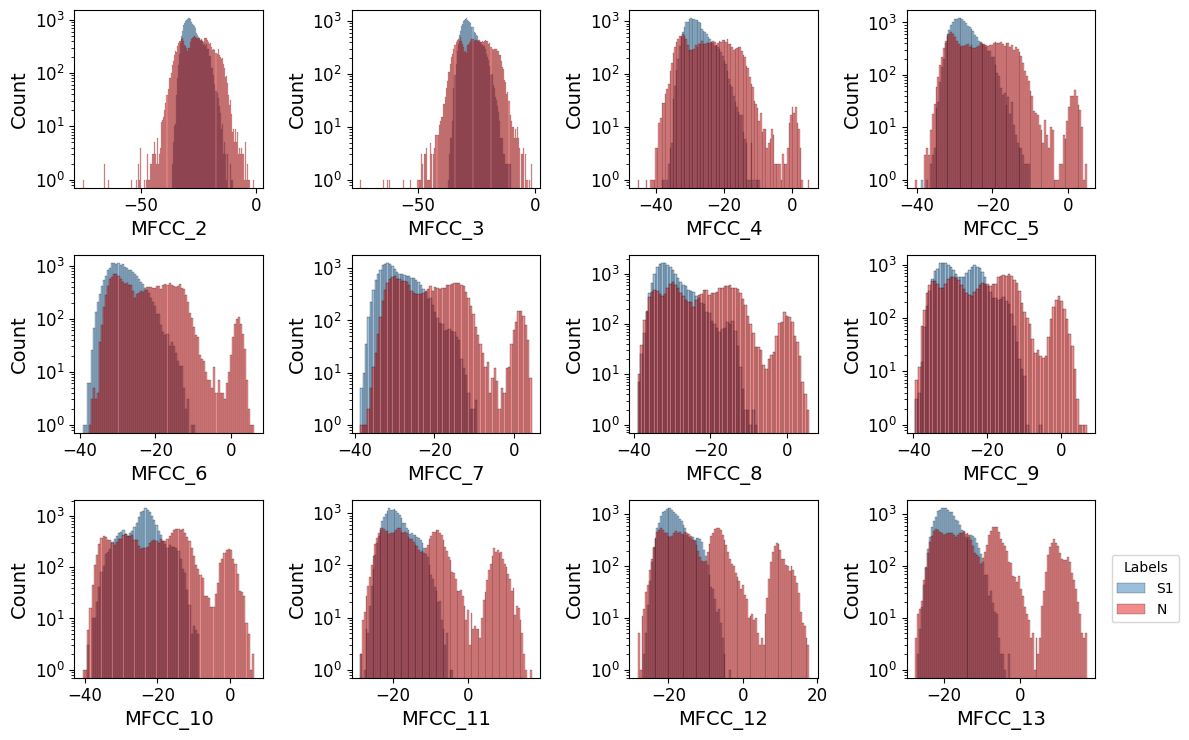

In [172]:
plot_mfcc_histograms(mean_MFCC[first_12_MFCC], mean_MFCC['label'])

The above figure shows the histograms of the mean MFCC values for a 6.2 second sequence of snoring and non-snoring. The plots show the two poluations overlap, however the S1 instances have a typically lower mean for each MFCC value. The non -snoring sequneces have an almost uniform distribution of means and are multi-modal.

**the 1st MFCC is not shown as it is extrmemely similar to MFCC 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

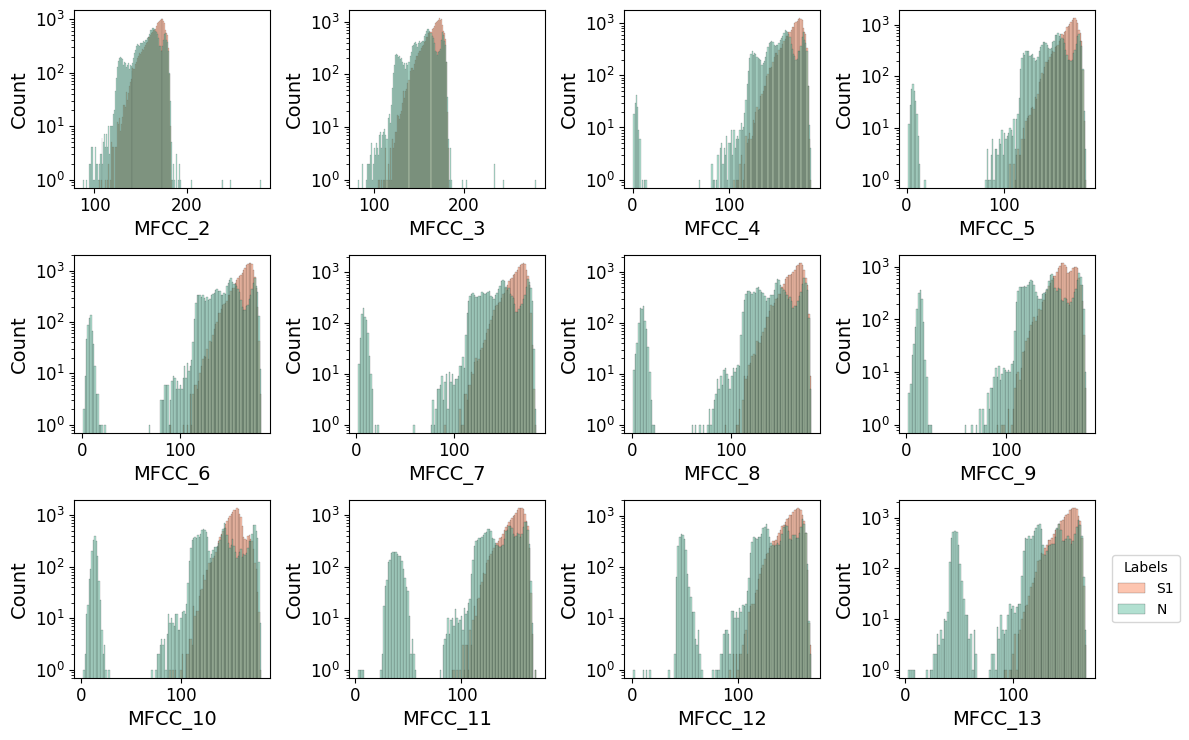

In [173]:
plot_mfcc_histograms(std_MFCC[first_12_MFCC], std_MFCC['label'],colour_set='Set2')

This plot looks at the SD, were we see than the snoring sequnces typically have a contistantly higher SD than the non snoring instances. The non-snoring instances do appear to multi modal having 4-5 modes per mfcc. The non-snoring sequneces also overlap with the snoring sequences.

# Scaled MFCC, all instacnes (timesteps * MFCC dimensions)

In [150]:
# Reshape MFCC data for easier plotting
mfcc_data_reshaped = masked_X_100.reshape(-1, 13)
df = pd.DataFrame(data=mfcc_data_reshaped, columns=[f'MFCC_{i+1}' for i in range(13)])


df['label'] = list(np.repeat(y_100,62))
df['label'] = df['label'].replace({'N': 'N', 'S1': 'S1', 'S2': 'S1', 'S3': 'S1'})


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

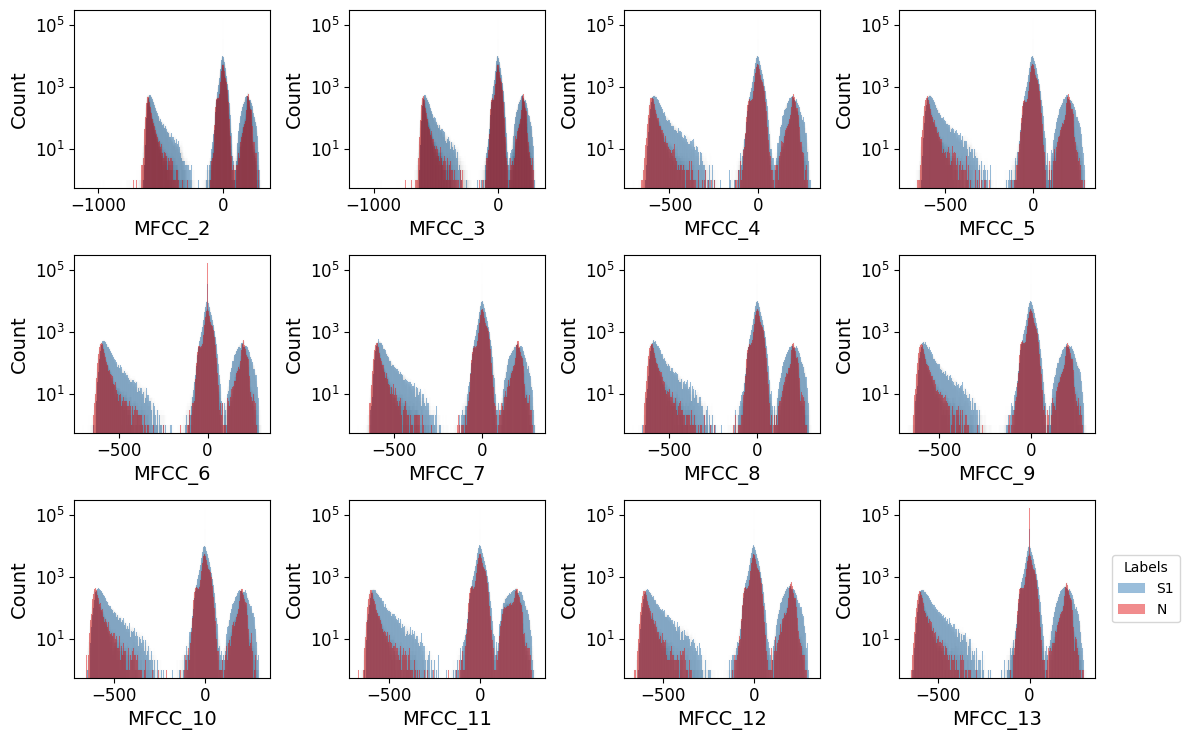

In [174]:
plot_mfcc_histograms(df[first_12_MFCC], df['label'],colour_set='Set1')

This figure shows the MFCC values for all instances. We see that there are three modes for each label for each MFCC. With the lower value mode being skewed to the right. The S1 labels have more instances in the upper and lower modes likely representing the rhythmic snoring sound.

<Axes: >

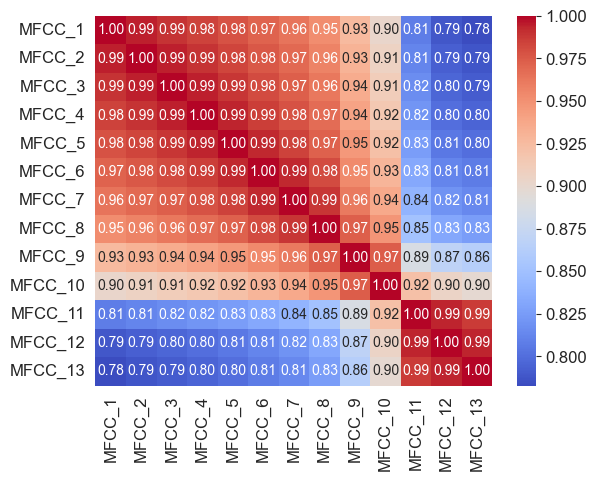

In [193]:
mfcc_list=[f'MFCC_{i+1}' for i in range(13)] #get list of MFCC's
corr_matrix=df[mfcc_list].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")


The correlation matrix shows that the first 8 MFCC are all highly correlated with eachother, MFCC 9-10 are correlated with eachother and MFCC 11-13 are correlated with eachother. Showing three different correalted groups in the variables.

# PCA

In [194]:
from sklearn.decomposition import PCA
df_clean = df.dropna() #drop NA values
mfcc_list=[f'MFCC_{i+1}' for i in range(13)] #get list of MFCC's
pca = PCA(n_components=2) #calucalte PCA
PCA_MFCC=pca.fit_transform(df_clean[mfcc_list])
#create dataframe for plotting
pc_scores=pd.DataFrame(PCA_MFCC,columns=["PC1","PC2"])
pc_scores["label"]=df_clean["label"]
#calculate the PC loadings for biplot
PC_Loadings = pd.DataFrame(pca.components_,columns=mfcc_list,index=pc_scores.columns[0:2])

In [195]:
#function to plot centroids. This is required for a later analysis but will be embeded in the biplot function
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
        
#function to make bi plot with extra functionality for adding decison boundaries for k-means models
def biplot(scores,loadings,labels=False,colour_palette=False,decision_boundaries=False,clusterer=False,centroids=False):
    fig, ax = plt.subplots(figsize=(15,8))
    
    #plot decision boundaries
    if decision_boundaries is not False:
        mins = scores.min(axis=0)-0.1
        maxs = scores.max(axis=0)+0.1
        xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 1000),np.linspace(mins[1], maxs[1], 1000))
    
        Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    
        Z = Z.reshape(xx.shape)

        ax.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
        ax.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
        #Plot centroids 
        if centroids is not False:
            ax.scatter(clusterer.cluster_centers_[:, 0], clusterer.cluster_centers_[:, 1],
                    marker='o', s=35, linewidths=8,
                    color='w', zorder=10, alpha=0.9)
        
            ax.scatter(clusterer.cluster_centers_[:, 0], clusterer.cluster_centers_[:, 1],
                    marker='x', s=2, linewidths=12,
                    color='k', zorder=11, alpha=1)
        
    #make a scatter plot of PC1 vs PC2
    hue_column=scores.columns[2]
    if colour_palette is False:
        sns.scatterplot(x='PC1', y="PC2", hue=hue_column,ax=ax, data=scores,size=10)
    else:
        sns.scatterplot(x='PC1', y="PC2", hue=hue_column,ax=ax,palette=colour_palette, data=scores)
    #set x-axis label
    ax.set_xlabel("PC1",fontsize=12)
    #set y-axis label
    ax.set_ylabel("PC2",fontsize=12)
    
    if labels is not False:
        for i, label in enumerate(labels):
            ax.text(scores.iloc[i][0], scores.iloc[i][1], label, ha='center', va='bottom',size=10)

    
    #create a second set of axes
    ax2 = ax.twinx().twiny()
    
    #setup font dictionary
    font = {'color':  'g',
            'weight': 'bold',
            'size': 12,
            }
    
    #make a loadings plot
    for col in loadings.columns.values:
        #where do our loading vectors end?
        tipx = loadings.loc['PC1',col]
        tipy = loadings.loc['PC2',col]
        #draw the vector, and write label text for col
        ax2.arrow(0, 0, tipx, tipy, color = 'r', alpha = 0.5)
        ax2.text(tipx*1.05, tipy*1.05, col, fontdict = font, ha = 'center', va = 'center')
    
    #centre 0 for X and Y on both axis
    #ax1.set_xlim([min(x) - x_buffer, max(x) + x_buffer])
    ax.set_ylim([-max(abs(min(scores.iloc[:,1])), abs(max(scores.iloc[:,1])))*1.1, max(abs(min(scores.iloc[:,1])), abs(max(scores.iloc[:,1])))*1.1])
    ax2.set_ylim([-max(abs(min(loadings.iloc[1])), abs(max(loadings.iloc[1])))*1.1 , max(abs(min(loadings.iloc[1])), abs(max(loadings.iloc[1])))*1.1])
    ax.set_xlim([-max(abs(min(scores.iloc[:,0])), abs(max(scores.iloc[:,0])))*1.1, max(abs(min(scores.iloc[:,0])), abs(max(scores.iloc[:,0])))*1.1])
    ax2.set_xlim([-max(abs(min(loadings.iloc[0])), abs(max(loadings.iloc[0])))*1.1, max(abs(min(loadings.iloc[0])), abs(max(loadings.iloc[0])))*1.1])
    

    #show plot
    plt.show()

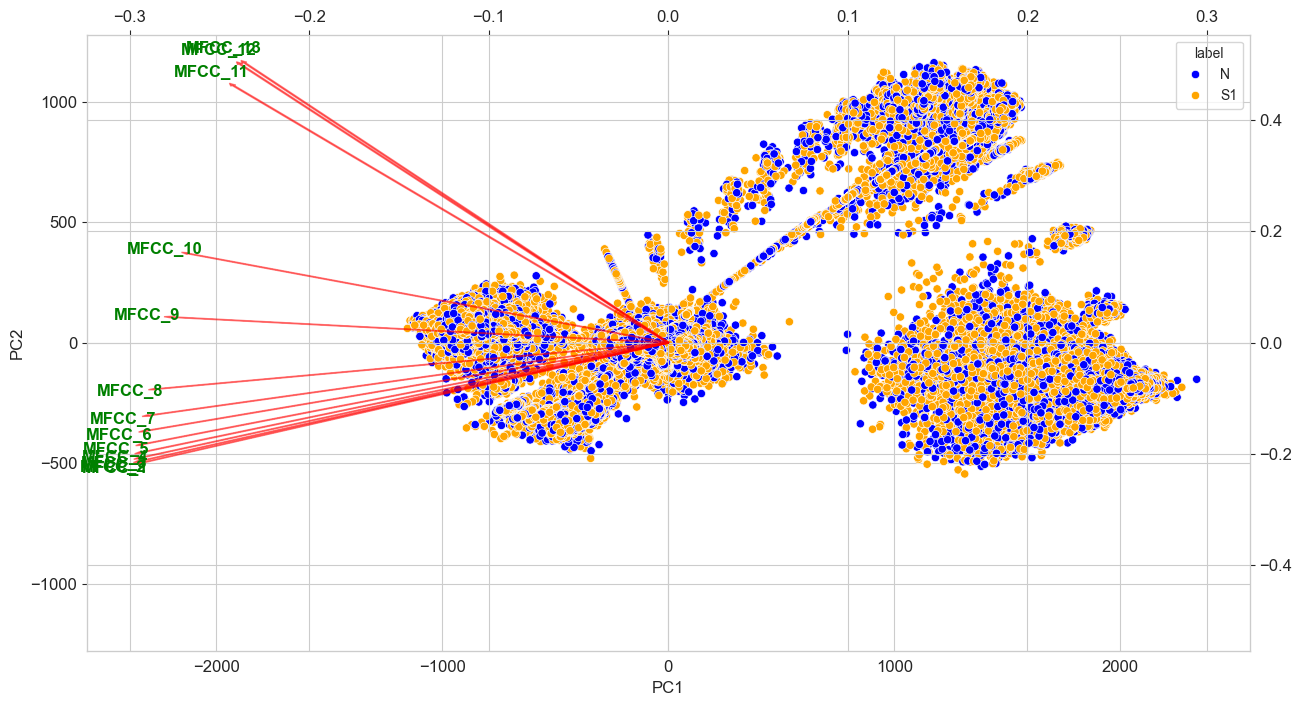

In [196]:
biplot(pc_scores,PC_Loadings,labels=False,colour_palette=['blue','orange'])

The bi plot shows three distict clusters in the first 2 PC however they do not appear to define snoring vs snornig instances. What is apaprent is that the first 1-7 MFCC's are related  due to the loadings of these values haveing a greate weight on PC1 while MFCCs 11-13 have a greater influence on PC2.

# Part 6 label duration

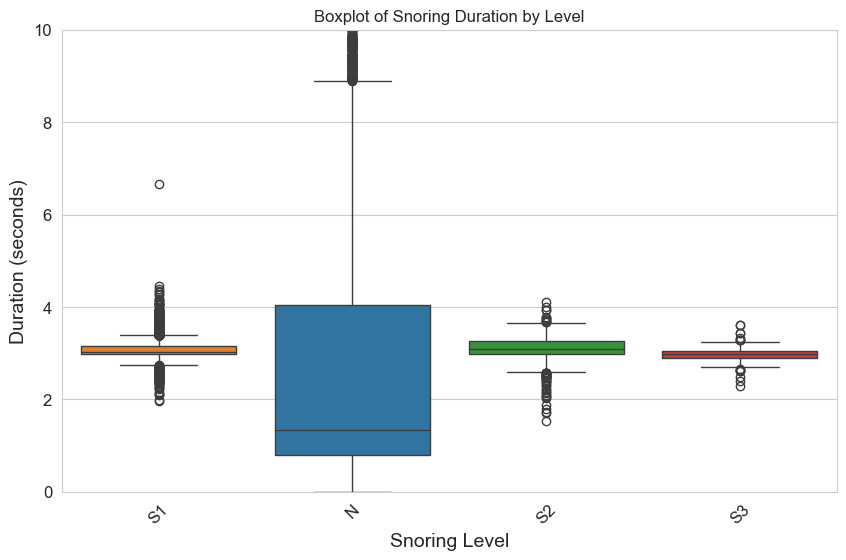

In [183]:
# Create a boxplot of snoring duration for each snoring level
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
ax = sns.boxplot(data=padded_trunc_mfcc_100 , x='label', y='duration', hue='label', order=padded_trunc_mfcc_100['label'].value_counts().index)
plt.xlabel('Snoring Level')
plt.ylabel('Duration (seconds)')
plt.title('Boxplot of Snoring Duration by Level')
plt.ylim(0, 10)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

In [184]:
# Group data by level and calculate average duration
padded_trunc_mfcc_100.groupby('label')['duration'].describe()

count       mean        std       min       25%       50%       75%  \
label                                                                          
N      18452.0  12.485116  92.340265  0.000515  0.800048  1.333511  4.033537   
S1     18994.0   3.076666   0.164908  1.955867  2.981100  3.013320  3.146530   
S2       865.0   3.086015   0.280219  1.531702  2.987537  3.079320  3.256300   
S3        81.0   2.978206   0.229648  2.281098  2.898452  2.987537  3.049224   

              max  
label              
N      4628.39756  
S1        6.66084  
S2        4.10577  
S3        3.61025

Looking at the box plot and statistical summary table the snoring duration has a mean of ~3 seconds while the non snoring intervals vary considerably, with the non-snoring duration being skewed. This is informative into the sequence length to analyse which should be around 3 seconds 

# Part 7 visualising the wavefiles.

In [ ]:
#This part is included in the inference model